In [7]:
import pandas as pd
import numpy as np
import librosa
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import seaborn as sns

import matplotlib.pyplot as plt
from IPython.display import Audio
import soundfile as sf

from scene_cls_model import Cnn_9layers_AvgPooling

In [3]:
from pytorch_grad_cam import GradCAM,GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image

In [4]:
eval_df = pd.read_csv('predictions.csv')
eval_df.shape

(4185, 3)

In [5]:
eval_df.head()

Filename    Predicted Label  \
0  /work/aistwal/dataset_tau2019/extracted-files/...  street_pedestrian   
1  /work/aistwal/dataset_tau2019/extracted-files/...              metro   
2  /work/aistwal/dataset_tau2019/extracted-files/...     street_traffic   
3  /work/aistwal/dataset_tau2019/extracted-files/...  street_pedestrian   
4  /work/aistwal/dataset_tau2019/extracted-files/...     street_traffic   

        Actual Label  
0  street_pedestrian  
1              metro  
2               park  
3  street_pedestrian  
4     street_traffic

AttributeError: Rectangle.set() got an unexpected keyword argument 'rotation'

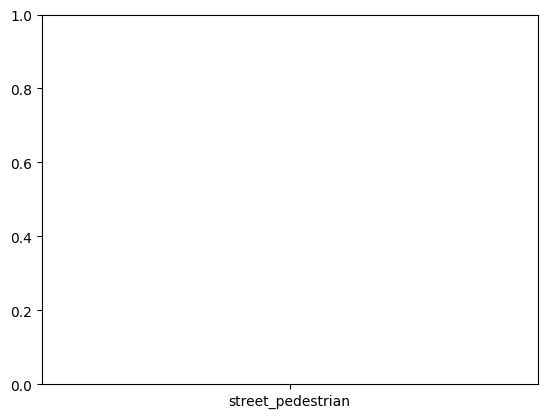

In [26]:
df_gb = eval_df['Predicted Label'].value_counts().reset_index()
df_gb.columns = ['Label', 'Counts']
sns.barplot(x = 'Label', y = 'Counts', data = df_gb, hue='Label', rot=45)

In [5]:
# Correct Predictions

In [6]:
correct_pred = eval_df[eval_df['Predicted Label'] == eval_df['Actual Label']]
correct_pred.shape

(2230, 3)

In [7]:
correct_pred.head()

Filename    Predicted Label  \
0  /work/aistwal/dataset_tau2019/extracted-files/...  street_pedestrian   
1  /work/aistwal/dataset_tau2019/extracted-files/...              metro   
3  /work/aistwal/dataset_tau2019/extracted-files/...  street_pedestrian   
4  /work/aistwal/dataset_tau2019/extracted-files/...     street_traffic   
7  /work/aistwal/dataset_tau2019/extracted-files/...            airport   

        Actual Label  
0  street_pedestrian  
1              metro  
3  street_pedestrian  
4     street_traffic  
7            airport

In [8]:
# Incorrect Predictions
incorrect_pred = eval_df[eval_df['Predicted Label'] != eval_df['Actual Label']]
incorrect_pred.shape

(1955, 3)

In [9]:
# Checking for accuracy to be 53.29%
correct_pred.shape[0]/(correct_pred.shape[0]+incorrect_pred.shape[0]) * 100

53.28554360812425

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# Instantiate and load the model
model = Cnn_9layers_AvgPooling(classes_num=10, activation="logsoftmax")
model_path = '/work/aistwal/MMDS_MasterThesis/models/checkpoints/tau_2019_conv_10_16.pth'
# model_path = '/work/aistwal/MMDS_MasterThesis/models/checkpoints/tau_2019_conv_new_10_16.pth'
model_name = model_path.split('/')[-1]
print("model name: ", model_name)
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

model name:  tau_2019_conv_10_16.pth


Cnn_9layers_AvgPooling(
  (conv_block1): ConvBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block2): ConvBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block3): ConvBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

In [12]:
correct_audio_list = correct_pred['Filename'].sample(n=10, random_state=1).tolist()
correct_audio_list

['/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44995-a.wav',
 '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44468-a.wav',
 '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8431-a.wav',
 '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44556-a.wav',
 '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7522-a.wav',
 '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6192-a.wav',
 '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8560-a.wav',
 '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-

In [13]:
labels = [
    "airport", "shopping_mall", "metro_station", "street_pedestrian",
    "public_square", "street_traffic", "tram", "bus", "metro", "park"]
lb_to_idx = {lb: idx for idx, lb in enumerate(labels)}
idx_to_lb = {idx: lb for idx, lb in enumerate(labels)}

In [52]:
def get_grayscale_cam(model, target_layers, tensor_x, targets):
    
    print("Target_layer ", target_layers)
    # cam = GradCAM(model=model,target_layers=target_layers)
    cam = GradCAMPlusPlus(model=model,target_layers=target_layers)
    grayscale_cam = cam(input_tensor=tensor_x, 
                        targets=targets)
    # print("original grayscale_cam", grayscale_cam.shape)
    
    # Here grayscale_cam has only one image in the batch
    grayscale_cam = grayscale_cam[0, :]
    return grayscale_cam

In [15]:
# target_layers = [model.conv_block4.conv2]
target_layers = [model.conv_block4.bn2]

# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested category.
targets = None


## The index of the class to visualize
# class_index = 3  # For example, class index 3 for class "STREET PEDESTRIAN"

## Using the ClassifierOutputTarget to focus on a specific class
# targets = [ClassifierOutputTarget(class_index)]

In [16]:
def predict(model, inputs):
    with torch.no_grad():
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

    return predicted

In [17]:
def display_log_mel_spectrogram(audioname, version, input_feature, model_name):
    print(audioname, "Log-Mel Feature Shape : ", input_feature.shape)
    plt.figure(figsize=(15, 6))
    plt.title(f'SPECTROGRAM FOR {audioname}')
    root_dir = '/work/aistwal/MMDS_MasterThesis/models/asc'
    save_path = os.path.join(root_dir, 'files', model_name, version)
    
    # Create the directory if it does not exist
    os.makedirs(save_path, exist_ok=True)
    
    file_path = os.path.join(save_path, f'{audioname}-spectrogram.png')
    librosa.display.specshow(input_feature, x_axis='time', y_axis='linear', sr=32000)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.savefig(file_path)
    plt.show()

In [18]:
def blackout_unimportant_features(grayscale_cam, input_spectrogram, threshold=0.5):
    normalized_cam = (grayscale_cam - np.min(grayscale_cam)) / (np.max(grayscale_cam) - np.min(grayscale_cam))
    # Create a mask for important regions
    important_mask = normalized_cam >= threshold
    
    # Get the minimum value of the input spectrogram
    min_value = np.min(input_spectrogram)
    
    # Create a copy of the input spectrogram to modify
    modified_spectrogram = np.copy(input_spectrogram)
    
    # Blackout unimportant regions by setting them to the minimum value
    modified_spectrogram[~important_mask] = min_value
    
    return modified_spectrogram

In [19]:
def spectrogram_indices_to_sample_range(col_index, hop_length = 500, n_fft = 1024):
    """     
    Convert the column index of a spectrogram to the sample range of the original waveform.     
    Parameters:     
    
    column_index (int): The column index of the spectrogram.     
    hop_length (int): The hop length used in the STFT.     
    n_fft (int): The window length (number of FFT points) used in the STFT.     
    
    Returns:     
        tuple: A tuple containing the start and end sample indices (inclusive) in the original waveform.     
    """
    start_sample = col_index * hop_length
    end_sample = start_sample + n_fft
    return start_sample, end_sample

In [20]:
# # Fetch timestamps where audio was not activated
# def fetch_audio_timestamps(generalized_cam_version, col_list):
#     timestamps = np.array(col_list) * 500 / 32000
#     return timestamps

In [21]:
# def blackout_only_x_dim(grayscale_cam, log_mel_spectrogram, threshold=0.35):

#     # Create copy of input_spectrogram
#     generalized_cam_version = np.copy(log_mel_spectrogram) #64*641
    
#     # Get the minimum value of the input spectrogram
#     min_value = np.min(log_mel_spectrogram)
    
#     normalized_cam = (grayscale_cam - np.min(grayscale_cam)) / (np.max(grayscale_cam) - np.min(grayscale_cam))
#     print("Columns: ", normalized_cam.shape[1])

#     deactivated_col_list = []
#     for col in range(0, normalized_cam.shape[1]):
#         flag = np.all(normalized_cam[:,col] < threshold)
#         if flag:
#             deactivated_col_list.append(col)
#             generalized_cam_version[:,col] = min_value
            
#     return generalized_cam_version, deactivated_col_list

In [42]:
def blackout_only_x_dim(grayscale_cam, log_mel_spectrogram, percentile = 85):

    # Create copy of input_spectrogram
    generalized_cam_version = np.copy(log_mel_spectrogram) #64*641
    
    # Get the minimum value of the input spectrogram
    min_value = np.min(log_mel_spectrogram)
    
    normalized_cam = (grayscale_cam - np.min(grayscale_cam)) / (np.max(grayscale_cam) - np.min(grayscale_cam))
    print("Columns: ", normalized_cam.shape[1])

    threshold = np.percentile(normalized_cam, percentile)
    threshold = float("{:.1f}".format(threshold))
    print("Threshold: ", threshold)
    deactivated_col_list = []
    for col in range(0, normalized_cam.shape[1]):
        flag = np.all(normalized_cam[:,col] < threshold)
        if flag:
            deactivated_col_list.append(col)
            generalized_cam_version[:,col] = min_value
            
    return generalized_cam_version, deactivated_col_list

In [23]:
audio_path = correct_audio_list[5]
print(audio_path)
# Load the audio file
audio, sr = librosa.load(audio_path, sr = 32000)
print(audio.shape)
print("Sampling rate: ",sr)
Audio(data=audio, rate=sr)

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6192-a.wav
(320000,)
Sampling rate:  32000


In [24]:
audio

array([0.00064918, 0.00076184, 0.00052589, ..., 0.00019727, 0.0004071 ,
       0.00060503], dtype=float32)

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44995-a.wav
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Shape of grayscale_cam  (64, 641)
Shape of log_mel_spectrogram  (64, 641)
Columns:  641
Threshold:  0.57
Minimum value of audio:  -0.10068001
Altered audio shape : (320000,)
Original audio shape : (320000,)
Shape of modified_spectrogram  (64, 641)
Prediction for  tram-lyon-1225-44995-a.wav is  tram
Prediction after cam mask for  tram-lyon-1225-44995-a.wav is  tram
tram-lyon-1225-44995-a.wav Log-Mel Feature Shape :  (64, 641)


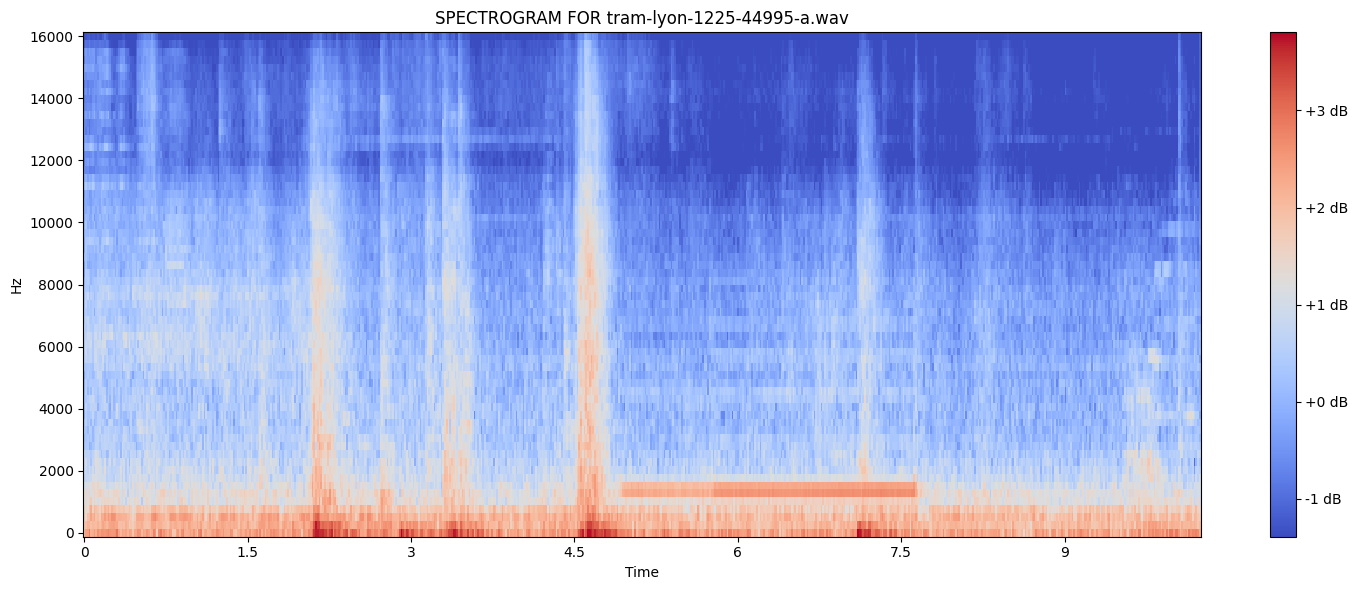

tram-lyon-1225-44995-a.wav_modified Log-Mel Feature Shape :  (64, 641)


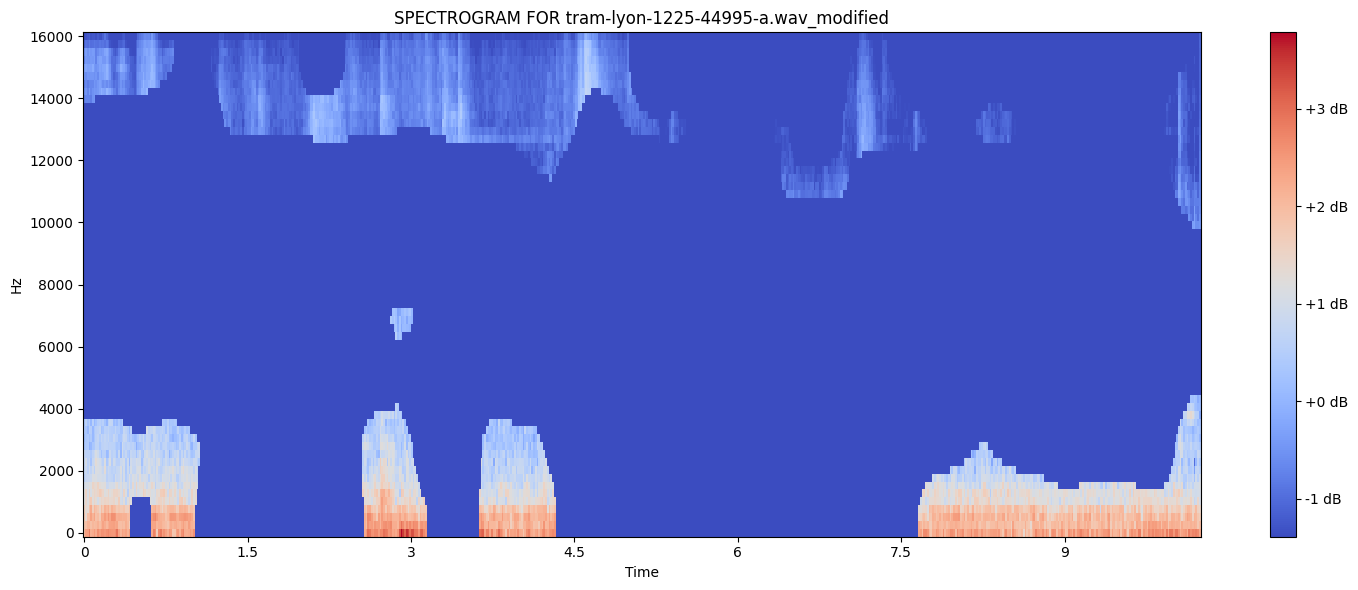

tram-lyon-1225-44995-a.wav_generalized Log-Mel Feature Shape :  (64, 641)


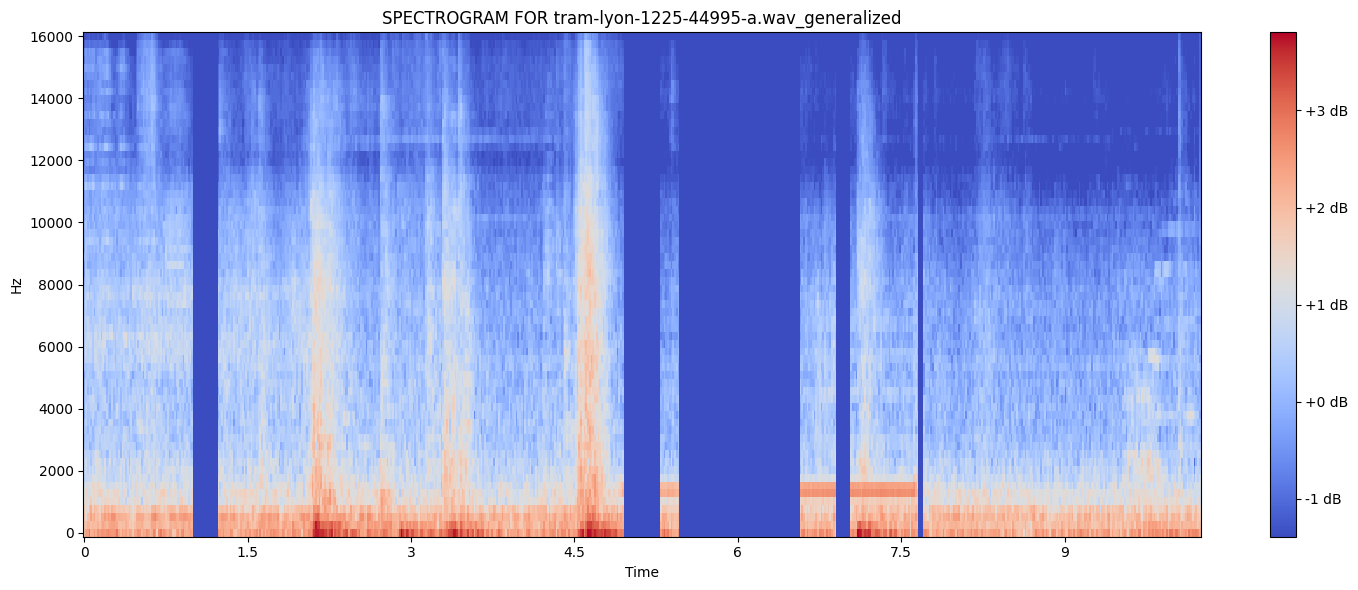

In [26]:
for audio in correct_audio_list[0:]:
    print(audio)
    audioname = audio.split('/')[-1]
    
    # Load the audio file
    y, sr = librosa.load(audio, sr=32000)
    
    # Convert to log mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=500, n_mels=64)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    
    # Normalize the spectrogram
    log_mel_spectrogram = (log_mel_spectrogram - log_mel_spectrogram.mean()) / log_mel_spectrogram.std()
    #print(log_mel_spectrogram.shape) #(64, 641)
    
    # Convert to torch tensor
    log_mel_spectrogram_tensor = torch.tensor(log_mel_spectrogram, dtype=torch.float32).unsqueeze(0)
    # print(log_mel_spectrogram_tensor.shape)   #--- torch.Size([1, 64, 641])
    preds = predict(model, log_mel_spectrogram_tensor)
    preds = preds.cpu().numpy()
    
    # targets = [ClassifierOutputTarget(preds[0])]
    
    grayscale_cam = get_grayscale_cam(model, target_layers, log_mel_spectrogram_tensor, targets)

    print("Shape of grayscale_cam ", grayscale_cam.shape)
    print("Shape of log_mel_spectrogram ", log_mel_spectrogram.shape)
    
    modified_spectrogram = blackout_unimportant_features(grayscale_cam, log_mel_spectrogram)
    generalized_cam_version, deactivated_col_list = blackout_only_x_dim(grayscale_cam, log_mel_spectrogram)
    # Convert to torch tensor
    generalized_cam_version_tensor = torch.tensor(generalized_cam_version, dtype=torch.float32).unsqueeze(0)
    # print("deactivated_col_list",deactivated_col_list)
    
    #Get altered audio
    y_alt = np.copy(y)
    print("Minimum value of audio: ", y.min())
    # y_alt[indices[:-1]] = 0 #setting it to 0

    # Get start index and stop index
    for col_index in deactivated_col_list:
        start_sample, end_sample = spectrogram_indices_to_sample_range(col_index)
        # print(start_sample, end_sample)
        y_alt[start_sample:end_sample+1] = y.min()
    
    # # timestamps = fetch_audio_timestamps(generalized_cam_version, deactivated_col_list)
    # # print("Deactivated-Timestamps :\n", timestamps)
   
    # #Retreive indices from timestamps
    # indices = (timestamps * 32000).astype(int)
    # # print("Audio Indices to be muted : ", type(indices), indices.shape, indices)
    # print("Number of audio indices to be muted: ", len(indices))
    

    print("Altered audio shape :" ,y_alt.shape)
    print("Original audio shape :",y.shape)

    

    print("Shape of modified_spectrogram ",modified_spectrogram.shape)
    
    preds_after_cam = predict(model, generalized_cam_version_tensor)
    
    # Print the predicted label
    preds_after_cam = preds_after_cam.cpu().numpy()
    
    pred_label = idx_to_lb[preds[0]]
    preds_after_cam_label = idx_to_lb[preds_after_cam[0]]
    print("Prediction for ",audioname ,"is ", pred_label)
    print("Prediction after cam mask for ", audioname, "is ", preds_after_cam_label)
    display_log_mel_spectrogram(audioname, "spectrograms",log_mel_spectrogram, model_name)
    display_log_mel_spectrogram(audioname+"_modified", "cam_spectrograms", modified_spectrogram, model_name)
    display_log_mel_spectrogram(audioname+"_generalized","generalized_cam_spectrograms", generalized_cam_version, model_name)
    break



In [27]:
audio_path = correct_audio_list[0]
print(audio_path)
# Load the audio file
audio, sr = librosa.load(audio_path, sr = 32000)
print(audio.shape)
print("Sampling rate: ",sr)
Audio(data=audio, rate=sr)

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44995-a.wav
(320000,)
Sampling rate:  32000


In [28]:
generalized_cam_version.shape

(64, 641)

In [29]:
y_alt.shape
Audio(data=y_alt, rate=32000)

In [30]:
def print_audio_tagging_result(clipwise_output):
    """Visualization of audio tagging result.

    Args:
      clipwise_output: (classes_num,)
    """
    sorted_indexes = np.argsort(clipwise_output)[::-1]

    # Print audio tagging top probabilities
    for k in range(10):
        print('{}: {:.3f}'.format(np.array(labels)[sorted_indexes[k]], 
            clipwise_output[sorted_indexes[k]]))

In [31]:
from panns_inference import AudioTagging, SoundEventDetection, labels
# INITIALIZE THE AUDIO TAGGER
at = AudioTagging(checkpoint_path='/home/aistwal/panns_data/Cnn14_mAP=0.431.pth', device="cuda")
audio = correct_audio_list[9]

print(correct_audio_list[9])
audioname = audio.split('/')[-1]
# Load the audio file
y, sr = librosa.load(audio, sr=32000)

#check panns inference
y = y[None, :]  # (batch_size, segment_samples)
print(y.shape)
(clipwise_output, embedding) = at.inference(y)
print_audio_tagging_result(clipwise_output[0])

print("New audio",y_alt.shape)
#check panns inference
y_new = y_alt[None, :]
(clipwise_output, embedding) = at.inference(y_new)
print_audio_tagging_result(clipwise_output[0])


Checkpoint path: /home/aistwal/panns_data/Cnn14_mAP=0.431.pth
GPU number: 8
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44609-a.wav
(1, 320000)
Speech: 0.889
Clip-clop: 0.243
Animal: 0.183
Horse: 0.171
Outside, urban or manmade: 0.163
Run: 0.133
Vehicle: 0.096
Male speech, man speaking: 0.045
Walk, footsteps: 0.039
Outside, rural or natural: 0.030
New audio (320000,)
Door: 0.750
Sliding door: 0.710
Cupboard open or close: 0.210
Slam: 0.186
Music: 0.172
Speech: 0.057
Vehicle: 0.033
Power windows, electric windows: 0.028
Animal: 0.020
Knock: 0.020


### UNSEEN AUDIO

In [227]:
#testing the model on an unseen test audio 
test_dir = '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-leaderboard/audio/'
# afile = '2420.wav'
afile = '561.wav'
# afile = '1020.wav'
# afile = '1024.wav'
# afile = '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44995-a.wav'
# afile = '427.wav'
audio = test_dir + afile
audio 

'/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-leaderboard/audio/561.wav'

In [228]:
# Display Audio
ad, sr = librosa.load(audio, sr = 32000)
print(ad.shape, sr)
print("Sampling rate: ",sr)
Audio(data=ad, rate=sr)

(320000,) 32000
Sampling rate:  32000


In [229]:
print(audio)
audioname = audio.split('/')[-1]
print(audioname)
# Load the audio file
y, sr = librosa.load(audio, sr=32000)

# Convert to log mel-spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=32000, n_fft=1024, hop_length=500, n_mels=64)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

# Normalize the spectrogram
log_mel_spectrogram = (log_mel_spectrogram - log_mel_spectrogram.mean()) / log_mel_spectrogram.std()
#print(log_mel_spectrogram.shape) #(64, 641)

# Convert to torch tensor
log_mel_spectrogram_tensor = torch.tensor(log_mel_spectrogram, dtype=torch.float32).unsqueeze(0)
# print(log_mel_spectrogram_tensor.shape) torch.Size([1, 64, 641])

grayscale_cam = get_grayscale_cam(model, target_layers, log_mel_spectrogram_tensor, targets)

print("Shape of grayscale_cam ", grayscale_cam.shape)
print("Shape of log_mel_spectrogram ", log_mel_spectrogram.shape)

modified_spectrogram = blackout_unimportant_features(grayscale_cam, log_mel_spectrogram)
generalized_cam_version, deactivated_col_list = blackout_only_x_dim(grayscale_cam, log_mel_spectrogram)
# print("deactivated_col_list",deactivated_col_list)
timestamps = fetch_audio_timestamps(generalized_cam_version, deactivated_col_list)
# print("Deactivated-Timestamps :\n", timestamps)

#Retreive indices from timestamps
indices = (timestamps * 32000).astype(int)
# print("Audio Indices to be muted : ", type(indices), indices)
print("Number of audio indices to be muted: ", len(indices))

#Get altered audio
y_alt = np.copy(y)
y_alt[indices[:-1]] = 0 #setting it to 0

print("Altered audio shape :" ,y_alt.shape)
print("Original audio shape :",y.shape)



# # Convert modified_spectrogram to torch tensor
# modified_spectrogram_tensor = torch.tensor(modified_spectrogram, dtype=torch.float32).unsqueeze(0)
print("Shape of modified_spectrogram ",modified_spectrogram.shape)
preds = predict(model, log_mel_spectrogram_tensor)

# Print the predicted label
preds = preds.cpu().numpy()
pred_label = idx_to_lb[preds[0]]
print("Prediction for ",audioname ,"is ", pred_label)
display_log_mel_spectrogram(audioname, "spectrograms",log_mel_spectrogram, model_name)
display_log_mel_spectrogram(audioname+"_modified", "cam_spectrograms", modified_spectrogram, model_name)
display_log_mel_spectrogram(audioname+"_generalized","generalized_cam_spectrograms", generalized_cam_version, model_name)

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-leaderboard/audio/561.wav
561.wav
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Shape of grayscale_cam  (64, 641)
Shape of log_mel_spectrogram  (64, 641)
Columns:  641


NameError: name 'fetch_audio_timestamps' is not defined

In [ ]:
y_alt.shape

In [ ]:
def print_audio_tagging_result(clipwise_output):
    sorted_indexes = np.argsort(clipwise_output)[::-1]
    events = []
    # Print audio tagging top probabilities
    for k in range(10):
        print('{}: {:.3f}'.format(np.array(labels)[sorted_indexes[k]], 
            clipwise_output[sorted_indexes[k]]))
        events.append(np.array(labels)[sorted_indexes[k]])
    return events

In [230]:
from panns_inference import AudioTagging, SoundEventDetection, labels
# INITIALIZE THE AUDIO TAGGER
at = AudioTagging(checkpoint_path='/home/aistwal/panns_data/Cnn14_mAP=0.431.pth', device="cuda")

#check panns inference
y = y[None, :]  # (batch_size, segment_samples)
print(y.shape)
(clipwise_output, embedding) = at.inference(y)
events_before = print_audio_tagging_result(clipwise_output[0])

#check panns inference
y_new = y_alt[None, :]
print("New audio",y_alt.shape)
(clipwise_output, embedding) = at.inference(y_new)
events_after = print_audio_tagging_result(clipwise_output[0])

Checkpoint path: /home/aistwal/panns_data/Cnn14_mAP=0.431.pth
GPU number: 8
(1, 320000)
Speech: 0.745
Vehicle: 0.534
Car: 0.157
Bus: 0.107
Music: 0.101
Aircraft: 0.080
Outside, urban or manmade: 0.062
Field recording: 0.061
Fixed-wing aircraft, airplane: 0.055
Boat, Water vehicle: 0.055
New audio (320000,)
Speech: 0.845
Clip-clop: 0.177
Horse: 0.148
Animal: 0.143
Outside, urban or manmade: 0.135
Run: 0.114
Vehicle: 0.109
Male speech, man speaking: 0.069
Music: 0.031
Car: 0.027


In [231]:
# clipwise_output[0] #basically represents the probabilities for all 527 classes of events from audio set.

In [232]:
!pip install matplotlib-venn

In [233]:
from matplotlib_venn import venn2

# Example data
set_before = set(events_before)
set_after = set(events_after)

venn2([set_before, set_after], ('Before CAM', 'After CAM'))
plt.title('Event overlap before and after CAM')
plt.show()

TypeError: 'NoneType' object is not iterable

### COLLECT EVENT LIST FOR ALL THE CORRECTLY PREDICTED AUDIOS


In [53]:
correct_pred = eval_df[eval_df['Predicted Label'] == eval_df['Actual Label']]
print(correct_pred.shape)
correct_pred.head()

(2230, 3)


Filename    Predicted Label  \
0  /work/aistwal/dataset_tau2019/extracted-files/...  street_pedestrian   
1  /work/aistwal/dataset_tau2019/extracted-files/...              metro   
3  /work/aistwal/dataset_tau2019/extracted-files/...  street_pedestrian   
4  /work/aistwal/dataset_tau2019/extracted-files/...     street_traffic   
7  /work/aistwal/dataset_tau2019/extracted-files/...            airport   

        Actual Label  
0  street_pedestrian  
1              metro  
3  street_pedestrian  
4     street_traffic  
7            airport

In [54]:
# INITIALIZE THE AUDIO TAGGER
at = AudioTagging(checkpoint_path='/home/aistwal/panns_data/Cnn14_mAP=0.431.pth', device="cuda")

Checkpoint path: /home/aistwal/panns_data/Cnn14_mAP=0.431.pth
GPU number: 8


In [55]:
def print_audio_tagging_result(clipwise_output):
    sorted_indexes = np.argsort(clipwise_output)[::-1]
    events = []
    for k in range(10):
        # print('{}: {:.3f}'.format(np.array(labels)[sorted_indexes[k]], 
        #     clipwise_output[sorted_indexes[k]]))
        events.append(np.array(labels)[sorted_indexes[k]])
    return events

In [56]:
# GET EVENTS FOR ALL CORRECTLY PREDICTED 2230 AUDIOS, AND STORE THE PREDICTED SCENE AFTER CAM MASK

from tqdm import tqdm

final_events_before = []
final_events_after = []
final_preds_cam_label = []

for file in tqdm(correct_pred['Filename']):

    audioname = file.split('/')[-1]
    print(audioname)
    # Load audio
    y, sr = librosa.load(file, sr=32000)
    
    # Convert to log mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=32000, n_fft=1024, hop_length=500, n_mels=64)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    
    # Normalize the spectrogram
    log_mel_spectrogram = (log_mel_spectrogram - log_mel_spectrogram.mean()) / log_mel_spectrogram.std()
    #print(log_mel_spectrogram.shape) #(64, 641)
    
    # Convert to torch tensor
    log_mel_spectrogram_tensor = torch.tensor(log_mel_spectrogram, dtype=torch.float32).unsqueeze(0)
    # print(log_mel_spectrogram_tensor.shape) torch.Size([1, 64, 641])

    print("Targets ",targets)
    grayscale_cam = get_grayscale_cam(model, target_layers, log_mel_spectrogram_tensor, targets)
    
    modified_spectrogram = blackout_unimportant_features(grayscale_cam, log_mel_spectrogram)
    generalized_cam_version, deactivated_col_list = blackout_only_x_dim(grayscale_cam, log_mel_spectrogram)
    
    # Convert to torch tensor
    generalized_cam_version_tensor = torch.tensor(generalized_cam_version, dtype=torch.float32).unsqueeze(0)
    # print("deactivated_col_list",deactivated_col_list)
    
    #Get altered audio
    y_alt = np.copy(y)
    print("Minimum value of audio: ", y.min())
    # y_alt[indices[:-1]] = 0 #setting it to 0

    # Get start index and stop index
    for col_index in deactivated_col_list:
        start_sample, end_sample = spectrogram_indices_to_sample_range(col_index)
        # print(start_sample, end_sample)
        y_alt[start_sample:end_sample+1] = y.min()

    
    # # Convert modified_spectrogram to torch tensor
    # modified_spectrogram_tensor = torch.tensor(modified_spectrogram, dtype=torch.float32).unsqueeze(0)
    # print("Shape of modified_spectrogram ",modified_spectrogram.shape)
    preds = predict(model, log_mel_spectrogram_tensor)
    preds_cam = predict(model, generalized_cam_version_tensor)
    
    # Print the predicted label
    preds = preds.cpu().numpy()
    pred_label = idx_to_lb[preds[0]]
    preds_cam = preds_cam.cpu().numpy()
    preds_cam_label = idx_to_lb[preds_cam[0]]
    print("Prediction for ",audioname ,"is ", pred_label)
    print("Prediction after cam mask: ", preds_cam_label)
    final_preds_cam_label.append(preds_cam_label)
    # display_log_mel_spectrogram(audioname, "spectrograms",log_mel_spectrogram, model_name)
    # display_log_mel_spectrogram(audioname+"_modified", "cam_spectrograms", modified_spectrogram, model_name)
    # display_log_mel_spectrogram(audioname+"_generalized","generalized_cam_spectrograms", generalized_cam_version, model_name)

    # Get panns inference for unaltered audio
    y = y[None, :]  # (batch_size, segment_samples)
    (clipwise_output, embedding) = at.inference(y)
    events_before = print_audio_tagging_result(clipwise_output[0])
    final_events_before.append(events_before)
    
    # Get panns inference for altered audio
    y_new = y_alt[None, :]
    (clipwise_output, embedding) = at.inference(y_new)
    events_after = print_audio_tagging_result(clipwise_output[0])
    final_events_after.append(events_after)    
    
    print("----"*25)
    

  0%|                                                                                                     | 2/2230 [00:00<02:03, 18.07it/s]

street_pedestrian-lyon-1162-44093-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.007459752
Prediction for  street_pedestrian-lyon-1162-44093-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro-prague-1163-44094-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.3691916
Prediction for  metro-prague-1163-44094-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-44096-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Column

  0%|▎                                                                                                    | 6/2230 [00:00<02:05, 17.65it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.035870045
Prediction for  street_traffic-milan-1166-44097-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44100-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.012390156
Prediction for  airport-lyon-1169-44100-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro_station-prague-1170-44101-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.15691179
Prediction for  metro_station-prague-1170-44101-a.wav is  metro_station
Prediction after cam ma

  0%|▍                                                                                                   | 10/2230 [00:00<02:08, 17.31it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.013888352
Prediction for  airport-milan-1172-44103-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44105-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.04976526
Prediction for  street_pedestrian-lisbon-1174-44105-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-44106-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value o

  1%|▋                                                                                                   | 14/2230 [00:00<02:07, 17.42it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-lisbon-1176-44108-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.006702589
Prediction for  shopping_mall-lisbon-1176-44108-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
bus-lyon-1177-44109-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.05005766
Prediction for  bus-lyon-1177-44109-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44112-a.wav
Targets  None
Target_layer  [BatchNorm2d

  1%|▋                                                                                                   | 16/2230 [00:00<02:18, 15.95it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.18018197
Prediction for  tram-prague-1184-44119-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-lyon-1186-44122-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.12001818
Prediction for  bus-lyon-1186-44122-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
metro_station-milan-1187-44123-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.09753248
Prediction for  metro_station-milan-1187-44123-a.wav is  metro_station
Prediction after cam mask:  metro_station
-----------------------------

  1%|▊                                                                                                   | 18/2230 [00:01<02:28, 14.92it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0040859575
Prediction for  park-lyon-1188-44124-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
airport-milan-1172-44126-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.025008904
Prediction for  airport-milan-1172-44126-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44127-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.024698684
Prediction for  air

  1%|▉                                                                                                   | 22/2230 [00:01<02:32, 14.46it/s]

----------------------------------------------------------------------------------------------------
bus-lyon-1177-44129-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.05323643
Prediction for  bus-lyon-1177-44129-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44130-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.013350835
Prediction for  street_pedestrian-lyon-1162-44130-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-44133-a.wav
Targets  None
Target_layer  [BatchNorm2

  1%|█                                                                                                   | 24/2230 [00:01<02:28, 14.84it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.03929974
Prediction for  public_square-prague-1192-44134-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-44135-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.03766874
Prediction for  street_traffic-prague-1193-44135-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-prague-1185-44137-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Mi

  1%|█▏                                                                                                  | 26/2230 [00:01<02:37, 13.96it/s]

----------------------------------------------------------------------------------------------------
park-lyon-1188-44138-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0036417383
Prediction for  park-lyon-1188-44138-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
public_square-prague-1192-44139-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.028394558
Prediction for  public_square-prague-1192-44139-a.wav is  public_square
Prediction after cam mask:  public_square


  1%|█▎                                                                                                  | 28/2230 [00:01<02:42, 13.52it/s]

----------------------------------------------------------------------------------------------------
tram-prague-1184-44141-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


  1%|█▎                                                                                                  | 30/2230 [00:01<02:45, 13.25it/s]

Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.17490575
Prediction for  tram-prague-1184-44141-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
metro-lyon-1181-44146-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.09423973
Prediction for  metro-lyon-1181-44146-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
park-lisbon-1198-44147-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0105229225
Prediction for  park-lisbon-1198-44147-a.wav is  park
Prediction after cam mask:  park
------------------------------------------------------

  1%|█▍                                                                                                  | 32/2230 [00:02<02:46, 13.16it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.15325595
Prediction for  metro-lisbon-1199-44150-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-44151-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.011820539
Prediction for  street_pedestrian-milan-1165-44151-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-44156-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Min

  2%|█▌                                                                                                  | 34/2230 [00:02<02:48, 13.05it/s]

----------------------------------------------------------------------------------------------------
bus-lyon-1177-44159-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.032558743
Prediction for  bus-lyon-1177-44159-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-44160-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.02348132
Prediction for  street_traffic-milan-1202-44160-a.wav is  street_traffic
Prediction after cam mask:  street_traffic


  2%|█▌                                                                                                  | 36/2230 [00:02<02:52, 12.75it/s]

----------------------------------------------------------------------------------------------------
park-lyon-1188-44161-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


  2%|█▋                                                                                                  | 38/2230 [00:02<02:51, 12.75it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.004740347
Prediction for  park-lyon-1188-44161-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-44163-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.035346813
Prediction for  street_traffic-prague-1193-44163-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-44164-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.009618698
Prediction for  street_pedestrian-prague-1203-44164-a.wav is  street_pedestrian
Predictio

  2%|█▊                                                                                                  | 40/2230 [00:02<02:47, 13.10it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0536737
Prediction for  metro-lyon-1181-44168-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
airport-prague-1195-44169-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.009554318
Prediction for  airport-prague-1195-44169-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
park-lisbon-1198-44170-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5


  2%|█▉                                                                                                  | 42/2230 [00:02<02:36, 13.94it/s]

Minimum value of audio:  -0.0077038934
Prediction for  park-lisbon-1198-44170-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
metro-lyon-1206-44172-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.08626455


  2%|█▉                                                                                                  | 44/2230 [00:03<02:32, 14.35it/s]

Prediction for  metro-lyon-1206-44172-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44174-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.01757411
Prediction for  street_pedestrian-lisbon-1174-44174-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44176-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.06619415
Prediction for  street_traffic-lisbon-1171-44176-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------

  2%|██▏                                                                                                 | 48/2230 [00:03<02:24, 15.13it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44179-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.014325282
Prediction for  street_pedestrian-lisbon-1174-44179-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
bus-milan-1180-44182-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.22983411
Prediction for  bus-milan-1180-44182-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
tram-prague-1210-44184-a.wav
Targets  None
Target_layer  [BatchNorm2d(51

  2%|██▏                                                                                                 | 50/2230 [00:03<02:17, 15.85it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.008953258
Prediction for  street_pedestrian-lyon-1162-44185-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-44186-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.019699963
Prediction for  airport-lisbon-1175-44186-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
park-prague-1185-44187-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of a

  2%|██▍                                                                                                 | 53/2230 [00:03<02:05, 17.29it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.08111513
Prediction for  public_square-lisbon-1211-44190-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44192-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


  3%|██▌                                                                                                 | 56/2230 [00:03<01:58, 18.29it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.057803534
Prediction for  street_traffic-lisbon-1171-44192-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44194-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.007506247
Prediction for  street_pedestrian-lyon-1162-44194-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-44195-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.014628912
Prediction for  street_pedestrian-milan-1165-44195

  3%|██▌                                                                                                 | 58/2230 [00:03<01:58, 18.31it/s]

Minimum value of audio:  -0.09784558
Prediction for  street_traffic-milan-1202-44201-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro-prague-1163-44202-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.11105496
Prediction for  metro-prague-1163-44202-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
park-prague-1185-44203-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.019455735
Prediction for  park-prague-1185-44203-a.wav is  park
Prediction after cam mask:  metro_station


  3%|██▋                                                                                                 | 60/2230 [00:03<02:05, 17.29it/s]

----------------------------------------------------------------------------------------------------
tram-milan-1182-44204-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.05605894


  3%|██▊                                                                                                 | 62/2230 [00:04<02:13, 16.23it/s]

Prediction for  tram-milan-1182-44204-a.wav is  tram
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-milan-1172-44205-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.016056508
Prediction for  airport-milan-1172-44205-a.wav is  airport
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44207-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.021358706
Prediction for  street_traffic-milan-1166-44207-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
-----------------------------------------------------------

  3%|██▊                                                                                                 | 64/2230 [00:04<02:20, 15.38it/s]

Prediction for  street_pedestrian-prague-1203-44208-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-44210-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.020899076
Prediction for  airport-lisbon-1175-44210-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-prague-1213-44212-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.14878482
Prediction for  metro-prague-1213-44212-a.wav is  metro
Prediction after cam mask:  metro


  3%|██▉                                                                                                 | 66/2230 [00:04<02:40, 13.45it/s]

----------------------------------------------------------------------------------------------------
airport-milan-1172-44215-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0132764205
Prediction for  airport-milan-1172-44215-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-prague-1213-44217-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


  3%|███                                                                                                 | 68/2230 [00:04<02:50, 12.66it/s]

Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.17769293
Prediction for  metro-prague-1213-44217-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
airport-prague-1195-44218-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0066954754
Prediction for  airport-prague-1195-44218-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
bus-prague-1215-44220-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.06880908
Prediction for  bus-prague-1215-44220-a.wav is  bus
Prediction after cam mask:  bus


  3%|███▏                                                                                                | 70/2230 [00:04<02:56, 12.27it/s]

----------------------------------------------------------------------------------------------------
park-prague-1185-44221-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


  3%|███▏                                                                                                | 72/2230 [00:04<03:07, 11.54it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.03523325
Prediction for  park-prague-1185-44221-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-44222-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.018833434
Prediction for  street_pedestrian-prague-1203-44222-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro_station-milan-1187-44224-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5


  3%|███▎                                                                                                | 74/2230 [00:05<03:10, 11.34it/s]

Minimum value of audio:  -0.18206085
Prediction for  metro_station-milan-1187-44224-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44225-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.050694283
Prediction for  street_traffic-milan-1166-44225-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-44226-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.016294587
Prediction for  shopping_mall-milan-1183-44226-a.wav is  shopping_mall
Prediction after cam mask:  

  3%|███▍                                                                                                | 76/2230 [00:05<03:14, 11.05it/s]

----------------------------------------------------------------------------------------------------
airport-lyon-1169-44227-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0117235575
Prediction for  airport-lyon-1169-44227-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-milan-1197-44231-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.37868053
Prediction for  metro-milan-1197-44231-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-44233-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum

  3%|███▍                                                                                                | 78/2230 [00:05<03:11, 11.25it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.021840239
Prediction for  airport-lisbon-1175-44233-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
park-prague-1185-44234-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.020074345
Prediction for  park-prague-1185-44234-a.wav is  park
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-44235-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.035402186
Prediction for  street_traffic-prague-1193-44235-a.wav is  street_traffic
Prediction after cam mask:  street_tra

  4%|███▌                                                                                                | 80/2230 [00:05<03:09, 11.35it/s]

----------------------------------------------------------------------------------------------------
tram-prague-1210-44236-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.3558341
Prediction for  tram-prague-1210-44236-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-44237-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.17961925


  4%|███▋                                                                                                | 82/2230 [00:05<03:16, 10.92it/s]

Prediction for  tram-lisbon-1191-44237-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-44241-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.36047745
Prediction for  tram-lisbon-1191-44241-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-lisbon-1198-44245-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.011488593
Prediction for  park-lisbon-1198-44245-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------


  4%|███▊                                                                                                | 84/2230 [00:06<03:29, 10.27it/s]

street_traffic-lisbon-1171-44246-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.11782868
Prediction for  street_traffic-lisbon-1171-44246-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-lisbon-1176-44249-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


  4%|███▊                                                                                                | 86/2230 [00:06<03:29, 10.23it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0062522413
Prediction for  shopping_mall-lisbon-1176-44249-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
park-prague-1185-44250-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.026322205
Prediction for  park-prague-1185-44250-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-44252-a.wav


  4%|███▉                                                                                                | 88/2230 [00:06<03:42,  9.64it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.33062094
Prediction for  tram-lisbon-1191-44252-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-lyon-1216-44254-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.07036555
Prediction for  tram-lyon-1216-44254-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-44255-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


  4%|████                                                                                                | 90/2230 [00:06<03:31, 10.12it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.01813795
Prediction for  street_pedestrian-milan-1165-44255-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44258-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.058478225
Prediction for  street_traffic-lisbon-1171-44258-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-lisbon-1176-44259-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0057555083
Prediction for  shopping_mall-lisbon-1176-44259-a.wav is  shopp

  4%|████▏                                                                                               | 92/2230 [00:06<03:22, 10.54it/s]

----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-44261-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.011201802
Prediction for  street_traffic-prague-1193-44261-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro-lyon-1206-44265-a.wav


  4%|████▏                                                                                               | 94/2230 [00:07<03:16, 10.86it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.07378801
Prediction for  metro-lyon-1206-44265-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-lisbon-1217-44266-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.07286556
Prediction for  metro-lisbon-1217-44266-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
bus-lyon-1177-44268-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4


  4%|████▎                                                                                               | 96/2230 [00:07<03:16, 10.85it/s]

Minimum value of audio:  -0.05865816
Prediction for  bus-lyon-1177-44268-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
metro-lyon-1181-44269-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.06906412
Prediction for  metro-lyon-1181-44269-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
bus-milan-1190-44273-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.038159467
Prediction for  bus-milan-1190-44273-a.wav is  bus
Prediction after cam mask:  metro_station


  4%|████▍                                                                                               | 98/2230 [00:07<03:15, 10.91it/s]

----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44275-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.029161613
Prediction for  street_traffic-milan-1166-44275-a.wav is  street_traffic
Prediction after cam mask:  street_traffic


  4%|████▍                                                                                              | 100/2230 [00:07<03:03, 11.62it/s]

----------------------------------------------------------------------------------------------------
park-lyon-1188-44277-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.005478465
Prediction for  park-lyon-1188-44277-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44278-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.11979245
Prediction for  street_traffic-lisbon-1171-44278-a.wav is  street_traffic
Prediction after cam mask:  street_traffic


  5%|████▌                                                                                              | 102/2230 [00:07<02:50, 12.45it/s]

----------------------------------------------------------------------------------------------------
airport-lyon-1169-44279-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.030712202
Prediction for  airport-lyon-1169-44279-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
tram-lisbon-1200-44280-a.wav


  5%|████▌                                                                                              | 104/2230 [00:07<02:41, 13.15it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.09391287
Prediction for  tram-lisbon-1200-44280-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44283-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.027885802
Prediction for  airport-lyon-1169-44283-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-prague-1219-44285-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.009639063
Prediction f

  5%|████▋                                                                                              | 106/2230 [00:07<02:34, 13.73it/s]

Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.0069665136
Prediction for  park-lisbon-1198-44290-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
metro-lisbon-1217-44291-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.16413292
Prediction for  metro-lisbon-1217-44291-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44294-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


  5%|████▊                                                                                              | 108/2230 [00:08<02:28, 14.34it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.10050371
Prediction for  street_traffic-lyon-1220-44294-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-prague-1185-44295-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.039358098
Prediction for  park-prague-1185-44295-a.wav is  park
Prediction after cam mask:  park


  5%|████▉                                                                                              | 110/2230 [00:08<02:15, 15.66it/s]

----------------------------------------------------------------------------------------------------
park-lyon-1188-44300-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0037780048
Prediction for  park-lyon-1188-44300-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
public_square-prague-1192-44302-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.04781357
Prediction for  public_square-prague-1192-44302-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-lyon-1208-44303-a.wav
Targets  None
Target_layer  [BatchNorm2

  5%|████▉                                                                                              | 112/2230 [00:08<02:07, 16.65it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.033911914
Prediction for  public_square-lyon-1208-44303-a.wav is  public_square
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
park-milan-1164-44304-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.008387007
Prediction for  park-milan-1164-44304-a.wav is  park
Prediction after cam mask:  street_traffic


  5%|█████                                                                                              | 114/2230 [00:08<02:07, 16.64it/s]

----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44305-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.06583567
Prediction for  street_traffic-lyon-1220-44305-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-44307-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.010492167
Prediction for  shopping_mall-lyon-1196-44307-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44308-a.wav
T

  5%|█████▏                                                                                             | 116/2230 [00:08<02:13, 15.88it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44310-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.013439184
Prediction for  street_pedestrian-lisbon-1174-44310-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44314-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.021018753
Prediction for  airport-lyon-1169-44314-a.wav is  airport
Prediction after cam mask:  airport


  5%|█████▏                                                                                             | 118/2230 [00:08<02:18, 15.29it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-44315-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.006739859


  5%|█████▎                                                                                             | 120/2230 [00:08<02:34, 13.70it/s]

Prediction for  shopping_mall-lyon-1196-44315-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
metro_station-prague-1170-44316-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.21069248
Prediction for  metro_station-prague-1170-44316-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
park-lyon-1188-44317-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.004812942
Prediction for  park-lyon-1188-44317-a.wav is  park
Prediction after cam mask:  park


  5%|█████▍                                                                                             | 122/2230 [00:09<02:42, 12.96it/s]

----------------------------------------------------------------------------------------------------
tram-prague-1210-44319-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.403511
Prediction for  tram-prague-1210-44319-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
metro-prague-1213-44320-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.37770155
Prediction for  metro-prague-1213-44320-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44321-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine

  6%|█████▌                                                                                             | 124/2230 [00:09<02:49, 12.46it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011640892
Prediction for  airport-lyon-1169-44321-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
bus-prague-1207-44322-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.31506318
Prediction for  bus-prague-1207-44322-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-lyon-1188-44323-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0040171305
Prediction for  park-lyon-1188-44323-a.wav is  park
Prediction after cam mask:  park


  6%|█████▌                                                                                             | 126/2230 [00:09<02:54, 12.04it/s]

----------------------------------------------------------------------------------------------------
metro-milan-1218-44325-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.32050884
Prediction for  metro-milan-1218-44325-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
park-lisbon-1198-44326-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0057296865
Prediction for  park-lisbon-1198-44326-a.wav is  park
Prediction after cam mask:  park


  6%|█████▋                                                                                             | 128/2230 [00:09<03:06, 11.27it/s]

----------------------------------------------------------------------------------------------------
park-lyon-1188-44329-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.0055670803
Prediction for  park-lyon-1188-44329-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44330-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.016489588
Prediction for  airport-lyon-1169-44330-a.wav is  airport
Prediction after cam mask:  airport


  6%|█████▊                                                                                             | 130/2230 [00:09<03:19, 10.53it/s]

----------------------------------------------------------------------------------------------------
metro-lyon-1181-44331-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.06777263
Prediction for  metro-lyon-1181-44331-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44332-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.04092493
Prediction for  street_traffic-lyon-1220-44332-a.wav is  street_traffic
Prediction after cam mask:  street_traffic


  6%|█████▊                                                                                             | 132/2230 [00:10<03:30,  9.98it/s]

----------------------------------------------------------------------------------------------------
tram-milan-1209-44337-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.17143291
Prediction for  tram-milan-1209-44337-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
shopping_mall-lisbon-1176-44338-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0059168967
Prediction for  shopping_mall-lisbon-1176-44338-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall


  6%|█████▉                                                                                             | 134/2230 [00:10<03:39,  9.53it/s]

----------------------------------------------------------------------------------------------------
metro-prague-1163-44340-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.14545083
Prediction for  metro-prague-1163-44340-a.wav is  metro
Prediction after cam mask:  metro


  6%|█████▉                                                                                             | 135/2230 [00:10<03:40,  9.48it/s]

----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44341-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.062626734
Prediction for  street_traffic-milan-1166-44341-a.wav is  street_traffic
Prediction after cam mask:  street_traffic


  6%|██████                                                                                             | 136/2230 [00:10<03:41,  9.46it/s]

----------------------------------------------------------------------------------------------------
metro-lyon-1206-44343-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.08002652
Prediction for  metro-lyon-1206-44343-a.wav is  metro
Prediction after cam mask:  metro


  6%|██████▏                                                                                            | 138/2230 [00:10<03:29,  9.97it/s]

----------------------------------------------------------------------------------------------------
tram-prague-1210-44345-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.2719108
Prediction for  tram-prague-1210-44345-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1205-44346-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.0034619435
Prediction for  street_pedestrian-milan-1205-44346-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44348-a.wav
Targets  None
Target_layer  

  6%|██████▏                                                                                            | 140/2230 [00:10<03:22, 10.34it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.013281988
Prediction for  airport-lyon-1169-44348-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44350-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.055970516
Prediction for  street_traffic-lyon-1220-44350-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44351-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.023940163
Prediction for  airport-lyon-1169-44351-a.wav is  airport
Prediction after cam mask:  airport


  6%|██████▎                                                                                            | 142/2230 [00:11<03:13, 10.79it/s]

----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-44356-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.040391386
Prediction for  street_traffic-prague-1193-44356-a.wav is  street_traffic
Prediction after cam mask:  street_traffic


  6%|██████▍                                                                                            | 144/2230 [00:11<03:08, 11.07it/s]

----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44360-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.03420653
Prediction for  street_traffic-milan-1166-44360-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-prague-1185-44362-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.02479586
Prediction for  park-prague-1185-44362-a.wav is  park
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44363-a.wav
Targets  None
Target_layer  [Bat

  7%|██████▍                                                                                            | 146/2230 [00:11<03:00, 11.55it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.061851654
Prediction for  airport-lyon-1169-44363-a.wav is  airport
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-lyon-1206-44364-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.10403952
Prediction for  metro-lyon-1206-44364-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44365-a.wav


  7%|██████▌                                                                                            | 148/2230 [00:11<02:48, 12.36it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.014534643
Prediction for  street_pedestrian-lisbon-1174-44365-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44367-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


  7%|██████▋                                                                                            | 150/2230 [00:11<02:40, 13.00it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.02327371
Prediction for  street_pedestrian-lisbon-1174-44367-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro-lyon-1181-44369-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.095512316
Prediction for  metro-lyon-1181-44369-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-44372-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.044504263
Prediction for  tram-lisbon-1191-44372-a.wav is  tram
Prediction after cam mask:  tram
---------------

  7%|██████▋                                                                                            | 152/2230 [00:11<02:33, 13.52it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.048340503
Prediction for  metro_station-lyon-1179-44375-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-milan-1172-44376-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.020650323
Prediction for  airport-milan-1172-44376-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1205-44377-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


  7%|██████▊                                                                                            | 154/2230 [00:11<02:29, 13.89it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.009876322
Prediction for  street_pedestrian-milan-1205-44377-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44378-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


  7%|██████▉                                                                                            | 156/2230 [00:12<02:20, 14.72it/s]

Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.012233157
Prediction for  street_pedestrian-lyon-1162-44378-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
tram-lyon-1216-44380-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.1298972
Prediction for  tram-lyon-1216-44380-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44381-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.05974158
Prediction for  street_traffic-lyon-1220-44381-a.wav is  street_traffic
Prediction after cam mask:  st

  7%|███████▏                                                                                           | 161/2230 [00:12<01:59, 17.29it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0030923253
Prediction for  park-lyon-1188-44385-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44387-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.024848942
Prediction for  airport-lyon-1169-44387-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
park-lyon-1188-44388-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0050554727
Prediction for  park-lyon-1188-44388-a.wav is  park
Prediction after cam mask:  park
-------------------------------------------------

  7%|███████▏                                                                                           | 163/2230 [00:12<01:55, 17.90it/s]

Minimum value of audio:  -0.013170678
Prediction for  street_traffic-prague-1193-44390-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-44391-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.011822227
Prediction for  street_traffic-milan-1202-44391-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-44392-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.02002035
Prediction for  street_traffic-prague-1193-44392-a.wav is  street_traffic
Prediction after ca

  7%|███████▎                                                                                           | 166/2230 [00:12<01:50, 18.67it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.18956858
Prediction for  metro-lisbon-1199-44394-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-lyon-1206-44395-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.06447683


  8%|███████▌                                                                                           | 169/2230 [00:12<01:49, 18.89it/s]

Prediction for  metro-lyon-1206-44395-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-44398-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.24916825
Prediction for  tram-lisbon-1191-44398-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44399-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.007810587
Prediction for  street_pedestrian-lyon-1162-44399-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
-------------------------------------------------------------------------

  8%|███████▋                                                                                           | 173/2230 [00:12<01:50, 18.67it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0162477
Prediction for  public_square-prague-1192-44402-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
airport-milan-1172-44409-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.013293279
Prediction for  airport-milan-1172-44409-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-44410-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio

  8%|███████▊                                                                                           | 176/2230 [00:13<01:46, 19.27it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.027092556
Prediction for  street_traffic-lisbon-1171-44417-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44418-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.06881035
Prediction for  street_traffic-lyon-1220-44418-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44421-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold

  8%|███████▉                                                                                           | 178/2230 [00:13<01:45, 19.38it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.1709244
Prediction for  bus-prague-1215-44427-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-44428-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


  8%|████████                                                                                           | 181/2230 [00:13<01:43, 19.77it/s]

Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.010155743
Prediction for  street_traffic-milan-1202-44428-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44430-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.019585982
Prediction for  airport-lyon-1169-44430-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44431-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.043013744
Prediction for  street_traffic-lyon-1220-44431-a.wav is  street_traffic
Prediction after cam ma

  8%|████████▏                                                                                          | 184/2230 [00:13<01:41, 20.10it/s]

----------------------------------------------------------------------------------------------------
public_square-prague-1192-44436-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.012271625
Prediction for  public_square-prague-1192-44436-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-44440-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.015320955
Prediction for  shopping_mall-milan-1183-44440-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1205-44443-a.

  8%|████████▎                                                                                          | 187/2230 [00:13<01:41, 20.13it/s]

----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44444-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.04455266
Prediction for  street_traffic-milan-1166-44444-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44445-a.wav


  9%|████████▍                                                                                          | 190/2230 [00:13<01:41, 20.18it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.026858632
Prediction for  street_pedestrian-lisbon-1174-44445-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44446-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.009586915
Prediction for  airport-lyon-1169-44446-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44447-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum val

  9%|████████▌                                                                                          | 193/2230 [00:13<01:42, 19.82it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0069017503
Prediction for  street_pedestrian-milan-1165-44450-a.wav is  street_pedestrian
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro-milan-1197-44452-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.20706117
Prediction for  metro-milan-1197-44452-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44453-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.007573774
Prediction for  street_pedestrian-lyon-1162-44453-a.wav is  street_pedestrian
Prediction aft

  9%|████████▊                                                                                          | 198/2230 [00:14<01:42, 19.88it/s]

Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.086492226
Prediction for  street_traffic-lyon-1220-44456-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-prague-1185-44457-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.025829777
Prediction for  park-prague-1185-44457-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-lyon-1188-44460-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.01037489
Prediction for  park-lyon-1188-44460-a.wav is  park
Prediction after cam mask:  park
------------------------------

  9%|████████▉                                                                                          | 201/2230 [00:14<01:41, 20.00it/s]

Minimum value of audio:  -0.0037218768
Prediction for  park-lyon-1188-44464-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44467-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.12468259
Prediction for  street_traffic-lyon-1220-44467-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44468-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0075854743
Prediction for  street_pedestrian-lyon-1162-44468-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian


  9%|█████████                                                                                          | 205/2230 [00:14<01:55, 17.48it/s]

----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-44472-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.022951793
Prediction for  street_traffic-prague-1193-44472-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
bus-prague-1215-44476-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.14680243
Prediction for  bus-prague-1215-44476-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
tram-lyon-1216-44477-a.wav
Targets  None
Target_layer  [BatchNorm2d(512,

  9%|█████████▏                                                                                         | 207/2230 [00:14<02:01, 16.71it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.06952249
Prediction for  street_traffic-lyon-1220-44479-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44481-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.015487723
Prediction for  street_pedestrian-lisbon-1174-44481-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
bus-lyon-1186-44482-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


  9%|█████████▎                                                                                         | 209/2230 [00:14<02:04, 16.28it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.09588325
Prediction for  bus-lyon-1186-44482-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44486-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


  9%|█████████▎                                                                                         | 211/2230 [00:14<02:03, 16.37it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.017535588
Prediction for  airport-lyon-1169-44486-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
bus-milan-1190-44489-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.21732512
Prediction for  bus-milan-1190-44489-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44492-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0124780815
Prediction for  street_pedestrian-lisbon-1174-44492-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian


 10%|█████████▌                                                                                         | 215/2230 [00:15<02:02, 16.48it/s]

----------------------------------------------------------------------------------------------------
public_square-lyon-1178-44495-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.010689165
Prediction for  public_square-lyon-1178-44495-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44497-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.018947124
Prediction for  airport-lyon-1169-44497-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-44501-a.wav
Targets  None
Target_laye

 10%|█████████▋                                                                                         | 217/2230 [00:15<02:03, 16.29it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.05696419
Prediction for  street_traffic-milan-1202-44505-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro_station-lisbon-1221-44508-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.17478406
Prediction for  metro_station-lisbon-1221-44508-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
bus-lyon-1186-44509-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum

 10%|█████████▋                                                                                         | 219/2230 [00:15<02:03, 16.24it/s]

Prediction for  bus-lyon-1186-44509-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
tram-lyon-1216-44510-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.049849294


 10%|█████████▊                                                                                         | 221/2230 [00:15<02:09, 15.53it/s]

Prediction for  tram-lyon-1216-44510-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-milan-1190-44511-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.05141625
Prediction for  bus-milan-1190-44511-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
metro_station-lyon-1179-44512-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.032114778
Prediction for  metro_station-lyon-1179-44512-a.wav is  metro_station
Prediction after cam mask:  metro_station
--------------------------------------------------------------------------------------------------

 10%|█████████▉                                                                                         | 223/2230 [00:15<02:19, 14.41it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.009109233
Prediction for  street_pedestrian-lisbon-1174-44513-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro-milan-1197-44514-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.2383148
Prediction for  metro-milan-1197-44514-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
public_square-lisbon-1211-44515-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of au

 10%|█████████▉                                                                                         | 225/2230 [00:15<02:25, 13.80it/s]

----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44519-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.09944521
Prediction for  street_traffic-lyon-1220-44519-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
tram-lyon-1225-44521-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.05157811
Prediction for  tram-lyon-1225-44521-a.wav is  tram
Prediction after cam mask:  tram


 10%|██████████                                                                                         | 227/2230 [00:16<02:28, 13.46it/s]

----------------------------------------------------------------------------------------------------
park-prague-1185-44522-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4


 10%|██████████▏                                                                                        | 229/2230 [00:16<02:25, 13.76it/s]

Minimum value of audio:  -0.030363947
Prediction for  park-prague-1185-44522-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
bus-lisbon-1226-44523-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.045270342
Prediction for  bus-lisbon-1226-44523-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
airport-milan-1172-44524-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.016543297
Prediction for  airport-milan-1172-44524-a.wav is  airport
Prediction after cam mask:  airport
-----------------------------------------------------------------------------

 10%|██████████▎                                                                                        | 231/2230 [00:16<02:26, 13.68it/s]

Prediction for  street_traffic-lyon-1220-44527-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44528-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.028705569
Prediction for  airport-lyon-1169-44528-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-prague-1204-44537-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.42175308
Prediction for  metro-prague-1204-44537-a.wav is  metro
Prediction after cam mask:  metro


 10%|██████████▎                                                                                        | 233/2230 [00:16<02:39, 12.56it/s]

----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44542-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.056965254
Prediction for  street_traffic-lyon-1220-44542-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
bus-milan-1190-44543-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.09352033
Prediction for  bus-milan-1190-44543-a.wav is  bus
Prediction after cam mask:  bus


 11%|██████████▍                                                                                        | 235/2230 [00:16<02:59, 11.11it/s]

----------------------------------------------------------------------------------------------------
metro-milan-1218-44544-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.040345542
Prediction for  metro-milan-1218-44544-a.wav is  metro
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44545-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.060106855
Prediction for  street_traffic-lyon-1220-44545-a.wav is  street_traffic
Prediction after cam mask:  street_traffic


 11%|██████████▌                                                                                        | 237/2230 [00:16<03:14, 10.26it/s]

----------------------------------------------------------------------------------------------------
tram-lisbon-1191-44547-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.34034592
Prediction for  tram-lisbon-1191-44547-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44548-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.045498163
Prediction for  street_traffic-lisbon-1171-44548-a.wav is  street_traffic
Prediction after cam mask:  street_traffic


 11%|██████████▌                                                                                        | 239/2230 [00:17<03:22,  9.81it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-44549-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0055957106
Prediction for  street_pedestrian-prague-1203-44549-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
tram-lyon-1225-44550-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.06112861
Prediction for  tram-lyon-1225-44550-a.wav is  tram
Prediction after cam mask:  tram


 11%|██████████▋                                                                                        | 242/2230 [00:17<03:30,  9.42it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44556-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.013719112
Prediction for  street_pedestrian-lisbon-1174-44556-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-44557-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.09030976
Prediction for  tram-lisbon-1191-44557-a.wav is  tram
Prediction after cam mask:  tram


 11%|██████████▊                                                                                        | 243/2230 [00:17<03:36,  9.17it/s]

----------------------------------------------------------------------------------------------------
tram-prague-1189-44561-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.2591026
Prediction for  tram-prague-1189-44561-a.wav is  tram
Prediction after cam mask:  tram


 11%|██████████▊                                                                                        | 244/2230 [00:17<03:39,  9.04it/s]

----------------------------------------------------------------------------------------------------
tram-lyon-1216-44562-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.1644277
Prediction for  tram-lyon-1216-44562-a.wav is  tram
Prediction after cam mask:  tram


 11%|██████████▉                                                                                        | 245/2230 [00:17<03:41,  8.95it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-44563-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.015756063
Prediction for  shopping_mall-lyon-1196-44563-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall


 11%|██████████▉                                                                                        | 246/2230 [00:18<03:44,  8.82it/s]

----------------------------------------------------------------------------------------------------
metro-lyon-1181-44564-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.064244375
Prediction for  metro-lyon-1181-44564-a.wav is  metro
Prediction after cam mask:  metro_station


 11%|██████████▉                                                                                        | 247/2230 [00:18<03:48,  8.68it/s]

----------------------------------------------------------------------------------------------------
airport-milan-1172-44567-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.03372271
Prediction for  airport-milan-1172-44567-a.wav is  airport
Prediction after cam mask:  airport


 11%|███████████                                                                                        | 248/2230 [00:18<03:47,  8.70it/s]

----------------------------------------------------------------------------------------------------
metro-lisbon-1224-44568-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.20125392
Prediction for  metro-lisbon-1224-44568-a.wav is  metro
Prediction after cam mask:  metro


 11%|███████████                                                                                        | 249/2230 [00:18<03:47,  8.71it/s]

----------------------------------------------------------------------------------------------------
park-lyon-1188-44569-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.006093053
Prediction for  park-lyon-1188-44569-a.wav is  park
Prediction after cam mask:  park


 11%|███████████                                                                                        | 250/2230 [00:18<03:47,  8.68it/s]

----------------------------------------------------------------------------------------------------
airport-lyon-1169-44570-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.00802708
Prediction for  airport-lyon-1169-44570-a.wav is  airport
Prediction after cam mask:  airport


 11%|███████████▏                                                                                       | 251/2230 [00:18<03:47,  8.70it/s]

----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44571-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.044901356
Prediction for  street_traffic-milan-1166-44571-a.wav is  street_traffic
Prediction after cam mask:  street_traffic


 11%|███████████▏                                                                                       | 252/2230 [00:18<03:43,  8.86it/s]

----------------------------------------------------------------------------------------------------
tram-lyon-1225-44574-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.1806901
Prediction for  tram-lyon-1225-44574-a.wav is  tram
Prediction after cam mask:  tram


 11%|███████████▏                                                                                       | 253/2230 [00:18<03:41,  8.94it/s]

----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44575-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.047546744
Prediction for  street_traffic-lisbon-1171-44575-a.wav is  street_traffic
Prediction after cam mask:  street_traffic


 11%|███████████▎                                                                                       | 254/2230 [00:18<03:37,  9.10it/s]

----------------------------------------------------------------------------------------------------
metro_station-lisbon-1221-44577-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.19036679
Prediction for  metro_station-lisbon-1221-44577-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44579-a.wav


 11%|███████████▎                                                                                       | 256/2230 [00:19<03:26,  9.56it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.009626345
Prediction for  street_pedestrian-lyon-1162-44579-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44580-a.wav


 12%|███████████▍                                                                                       | 257/2230 [00:19<03:28,  9.46it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.040242437
Prediction for  street_traffic-milan-1166-44580-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-44584-a.wav


 12%|███████████▍                                                                                       | 258/2230 [00:19<03:27,  9.49it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.04145579
Prediction for  street_traffic-milan-1202-44584-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
tram-lyon-1216-44585-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.065993115
Prediction for  tram-lyon-1216-44585-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-prague-1185-44590-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 12%|███████████▌                                                                                       | 260/2230 [00:19<03:12, 10.21it/s]

Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.03248919
Prediction for  park-prague-1185-44590-a.wav is  park
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-44591-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.014364058
Prediction for  street_pedestrian-milan-1165-44591-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro-lyon-1206-44595-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.07474751
Prediction for  metro-lyon-1206-44595-a.wav is  metro
Prediction after cam mask:  m

 12%|███████████▋                                                                                       | 262/2230 [00:19<02:58, 11.03it/s]

----------------------------------------------------------------------------------------------------
bus-milan-1190-44598-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.1160575
Prediction for  bus-milan-1190-44598-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44599-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 12%|███████████▋                                                                                       | 264/2230 [00:19<02:40, 12.25it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.009302907
Prediction for  street_pedestrian-lyon-1162-44599-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
tram-lyon-1216-44600-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.052819073
Prediction for  tram-lyon-1216-44600-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
metro-lisbon-1224-44603-a.wav


 12%|███████████▊                                                                                       | 266/2230 [00:19<02:28, 13.19it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.06277856
Prediction for  metro-lisbon-1224-44603-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-prague-1184-44604-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.3058074


 12%|███████████▉                                                                                       | 268/2230 [00:20<02:21, 13.82it/s]

Prediction for  tram-prague-1184-44604-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-lisbon-1198-44605-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0144221205
Prediction for  park-lisbon-1198-44605-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-44606-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.021162534
Prediction for  airport-lisbon-1175-44606-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
bus-lis

 12%|████████████                                                                                       | 271/2230 [00:20<02:02, 16.00it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.013641397
Prediction for  street_pedestrian-lisbon-1174-44609-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
bus-milan-1180-44610-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.21688649
Prediction for  bus-milan-1180-44610-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
metro_station-lyon-1167-44611-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.03008452


 12%|████████████▏                                                                                      | 274/2230 [00:20<01:51, 17.47it/s]

Prediction for  metro_station-lyon-1167-44611-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-44612-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.024845695
Prediction for  street_pedestrian-prague-1203-44612-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
park-lyon-1188-44613-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0047339685
Prediction for  park-lyon-1188-44613-a.wav is  park
Prediction after cam mask:  park
-----------------------------------------------

 12%|████████████▎                                                                                      | 277/2230 [00:20<01:45, 18.59it/s]

airport-milan-1172-44624-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.013314322
Prediction for  airport-milan-1172-44624-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
bus-milan-1180-44625-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.075673014
Prediction for  bus-milan-1180-44625-a.wav is  bus
Prediction after cam mask:  metro


 13%|████████████▍                                                                                      | 280/2230 [00:20<01:41, 19.20it/s]

----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-44626-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.01282954
Prediction for  street_traffic-milan-1202-44626-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44627-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.013353702
Prediction for  street_pedestrian-lisbon-1174-44627-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro_station-lyon

 13%|████████████▌                                                                                      | 283/2230 [00:20<01:38, 19.70it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.031021014
Prediction for  metro_station-lyon-1167-44628-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
bus-lyon-1186-44629-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.08961594
Prediction for  bus-lyon-1186-44629-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44630-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.008081393
Pr

 13%|████████████▋                                                                                      | 286/2230 [00:20<01:36, 20.08it/s]

Minimum value of audio:  -0.21705356
Prediction for  metro_station-milan-1187-44635-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44637-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.093087085
Prediction for  street_traffic-lyon-1220-44637-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-44638-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5


 13%|████████████▊                                                                                      | 289/2230 [00:21<01:35, 20.33it/s]

Minimum value of audio:  -0.0155928405
Prediction for  street_traffic-milan-1202-44638-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
bus-prague-1215-44640-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.13591313
Prediction for  bus-prague-1215-44640-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
metro-lisbon-1217-44642-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.12137906
Prediction for  metro-lisbon-1217-44642-a.wav is  metro
Prediction after cam mask:  metro
-------------------------------------------------------

 13%|████████████▉                                                                                      | 292/2230 [00:21<01:33, 20.66it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44646-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.035892572
Prediction for  street_pedestrian-lisbon-1174-44646-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44647-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.16112795
Prediction for  street_traffic-lyon-1220-44647-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1

 13%|█████████████                                                                                      | 295/2230 [00:21<01:32, 20.84it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0064662667
Prediction for  shopping_mall-lyon-1196-44648-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44649-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.008348083
Prediction for  street_pedestrian-lyon-1162-44649-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44650-a.wav


 13%|█████████████▏                                                                                     | 298/2230 [00:21<01:35, 20.25it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.006884498
Prediction for  street_pedestrian-lyon-1162-44650-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-44652-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011475285
Prediction for  street_pedestrian-prague-1203-44652-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1227-44653-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

 13%|█████████████▎                                                                                     | 301/2230 [00:21<01:41, 18.91it/s]

----------------------------------------------------------------------------------------------------
park-prague-1185-44659-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.026438106
Prediction for  park-prague-1185-44659-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-44660-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0414692


 14%|█████████████▍                                                                                     | 303/2230 [00:21<01:46, 18.18it/s]

Prediction for  street_pedestrian-milan-1165-44660-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
airport-milan-1172-44661-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.013688733
Prediction for  airport-milan-1172-44661-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
bus-prague-1215-44662-a.wav


 14%|█████████████▌                                                                                     | 305/2230 [00:21<01:47, 17.84it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.043446317
Prediction for  bus-prague-1215-44662-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44663-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.10094525
Prediction for  street_traffic-lisbon-1171-44663-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
tram-lyon-1225-44664-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.04930

 14%|█████████████▋                                                                                     | 307/2230 [00:22<01:50, 17.37it/s]

----------------------------------------------------------------------------------------------------
park-lyon-1188-44670-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0040202183
Prediction for  park-lyon-1188-44670-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44671-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.04944974


 14%|█████████████▋                                                                                     | 309/2230 [00:22<01:51, 17.19it/s]

Prediction for  street_traffic-lisbon-1171-44671-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-prague-1219-44673-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011368814
Prediction for  shopping_mall-prague-1219-44673-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
park-lisbon-1198-44675-a.wav


 14%|█████████████▊                                                                                     | 311/2230 [00:22<01:53, 16.96it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.010827858
Prediction for  park-lisbon-1198-44675-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
metro-lisbon-1217-44679-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.13989386
Prediction for  metro-lisbon-1217-44679-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-milan-1197-44680-a.wav


 14%|█████████████▉                                                                                     | 313/2230 [00:22<01:55, 16.63it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.25210676
Prediction for  metro-milan-1197-44680-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-lyon-1225-44681-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.19155602


 14%|█████████████▉                                                                                     | 315/2230 [00:22<01:55, 16.56it/s]

Prediction for  tram-lyon-1225-44681-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44682-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.009902427
Prediction for  street_pedestrian-lyon-1162-44682-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
shopping_mall-prague-1219-44685-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3


 14%|██████████████                                                                                     | 317/2230 [00:22<01:55, 16.56it/s]

Minimum value of audio:  -0.0147731975
Prediction for  shopping_mall-prague-1219-44685-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
park-lyon-1188-44686-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.006198883
Prediction for  park-lyon-1188-44686-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
airport-milan-1172-44687-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.018290648
Prediction for  airport-milan-1172-44687-a.wav is  airport
Prediction after cam mask:  airport
-------------------------------------------------------

 14%|██████████████▏                                                                                    | 319/2230 [00:22<01:57, 16.29it/s]

----------------------------------------------------------------------------------------------------
bus-lyon-1186-44689-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.21785994
Prediction for  bus-lyon-1186-44689-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-44691-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 14%|██████████████▎                                                                                    | 321/2230 [00:22<01:58, 16.09it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.020356562
Prediction for  airport-lisbon-1175-44691-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-prague-1213-44692-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.14282331
Prediction for  metro-prague-1213-44692-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-44696-a.wav


 14%|██████████████▎                                                                                    | 323/2230 [00:23<01:57, 16.23it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.039141916
Prediction for  tram-lisbon-1191-44696-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-44700-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.026421405
Prediction for  airport-lisbon-1175-44700-a.wav is  airport
Prediction after cam mask:  airport


 15%|██████████████▍                                                                                    | 325/2230 [00:23<01:58, 16.08it/s]

----------------------------------------------------------------------------------------------------
bus-milan-1190-44701-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.043179862
Prediction for  bus-milan-1190-44701-a.wav is  bus
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44704-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.075908124


 15%|██████████████▌                                                                                    | 327/2230 [00:23<01:58, 16.01it/s]

Prediction for  street_traffic-lisbon-1171-44704-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44707-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.0066183037
Prediction for  street_pedestrian-lyon-1162-44707-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-44708-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.015896976
Prediction for  airport-lisbon-1175-44708-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------

 15%|██████████████▌                                                                                    | 329/2230 [00:23<02:00, 15.72it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1227-44711-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.013145481
Prediction for  street_pedestrian-prague-1227-44711-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
tram-lyon-1216-44712-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 15%|██████████████▋                                                                                    | 331/2230 [00:23<02:03, 15.42it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.047537893
Prediction for  tram-lyon-1216-44712-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44715-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.03540227
Prediction for  street_traffic-milan-1166-44715-a.wav is  street_traffic
Prediction after cam mask:  metro_station


 15%|██████████████▊                                                                                    | 333/2230 [00:23<02:03, 15.31it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44717-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.008106947
Prediction for  street_pedestrian-lyon-1162-44717-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-44718-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3


 15%|██████████████▊                                                                                    | 335/2230 [00:23<02:04, 15.21it/s]

Minimum value of audio:  -0.016804073
Prediction for  shopping_mall-milan-1183-44718-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-44719-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.008401239
Prediction for  street_pedestrian-milan-1165-44719-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
tram-prague-1189-44720-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.18538325
Prediction for  tram-prague-1189-44720-a.wav is  tram
Prediction after cam mask:  tram
------------------

 15%|███████████████                                                                                    | 338/2230 [00:23<01:52, 16.77it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.018856905
Prediction for  public_square-prague-1192-44723-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1205-44726-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.009534283
Prediction for  street_pedestrian-milan-1205-44726-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44729-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 15%|███████████████▏                                                                                   | 341/2230 [00:24<01:45, 17.94it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.02729055
Prediction for  street_traffic-lisbon-1171-44729-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44730-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.17395104
Prediction for  street_traffic-lyon-1220-44730-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-44733-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 15%|███████████████▏                                                                                   | 343/2230 [00:24<01:42, 18.36it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.016029289
Prediction for  shopping_mall-milan-1183-44733-a.wav is  shopping_mall
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro-prague-1163-44734-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.16238332
Prediction for  metro-prague-1163-44734-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44735-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.090096116
Prediction for  street_traffic-lyon-1220-44735-a.wav is  street_traffic
Prediction after cam mask:  str

 16%|███████████████▎                                                                                   | 346/2230 [00:24<01:39, 18.85it/s]

Minimum value of audio:  -0.07964379
Prediction for  tram-lyon-1225-44737-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44738-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.017381925
Prediction for  airport-lyon-1169-44738-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
tram-lyon-1225-44746-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.03171209


 16%|███████████████▍                                                                                   | 348/2230 [00:24<01:41, 18.54it/s]

Prediction for  tram-lyon-1225-44746-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-prague-1185-44749-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.03308413
Prediction for  park-prague-1185-44749-a.wav is  park
Prediction after cam mask:  public_square


 16%|███████████████▌                                                                                   | 350/2230 [00:24<01:56, 16.13it/s]

----------------------------------------------------------------------------------------------------
metro-lisbon-1199-44751-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.24690469
Prediction for  metro-lisbon-1199-44751-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
shopping_mall-prague-1219-44754-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.01299995
Prediction for  shopping_mall-prague-1219-44754-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44757-a.wav
Targets  None
Target_layer  [Batc

 16%|███████████████▋                                                                                   | 352/2230 [00:24<02:04, 15.04it/s]

Prediction for  street_pedestrian-lisbon-1174-44757-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro-milan-1218-44758-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.2023404
Prediction for  metro-milan-1218-44758-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-44759-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.020746157
Prediction for  shopping_mall-milan-1183-44759-a.wav is  shopping_mall
Prediction after cam mask:  airport


 16%|███████████████▋                                                                                   | 354/2230 [00:24<02:17, 13.66it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-44760-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.019109147
Prediction for  shopping_mall-milan-1183-44760-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
airport-milan-1172-44762-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 16%|███████████████▊                                                                                   | 356/2230 [00:25<02:25, 12.84it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.015592613
Prediction for  airport-milan-1172-44762-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-milan-1218-44764-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.20389733
Prediction for  metro-milan-1218-44764-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-44766-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.04426857
Prediction for  street_traffic-prague-1193-44766-a.wav is  street_traffic
Prediction after cam mask:  street_traffic


 16%|███████████████▉                                                                                   | 358/2230 [00:25<02:31, 12.38it/s]

----------------------------------------------------------------------------------------------------
airport-milan-1172-44768-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.015578491
Prediction for  airport-milan-1172-44768-a.wav is  airport
Prediction after cam mask:  airport


 16%|███████████████▉                                                                                   | 360/2230 [00:25<02:36, 11.95it/s]

----------------------------------------------------------------------------------------------------
tram-lisbon-1200-44769-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.06730753
Prediction for  tram-lisbon-1200-44769-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44772-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.013045514
Prediction for  street_traffic-milan-1166-44772-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro-lisbon-1224-44776-a.wav
Targets  None
Target_layer  [BatchNorm2d

 16%|████████████████                                                                                   | 362/2230 [00:25<02:39, 11.69it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.15387376
Prediction for  metro-lisbon-1224-44776-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44779-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.01047984
Prediction for  street_pedestrian-lisbon-1174-44779-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44782-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.016871754


 16%|████████████████▏                                                                                  | 364/2230 [00:25<02:48, 11.08it/s]

Prediction for  airport-lyon-1169-44782-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
park-prague-1185-44783-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.022495488
Prediction for  park-prague-1185-44783-a.wav is  park
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
tram-lyon-1216-44784-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.044567138


 16%|████████████████▏                                                                                  | 366/2230 [00:26<02:57, 10.53it/s]

Prediction for  tram-lyon-1216-44784-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
public_square-lisbon-1211-44785-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.02786402
Prediction for  public_square-lisbon-1211-44785-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44786-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.009217657


 17%|████████████████▎                                                                                  | 368/2230 [00:26<03:03, 10.15it/s]

Prediction for  street_pedestrian-lyon-1162-44786-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44790-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.076882735
Prediction for  street_traffic-lisbon-1171-44790-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-44791-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5


 17%|████████████████▍                                                                                  | 370/2230 [00:26<03:08,  9.86it/s]

Minimum value of audio:  -0.017974472
Prediction for  airport-lisbon-1175-44791-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro_station-milan-1187-44792-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 17%|████████████████▍                                                                                  | 371/2230 [00:26<03:13,  9.60it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.1176325
Prediction for  metro_station-milan-1187-44792-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1227-44793-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 17%|████████████████▌                                                                                  | 372/2230 [00:26<03:17,  9.42it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.012948897
Prediction for  street_pedestrian-prague-1227-44793-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-44794-a.wav


 17%|████████████████▌                                                                                  | 373/2230 [00:26<03:19,  9.29it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.026025057
Prediction for  shopping_mall-milan-1183-44794-a.wav is  shopping_mall
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
bus-milan-1190-44795-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 17%|████████████████▌                                                                                  | 374/2230 [00:26<03:18,  9.34it/s]

Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.116792694
Prediction for  bus-milan-1190-44795-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-44796-a.wav


 17%|████████████████▋                                                                                  | 375/2230 [00:27<03:18,  9.35it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.016600862
Prediction for  street_pedestrian-prague-1203-44796-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
tram-lyon-1225-44798-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 17%|████████████████▋                                                                                  | 376/2230 [00:27<03:15,  9.50it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.08367209
Prediction for  tram-lyon-1225-44798-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-44801-a.wav


 17%|████████████████▋                                                                                  | 377/2230 [00:27<03:16,  9.43it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.02680905
Prediction for  street_traffic-prague-1193-44801-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-44803-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 17%|████████████████▊                                                                                  | 378/2230 [00:27<03:16,  9.44it/s]

Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.006094845
Prediction for  street_pedestrian-milan-1165-44803-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-44804-a.wav


 17%|████████████████▊                                                                                  | 379/2230 [00:27<03:17,  9.39it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.039843835
Prediction for  street_pedestrian-prague-1203-44804-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-44805-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 17%|████████████████▊                                                                                  | 380/2230 [00:27<03:18,  9.31it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.010781033
Prediction for  street_pedestrian-milan-1165-44805-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-44808-a.wav


 17%|████████████████▉                                                                                  | 381/2230 [00:27<03:17,  9.35it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0315998
Prediction for  street_traffic-milan-1202-44808-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44809-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 17%|████████████████▉                                                                                  | 382/2230 [00:27<03:16,  9.42it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.022216078
Prediction for  street_traffic-milan-1166-44809-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-44810-a.wav


 17%|█████████████████                                                                                  | 383/2230 [00:27<03:17,  9.37it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.013261256
Prediction for  street_pedestrian-milan-1165-44810-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-44813-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.022388339
Prediction for  airport-lisbon-1175-44813-a.wav is  airport
Prediction after cam mask:  airport


 17%|█████████████████                                                                                  | 385/2230 [00:28<03:20,  9.18it/s]

----------------------------------------------------------------------------------------------------
metro-lyon-1206-44814-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0691338
Prediction for  metro-lyon-1206-44814-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-44817-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.31698006
Prediction for  tram-lisbon-1191-44817-a.wav is  tram
Prediction after cam mask:  tram


 17%|█████████████████▏                                                                                 | 387/2230 [00:28<03:21,  9.13it/s]

----------------------------------------------------------------------------------------------------
airport-milan-1172-44819-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.024943866
Prediction for  airport-milan-1172-44819-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
public_square-lisbon-1211-44820-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.020984542
Prediction for  public_square-lisbon-1211-44820-a.wav is  public_square
Prediction after cam mask:  street_traffic


 17%|█████████████████▎                                                                                 | 389/2230 [00:28<03:15,  9.43it/s]

----------------------------------------------------------------------------------------------------
park-lyon-1188-44823-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0041279783
Prediction for  park-lyon-1188-44823-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
airport-prague-1195-44824-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.008139014
Prediction for  airport-prague-1195-44824-a.wav is  airport
Prediction after cam mask:  airport


 18%|█████████████████▎                                                                                 | 391/2230 [00:28<03:17,  9.31it/s]

----------------------------------------------------------------------------------------------------
metro_station-prague-1170-44825-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.07215194
Prediction for  metro_station-prague-1170-44825-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44826-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.024312008
Prediction for  street_traffic-milan-1166-44826-a.wav is  street_traffic
Prediction after cam mask:  street_traffic


 18%|█████████████████▍                                                                                 | 392/2230 [00:28<03:17,  9.31it/s]

----------------------------------------------------------------------------------------------------
metro-lyon-1206-44827-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.08509539
Prediction for  metro-lyon-1206-44827-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44830-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 18%|█████████████████▍                                                                                 | 394/2230 [00:29<03:03, 10.00it/s]

Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.04104506
Prediction for  street_traffic-lyon-1220-44830-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-lyon-1208-44832-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.012909599
Prediction for  public_square-lyon-1208-44832-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44834-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.040567353
Prediction for  street_pedestrian-lisbon-1174-44834-a.wav is  street

 18%|█████████████████▌                                                                                 | 396/2230 [00:29<02:52, 10.61it/s]

----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44836-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.049003027


 18%|█████████████████▋                                                                                 | 398/2230 [00:29<02:36, 11.67it/s]

Prediction for  street_traffic-lisbon-1171-44836-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1227-44838-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.02009024
Prediction for  street_pedestrian-prague-1227-44838-a.wav is  street_pedestrian
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-44840-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.22029427
Prediction for  tram-lisbon-1191-44840-a.wav is  tram
Prediction after cam mask:  tram
--------------------------------------------

 18%|█████████████████▊                                                                                 | 400/2230 [00:29<02:23, 12.72it/s]

Prediction for  street_pedestrian-milan-1165-44841-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
tram-lyon-1216-44845-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.08057331
Prediction for  tram-lyon-1216-44845-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-prague-1210-44846-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.21089089
Prediction for  tram-prague-1210-44846-a.wav is  tram
Prediction after cam mask:  metro
--------------------------------------------------------------------------------------------

 18%|█████████████████▉                                                                                 | 403/2230 [00:29<02:01, 15.06it/s]

----------------------------------------------------------------------------------------------------
tram-lyon-1225-44849-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.049404383
Prediction for  tram-lyon-1225-44849-a.wav is  tram
Prediction after cam mask:  tram


 18%|██████████████████                                                                                 | 406/2230 [00:29<01:48, 16.74it/s]

----------------------------------------------------------------------------------------------------
tram-lisbon-1200-44850-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.057974353
Prediction for  tram-lisbon-1200-44850-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-prague-1210-44851-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.37036553
Prediction for  tram-prague-1210-44851-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44853-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1

 18%|██████████████████▏                                                                                | 409/2230 [00:29<01:41, 17.87it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.1258186
Prediction for  bus-prague-1215-44855-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
metro-prague-1213-44857-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.29317552
Prediction for  metro-prague-1213-44857-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro_station-milan-1187-44860-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.07377137
Prediction for  metro_st

 18%|██████████████████▎                                                                                | 412/2230 [00:30<01:37, 18.59it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.02073325
Prediction for  airport-lisbon-1175-44864-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-lisbon-1199-44865-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 19%|██████████████████▍                                                                                | 415/2230 [00:30<01:34, 19.12it/s]

Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.10073919
Prediction for  metro-lisbon-1199-44865-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-prague-1184-44866-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.128595
Prediction for  tram-prague-1184-44866-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44869-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.10949338
Prediction for  street_traffic-lisbon-1171-44869-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
---------------

 19%|██████████████████▌                                                                                | 419/2230 [00:30<01:33, 19.30it/s]

Minimum value of audio:  -0.2655512
Prediction for  bus-lisbon-1226-44871-a.wav is  bus
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro_station-lyon-1167-44872-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.033538792
Prediction for  metro_station-lyon-1167-44872-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro-milan-1197-44875-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.37971708
Prediction for  metro-milan-1197-44875-a.wav is  metro
Prediction after cam mask:  metro
-----------------------------------------------------

 19%|██████████████████▋                                                                                | 422/2230 [00:30<01:31, 19.69it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.060949218
Prediction for  street_traffic-lyon-1220-44880-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44881-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.09628669
Prediction for  street_traffic-lisbon-1171-44881-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-lisbon-1198-44882-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0071501983
Prediction for  park-lisbon-1198-44882-a.wav is  park
Prediction after c

 19%|███████████████████                                                                                | 428/2230 [00:30<01:30, 20.01it/s]

Prediction for  tram-lisbon-1200-44884-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-lyon-1188-44885-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.004324963
Prediction for  park-lyon-1188-44885-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
public_square-lisbon-1211-44893-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.022706717
Prediction for  public_square-lisbon-1211-44893-a.wav is  public_square
Prediction after cam mask:  airport
-----------------------------------------------------------------------------------------------

 19%|███████████████████▏                                                                               | 432/2230 [00:31<01:33, 19.32it/s]

----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-44900-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.025741588
Prediction for  street_traffic-milan-1202-44900-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro-prague-1213-44903-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.21502931
Prediction for  metro-prague-1213-44903-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
park-lyon-1188-44904-a.wav
Targets  None
Target_layer  [BatchNorm2

 19%|███████████████████▎                                                                               | 434/2230 [00:31<01:36, 18.55it/s]

Minimum value of audio:  -0.14925493
Prediction for  tram-lyon-1225-44907-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-lyon-1188-44908-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0034506642
Prediction for  park-lyon-1188-44908-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-44915-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.07261852
Prediction for  street_traffic-prague-1193-44915-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
--------------------------------------------------

 20%|███████████████████▍                                                                               | 438/2230 [00:31<01:44, 17.20it/s]

----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-44917-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.045633085
Prediction for  street_traffic-prague-1193-44917-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-44918-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.013203809
Prediction for  airport-lisbon-1175-44918-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
public_square-prague-1192-44919-a.wav
Targets  None
Tar

 20%|███████████████████▌                                                                               | 442/2230 [00:31<01:47, 16.68it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.008575607
Prediction for  street_pedestrian-milan-1205-44920-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44921-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.006424989
Prediction for  street_pedestrian-lyon-1162-44921-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-milan-1172-44925-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Thres

 20%|███████████████████▋                                                                               | 444/2230 [00:31<01:48, 16.49it/s]

Minimum value of audio:  -0.0067146383
Prediction for  airport-prague-1195-44928-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-lisbon-1199-44930-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.13734168
Prediction for  metro-lisbon-1199-44930-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
bus-lyon-1186-44933-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.1133512
Prediction for  bus-lyon-1186-44933-a.wav is  bus
Prediction after cam mask:  bus
--------------------------------------------------------------------------------

 20%|███████████████████▉                                                                               | 448/2230 [00:32<01:51, 15.96it/s]

Prediction for  bus-lyon-1186-44936-a.wav is  bus
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44937-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.008103829
Prediction for  street_pedestrian-lyon-1162-44937-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44939-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.07100851
Prediction for  street_traffic-lyon-1220-44939-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
-----------------------------------------

 20%|████████████████████                                                                               | 452/2230 [00:32<01:50, 16.10it/s]

----------------------------------------------------------------------------------------------------
metro_station-lyon-1167-44941-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.036835562
Prediction for  metro_station-lyon-1167-44941-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44942-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.06735027
Prediction for  street_traffic-lisbon-1171-44942-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1205-44943-a

 20%|████████████████████▏                                                                              | 454/2230 [00:32<01:50, 16.12it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.04166157
Prediction for  metro_station-milan-1187-44944-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44945-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.19518389
Prediction for  street_traffic-lyon-1220-44945-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-lisbon-1198-44946-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum

 21%|████████████████████▎                                                                              | 458/2230 [00:32<01:48, 16.39it/s]

Prediction for  airport-prague-1195-44947-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
tram-lyon-1225-44948-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.09911217
Prediction for  tram-lyon-1225-44948-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-44950-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.016005117
Prediction for  shopping_mall-milan-1183-44950-a.wav is  shopping_mall
Prediction after cam mask:  airport
-----------------------------------------------------------------------------------------

 21%|████████████████████▌                                                                              | 462/2230 [00:33<01:48, 16.27it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.08560234
Prediction for  metro-lyon-1206-44953-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-lisbon-1224-44955-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.16996902
Prediction for  metro-lisbon-1224-44955-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-lyon-1216-44958-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.027812103
Prediction for  tram-lyon-12

 21%|████████████████████▌                                                                              | 464/2230 [00:33<01:51, 15.80it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.35018432
Prediction for  tram-lisbon-1191-44959-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-lisbon-1200-44960-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.10775842
Prediction for  tram-lisbon-1200-44960-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
metro-prague-1213-44961-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.22621785
Prediction for  metro-prague-1213-44961-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------

 21%|████████████████████▊                                                                              | 468/2230 [00:33<01:46, 16.56it/s]

Prediction for  tram-prague-1189-44965-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-44967-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.23034745
Prediction for  tram-lisbon-1191-44967-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
metro_station-milan-1187-44970-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.09427849
Prediction for  metro_station-milan-1187-44970-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------

 21%|████████████████████▉                                                                              | 471/2230 [00:33<01:36, 18.22it/s]

Minimum value of audio:  -0.015886169
Prediction for  street_traffic-milan-1202-44972-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44974-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.08915425
Prediction for  street_traffic-lyon-1220-44974-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-44976-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.01679716
Prediction for  shopping_mall-milan-1183-44976-a.wav is  shopping_mall
Prediction after cam mask:  

 21%|█████████████████████▏                                                                             | 476/2230 [00:33<01:36, 18.08it/s]

----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-44979-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.017714482
Prediction for  street_traffic-milan-1202-44979-a.wav is  street_traffic
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44981-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.022444222
Prediction for  airport-lyon-1169-44981-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-prague-1213-44982-a.wav
Targets  None
Target_layer  [Bat

 22%|█████████████████████▎                                                                             | 480/2230 [00:34<01:46, 16.38it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0031647435
Prediction for  park-lyon-1188-44984-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-lyon-1188-44985-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0046166135
Prediction for  park-lyon-1188-44985-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
tram-lyon-1216-44986-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.070301056
Prediction for  tram-lyon-1216-4498

 22%|█████████████████████▍                                                                             | 482/2230 [00:34<01:49, 15.94it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.02639352
Prediction for  public_square-lisbon-1211-44988-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
tram-lyon-1216-44990-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.09839241
Prediction for  tram-lyon-1216-44990-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
public_square-lyon-1208-44991-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0138038
Pre

 22%|█████████████████████▌                                                                             | 486/2230 [00:34<01:52, 15.47it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.25886816
Prediction for  tram-prague-1189-44992-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44993-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.06224218
Prediction for  street_traffic-lyon-1220-44993-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
tram-lyon-1225-44995-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.1006800

 22%|█████████████████████▋                                                                             | 488/2230 [00:34<01:50, 15.77it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.010485568
Prediction for  street_traffic-milan-1202-44996-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-prague-1192-44998-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.022406604
Prediction for  public_square-prague-1192-44998-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
park-lyon-1188-44999-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0048312363
Prediction for  park-lyon-1188-44999-a.wav is  park
Prediction after cam mas

 22%|█████████████████████▊                                                                             | 492/2230 [00:34<02:04, 14.00it/s]

Prediction for  street_pedestrian-lyon-1162-45000-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-45002-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.015534723
Prediction for  street_pedestrian-lisbon-1174-45002-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
tram-lyon-1225-45003-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.20062375
Prediction for  tram-lyon-1225-45003-a.wav is  tram
Prediction after cam mask:  tram
-----------------------------------------

 22%|█████████████████████▉                                                                             | 494/2230 [00:35<02:12, 13.15it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.0960682
Prediction for  bus-lyon-1186-45007-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-45009-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.18307218
Prediction for  tram-lisbon-1191-45009-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-lyon-1188-45010-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0046574567


 22%|██████████████████████                                                                             | 496/2230 [00:35<02:23, 12.05it/s]

Prediction for  park-lyon-1188-45010-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
metro_station-prague-1170-45011-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.124100424
Prediction for  metro_station-prague-1170-45011-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-45012-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.034862135


 22%|██████████████████████                                                                             | 498/2230 [00:35<02:35, 11.16it/s]

Prediction for  street_traffic-milan-1166-45012-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro-lyon-1206-45016-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.1
Minimum value of audio:  -0.074548714
Prediction for  metro-lyon-1206-45016-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-lyon-1225-45021-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.3223452


 22%|██████████████████████▏                                                                            | 500/2230 [00:35<02:38, 10.93it/s]

Prediction for  tram-lyon-1225-45021-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
airport-milan-1172-45028-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.030245135
Prediction for  airport-milan-1172-45028-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-45036-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.20078401
Prediction for  tram-lisbon-1191-45036-a.wav is  tram
Prediction after cam mask:  tram


 23%|██████████████████████▎                                                                            | 502/2230 [00:35<02:33, 11.27it/s]

----------------------------------------------------------------------------------------------------
park-milan-1164-45039-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.004728695
Prediction for  park-milan-1164-45039-a.wav is  park
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
metro_station-lisbon-1221-45043-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.1567679
Prediction for  metro_station-lisbon-1221-45043-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
tram-lisbon-1200-45048-a.wav
Targets  None
Target_layer  [BatchNor

 23%|██████████████████████▎                                                                            | 504/2230 [00:35<02:31, 11.38it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.2168197
Prediction for  tram-lisbon-1200-45048-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-prague-1185-45050-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.02453797
Prediction for  park-prague-1185-45050-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-45052-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.31354398
Prediction for  tram-lisbon-1191-45052-a.wav is  tram
Prediction after cam mask:  tram


 23%|██████████████████████▌                                                                            | 508/2230 [00:36<02:29, 11.53it/s]

----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-45055-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.056255467
Prediction for  street_traffic-lisbon-1171-45055-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-lisbon-1211-45056-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.03004342
Prediction for  public_square-lisbon-1211-45056-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-45058

 23%|██████████████████████▋                                                                            | 510/2230 [00:36<02:28, 11.59it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.041236702
Prediction for  street_traffic-lisbon-1171-45058-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro-lisbon-1217-45062-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.058675893
Prediction for  metro-lisbon-1217-45062-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
airport-prague-1195-45063-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.005951245
Prediction for  airport-prague-1195-45063-a.wav is  airport
Prediction after cam mask:  airport


 23%|██████████████████████▋                                                                            | 512/2230 [00:36<02:28, 11.59it/s]

----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-45067-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.022239376
Prediction for  street_traffic-milan-1202-45067-a.wav is  street_traffic
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-lyon-1169-45068-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.025038652
Prediction for  airport-lyon-1169-45068-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-milan-1197-45069-a.wav
Targets  None
Target_layer  [Batc

 23%|██████████████████████▊                                                                            | 514/2230 [00:36<02:23, 11.92it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.29461825
Prediction for  metro-milan-1197-45069-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-45070-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.01177688
Prediction for  airport-lisbon-1175-45070-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-milan-1218-45073-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.046429582


 23%|██████████████████████▉                                                                            | 516/2230 [00:37<02:35, 11.04it/s]

Prediction for  metro-milan-1218-45073-a.wav is  metro
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro-prague-1213-45074-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.2129437
Prediction for  metro-prague-1213-45074-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-milan-1218-45075-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 23%|██████████████████████▉                                                                            | 518/2230 [00:37<02:49, 10.11it/s]

Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.051823653
Prediction for  metro-milan-1218-45075-a.wav is  metro
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-milan-1172-45082-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.02970225
Prediction for  airport-milan-1172-45082-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-45083-a.wav


 23%|███████████████████████▏                                                                           | 521/2230 [00:37<02:59,  9.54it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.017065145
Prediction for  street_pedestrian-lyon-1162-45083-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-45084-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.011053406
Prediction for  street_pedestrian-lisbon-1174-45084-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
bus-lisbon-1226-45085-a.wav


 23%|███████████████████████▏                                                                           | 522/2230 [00:37<03:05,  9.20it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.060788754
Prediction for  bus-lisbon-1226-45085-a.wav is  bus
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-45086-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.08595805
Prediction for  street_traffic-lyon-1220-45086-a.wav is  street_traffic
Prediction after cam mask:  street_traffic


 23%|███████████████████████▎                                                                           | 524/2230 [00:37<03:09,  8.98it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-45088-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.013943511
Prediction for  shopping_mall-milan-1183-45088-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
bus-lyon-1186-45090-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.14330208
Prediction for  bus-lyon-1186-45090-a.wav is  bus
Prediction after cam mask:  bus


 24%|███████████████████████▎                                                                           | 526/2230 [00:38<03:14,  8.78it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1227-45094-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.023765197
Prediction for  street_pedestrian-prague-1227-45094-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
bus-lisbon-1226-45095-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.059886545
Prediction for  bus-lisbon-1226-45095-a.wav is  bus
Prediction after cam mask:  bus


 24%|███████████████████████▍                                                                           | 528/2230 [00:38<03:14,  8.77it/s]

----------------------------------------------------------------------------------------------------
metro_station-prague-1170-45098-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.15673873
Prediction for  metro_station-prague-1170-45098-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
public_square-lisbon-1211-45099-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.019538376
Prediction for  public_square-lisbon-1211-45099-a.wav is  public_square
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
bus-lisbon-1226-45100-a.wav


 24%|███████████████████████▌                                                                           | 530/2230 [00:38<02:57,  9.60it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.20410511
Prediction for  bus-lisbon-1226-45100-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1227-45101-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.012125194
Prediction for  street_pedestrian-prague-1227-45101-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro-lisbon-1217-45102-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 24%|███████████████████████▋                                                                           | 533/2230 [00:38<02:51,  9.88it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.093169734
Prediction for  metro-lisbon-1217-45102-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-prague-1184-45105-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.13085711
Prediction for  tram-prague-1184-45105-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
public_square-lisbon-1211-45106-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3


 24%|███████████████████████▊                                                                           | 535/2230 [00:39<02:48, 10.07it/s]

Minimum value of audio:  -0.03363871
Prediction for  public_square-lisbon-1211-45106-a.wav is  public_square
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro_station-lyon-1167-45107-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.038697287
Prediction for  metro_station-lyon-1167-45107-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-45108-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.017345436


 24%|███████████████████████▊                                                                           | 537/2230 [00:39<02:41, 10.50it/s]

Prediction for  airport-lisbon-1175-45108-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-prague-1195-45109-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0050230576
Prediction for  airport-prague-1195-45109-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-45110-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.010517717
Prediction for  shopping_mall-lyon-1196-45110-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
-------------------------------------------------------------------

 24%|███████████████████████▉                                                                           | 539/2230 [00:39<02:33, 11.01it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.18617007
Prediction for  metro_station-lisbon-1221-45111-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-45113-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.018630253
Prediction for  shopping_mall-milan-1183-45113-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-lisbon-1176-45114-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Mini

 24%|████████████████████████                                                                           | 541/2230 [00:39<02:30, 11.20it/s]

Prediction for  shopping_mall-lisbon-1176-45114-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
airport-milan-1172-45119-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.011226092
Prediction for  airport-milan-1172-45119-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45120-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011819836
Prediction for  street_traffic-prague-1193-45120-a.wav is  street_traffic
Prediction after cam mask:  street_traffic


 24%|████████████████████████                                                                           | 543/2230 [00:39<02:37, 10.72it/s]

----------------------------------------------------------------------------------------------------
bus-lyon-1186-45122-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.09373258
Prediction for  bus-lyon-1186-45122-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
metro-prague-1163-45123-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.11881839
Prediction for  metro-prague-1163-45123-a.wav is  metro
Prediction after cam mask:  metro


 25%|████████████████████████▎                                                                          | 547/2230 [00:40<02:41, 10.42it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-45124-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.012119506
Prediction for  street_pedestrian-lisbon-1174-45124-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-45127-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.014156136
Prediction for  airport-lisbon-1175-45127-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-45128-a.wav


 25%|████████████████████████▎                                                                          | 549/2230 [00:40<02:35, 10.81it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0056001777
Prediction for  street_pedestrian-milan-1165-45128-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
airport-lyon-1169-45129-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.015434051
Prediction for  airport-lyon-1169-45129-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-prague-1213-45130-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of au

 25%|████████████████████████▍                                                                          | 551/2230 [00:40<02:31, 11.05it/s]

Prediction for  metro-prague-1213-45130-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-lyon-1216-45132-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.029003557
Prediction for  tram-lyon-1216-45132-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-prague-1215-45133-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.042336065
Prediction for  bus-prague-1215-45133-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
public_square-prague-1192

 25%|████████████████████████▋                                                                          | 555/2230 [00:40<02:13, 12.57it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.018698059
Prediction for  public_square-prague-1192-45134-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
bus-lyon-1186-45135-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.103209965
Prediction for  bus-lyon-1186-45135-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-45137-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.03177542
Pr

 25%|████████████████████████▋                                                                          | 557/2230 [00:40<02:09, 12.95it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.07626262
Prediction for  tram-lyon-1225-45138-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
public_square-lisbon-1211-45139-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.031375982
Prediction for  public_square-lisbon-1211-45139-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-prague-1192-45141-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.012561313
Prediction for  public_square-prague-1192-45141-a.wav is  public_square
Prediction after cam mask:

 25%|████████████████████████▉                                                                          | 561/2230 [00:41<01:56, 14.37it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.04185249
Prediction for  street_traffic-milan-1166-45144-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro-milan-1197-45145-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.30617693
Prediction for  metro-milan-1197-45145-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
bus-milan-1190-45146-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.2560752
Prediction for  bus-milan-1190-45146-a.wav is  bus
Prediction after cam mask:  tram
-------------------------------

 25%|████████████████████████▉                                                                          | 563/2230 [00:41<01:55, 14.44it/s]

Prediction for  metro-lyon-1206-45148-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
park-lyon-1188-45151-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0042797597
Prediction for  park-lyon-1188-45151-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-45152-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.015426449
Prediction for  shopping_mall-milan-1183-45152-a.wav is  shopping_mall
Prediction after cam mask:  metro_station
-----------------------------------------------------------------------------------------

 25%|█████████████████████████▏                                                                         | 567/2230 [00:41<01:56, 14.28it/s]

Prediction for  metro-lisbon-1199-45154-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-prague-1163-45157-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.16028488
Prediction for  metro-prague-1163-45157-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
park-prague-1185-45159-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.03234299
Prediction for  park-prague-1185-45159-a.wav is  park
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopp

 26%|█████████████████████████▎                                                                         | 569/2230 [00:41<01:54, 14.50it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.017623398
Prediction for  shopping_mall-milan-1183-45160-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro_station-lyon-1167-45161-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.08330108
Prediction for  metro_station-lyon-1167-45161-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro-lisbon-1224-45162-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.20066503
Prediction for  metro-lisbon-1224-45162-a.wav is  metro
Prediction after cam mask:  metro

 26%|█████████████████████████▍                                                                         | 573/2230 [00:42<01:51, 14.88it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.019138612
Prediction for  airport-milan-1172-45165-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-45169-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.3575502
Prediction for  tram-lisbon-1191-45169-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-45171-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.069947146
Prediction for  street_traffic-milan-1202-45171-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
---------

 26%|█████████████████████████▌                                                                         | 575/2230 [00:42<01:50, 14.95it/s]

Prediction for  street_traffic-lisbon-1171-45173-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
bus-milan-1190-45176-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.06289257
Prediction for  bus-milan-1190-45176-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
tram-lyon-1225-45181-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.058798853
Prediction for  tram-lyon-1225-45181-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
s

 26%|█████████████████████████▋                                                                         | 579/2230 [00:42<01:52, 14.74it/s]

----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-45183-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.026277378
Prediction for  street_traffic-milan-1202-45183-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-prague-1219-45184-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.017195145
Prediction for  shopping_mall-prague-1219-45184-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-lyon-1169-45185-a.wav
Targets  

 26%|█████████████████████████▉                                                                         | 583/2230 [00:42<01:49, 15.09it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45186-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0149646355
Prediction for  street_pedestrian-prague-1203-45186-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45187-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.010663089
Prediction for  street_pedestrian-prague-1203-45187-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
tr

 26%|█████████████████████████▉                                                                         | 585/2230 [00:42<01:47, 15.24it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.018864948
Prediction for  airport-milan-1172-45190-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-45191-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.008944288
Prediction for  shopping_mall-lyon-1196-45191-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-45192-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of a

 26%|██████████████████████████▏                                                                        | 589/2230 [00:43<01:47, 15.28it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.04742475
Prediction for  bus-lyon-1177-45193-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45195-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.019626407
Prediction for  street_traffic-prague-1193-45195-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-45197-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.010348912
Prediction for  shopping_mall-lyon-1196-45197-a.wav is  shopping_mall
Prediction after cam mask:  s

 27%|██████████████████████████▏                                                                        | 591/2230 [00:43<01:47, 15.22it/s]

Prediction for  public_square-lyon-1208-45198-a.wav is  public_square
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
park-lisbon-1198-45199-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0069860294
Prediction for  park-lisbon-1198-45199-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
tram-lisbon-1200-45200-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.44450843
Prediction for  tram-lisbon-1200-45200-a.wav is  tram
Prediction after cam mask:  tram
------------------------------------------------------------------------------------------------

 27%|██████████████████████████▍                                                                        | 595/2230 [00:43<01:47, 15.19it/s]

----------------------------------------------------------------------------------------------------
metro-milan-1197-45204-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.087398246
Prediction for  metro-milan-1197-45204-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-lisbon-1200-45206-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.120974526
Prediction for  tram-lisbon-1200-45206-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
park-milan-1164-45208-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affin

 27%|██████████████████████████▌                                                                        | 599/2230 [00:43<01:48, 15.02it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.004811045
Prediction for  street_traffic-prague-1193-45211-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
airport-milan-1172-45214-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.011323351
Prediction for  airport-milan-1172-45214-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
park-lisbon-1198-45215-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0

 27%|██████████████████████████▋                                                                        | 601/2230 [00:43<01:47, 15.14it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.06717006
Prediction for  street_traffic-lisbon-1171-45218-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-45222-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.014453117
Prediction for  shopping_mall-milan-1183-45222-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
metro_station-milan-1187-45224-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  

 27%|██████████████████████████▊                                                                        | 605/2230 [00:44<01:46, 15.22it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.015986554
Prediction for  airport-milan-1172-45225-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
park-lyon-1188-45227-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.003783042
Prediction for  park-lyon-1188-45227-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1205-45228-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.006734989
Prediction for  street_pedestrian-milan-1205-45228-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian

 27%|██████████████████████████▉                                                                        | 607/2230 [00:44<01:47, 15.04it/s]

Prediction for  street_pedestrian-lisbon-1174-45229-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-45230-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.03680979
Prediction for  street_pedestrian-lyon-1162-45230-a.wav is  street_pedestrian
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-milan-1197-45231-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.28504872
Prediction for  metro-milan-1197-45231-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------

 27%|███████████████████████████▏                                                                       | 611/2230 [00:44<01:48, 14.96it/s]

----------------------------------------------------------------------------------------------------
metro_station-lyon-1179-45234-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.016655784
Prediction for  metro_station-lyon-1179-45234-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
tram-lyon-1225-45236-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.08054486
Prediction for  tram-lyon-1225-45236-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45237-a.wav
Targets  None
Target_layer  [BatchNorm2d(

 28%|███████████████████████████▎                                                                       | 615/2230 [00:44<01:47, 15.01it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.012017501
Prediction for  street_pedestrian-prague-1203-45239-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro-lisbon-1199-45240-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.06952253
Prediction for  metro-lisbon-1199-45240-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
bus-milan-1180-45242-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0

 28%|███████████████████████████▍                                                                       | 617/2230 [00:44<01:48, 14.89it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.071931064
Prediction for  street_traffic-lyon-1220-45243-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
tram-prague-1184-45247-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.08662173
Prediction for  tram-prague-1184-45247-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-lyon-1188-45248-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0041971006
Prediction for  park-lyon-1188-45248-a.wav is  park
Prediction after cam mask:  park
-----------------------------

 28%|███████████████████████████▌                                                                       | 622/2230 [00:45<01:31, 17.51it/s]

----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-45253-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.031506024
Prediction for  street_traffic-milan-1166-45253-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-milan-1164-45255-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0051453924
Prediction for  park-milan-1164-45255-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-45258-a.wav
Targets  None
Target_layer  [B

 28%|███████████████████████████▋                                                                       | 625/2230 [00:45<01:27, 18.34it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.01801348
Prediction for  airport-milan-1172-45261-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro_station-lisbon-1221-45262-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.09527445
Prediction for  metro_station-lisbon-1221-45262-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-lyon-1169-45263-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio: 

 28%|███████████████████████████▉                                                                       | 630/2230 [00:45<01:34, 17.01it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.00717199
Prediction for  airport-prague-1195-45265-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-prague-1213-45266-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.5485681
Prediction for  metro-prague-1213-45266-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-45271-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.021073868
Prediction for  street_traffic-milan-1166-45271-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
-----

 28%|████████████████████████████                                                                       | 632/2230 [00:45<01:45, 15.15it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.7
Minimum value of audio:  -0.022814918
Prediction for  street_pedestrian-lisbon-1174-45273-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1205-45276-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.01002789
Prediction for  street_pedestrian-milan-1205-45276-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro-lisbon-1217-45279-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:

 28%|████████████████████████████▏                                                                      | 634/2230 [00:46<01:55, 13.76it/s]

Prediction for  metro-lisbon-1217-45279-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro_station-lyon-1167-45281-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.028678115
Prediction for  metro_station-lyon-1167-45281-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-45284-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.01485052
Prediction for  street_pedestrian-milan-1165-45284-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station


 29%|████████████████████████████▏                                                                      | 636/2230 [00:46<02:11, 12.12it/s]

----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-45286-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.030430496
Prediction for  street_traffic-milan-1202-45286-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
tram-lisbon-1200-45287-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.087841004
Prediction for  tram-lisbon-1200-45287-a.wav is  tram
Prediction after cam mask:  tram


 29%|████████████████████████████▎                                                                      | 638/2230 [00:46<02:23, 11.07it/s]

----------------------------------------------------------------------------------------------------
park-prague-1185-45288-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.034385562
Prediction for  park-prague-1185-45288-a.wav is  park
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
public_square-prague-1192-45289-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.020154774
Prediction for  public_square-prague-1192-45289-a.wav is  public_square
Prediction after cam mask:  metro


 29%|████████████████████████████▍                                                                      | 640/2230 [00:46<02:31, 10.50it/s]

----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-45290-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.040390138
Prediction for  street_traffic-lisbon-1171-45290-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-45291-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.04001283
Prediction for  street_traffic-milan-1202-45291-a.wav is  street_traffic
Prediction after cam mask:  street_traffic


 29%|████████████████████████████▌                                                                      | 642/2230 [00:46<02:37, 10.09it/s]

----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45293-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.043247327
Prediction for  street_traffic-prague-1193-45293-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
airport-lyon-1169-45296-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0305751
Prediction for  airport-lyon-1169-45296-a.wav is  airport
Prediction after cam mask:  airport


 29%|████████████████████████████▌                                                                      | 644/2230 [00:47<02:41,  9.83it/s]

----------------------------------------------------------------------------------------------------
airport-prague-1173-45299-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0086408015
Prediction for  airport-prague-1173-45299-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro_station-prague-1170-45302-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.06785537
Prediction for  metro_station-prague-1170-45302-a.wav is  metro_station
Prediction after cam mask:  metro_station


 29%|████████████████████████████▋                                                                      | 646/2230 [00:47<02:44,  9.63it/s]

----------------------------------------------------------------------------------------------------
public_square-lisbon-1211-45303-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.025771052
Prediction for  public_square-lisbon-1211-45303-a.wav is  public_square
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro_station-milan-1187-45304-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.045304246
Prediction for  metro_station-milan-1187-45304-a.wav is  metro_station
Prediction after cam mask:  metro_station


 29%|████████████████████████████▊                                                                      | 648/2230 [00:47<02:51,  9.23it/s]

----------------------------------------------------------------------------------------------------
bus-milan-1180-45305-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.5591973
Prediction for  bus-milan-1180-45305-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-45306-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.030782336
Prediction for  street_traffic-lisbon-1171-45306-a.wav is  street_traffic
Prediction after cam mask:  street_traffic


 29%|████████████████████████████▊                                                                      | 650/2230 [00:47<02:49,  9.31it/s]

----------------------------------------------------------------------------------------------------
metro-lisbon-1224-45308-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.19894047
Prediction for  metro-lisbon-1224-45308-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro_station-lyon-1179-45309-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.029086761
Prediction for  metro_station-lyon-1179-45309-a.wav is  metro_station
Prediction after cam mask:  metro_station


 29%|████████████████████████████▉                                                                      | 652/2230 [00:47<02:49,  9.30it/s]

----------------------------------------------------------------------------------------------------
metro-prague-1163-45310-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.18509993
Prediction for  metro-prague-1163-45310-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro_station-lyon-1167-45316-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.03231623
Prediction for  metro_station-lyon-1167-45316-a.wav is  metro_station
Prediction after cam mask:  metro_station


 29%|████████████████████████████▉                                                                      | 653/2230 [00:48<02:48,  9.37it/s]

----------------------------------------------------------------------------------------------------
tram-milan-1222-45317-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.15490824
Prediction for  tram-milan-1222-45317-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-prague-1210-45319-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.041439608
Prediction for  tram-prague-1210-45319-a.wav is  tram
Prediction after cam mask:  tram


 29%|█████████████████████████████                                                                      | 656/2230 [00:48<02:46,  9.45it/s]

----------------------------------------------------------------------------------------------------
airport-milan-1172-45320-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.017662492
Prediction for  airport-milan-1172-45320-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
public_square-lisbon-1211-45324-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.03454136
Prediction for  public_square-lisbon-1211-45324-a.wav is  public_square
Prediction after cam mask:  public_square


 30%|█████████████████████████████▏                                                                     | 658/2230 [00:48<02:48,  9.34it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1205-45325-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011798537
Prediction for  street_pedestrian-milan-1205-45325-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
airport-milan-1172-45327-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.018705815
Prediction for  airport-milan-1172-45327-a.wav is  airport
Prediction after cam mask:  airport


 30%|█████████████████████████████▎                                                                     | 660/2230 [00:48<02:48,  9.34it/s]

----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-45329-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.06749104
Prediction for  street_traffic-lyon-1220-45329-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45330-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0148540195
Prediction for  street_pedestrian-prague-1203-45330-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian


 30%|█████████████████████████████▍                                                                     | 662/2230 [00:49<02:46,  9.39it/s]

----------------------------------------------------------------------------------------------------
bus-prague-1215-45332-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.14221933
Prediction for  bus-prague-1215-45332-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
public_square-prague-1192-45334-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.018357676
Prediction for  public_square-prague-1192-45334-a.wav is  public_square
Prediction after cam mask:  public_square


 30%|█████████████████████████████▍                                                                     | 664/2230 [00:49<02:48,  9.31it/s]

----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-45335-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.099115
Prediction for  street_traffic-lyon-1220-45335-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-45339-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.015836457
Prediction for  shopping_mall-milan-1183-45339-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall


 30%|█████████████████████████████▌                                                                     | 666/2230 [00:49<02:47,  9.36it/s]

----------------------------------------------------------------------------------------------------
airport-lisbon-1175-45340-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.017030649
Prediction for  airport-lisbon-1175-45340-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1227-45344-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.01257852
Prediction for  street_pedestrian-prague-1227-45344-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian


 30%|█████████████████████████████▋                                                                     | 668/2230 [00:49<02:46,  9.38it/s]

----------------------------------------------------------------------------------------------------
bus-milan-1190-45345-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.12756743
Prediction for  bus-milan-1190-45345-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45346-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.03522232
Prediction for  street_traffic-prague-1193-45346-a.wav is  street_traffic
Prediction after cam mask:  street_traffic


 30%|█████████████████████████████▊                                                                     | 671/2230 [00:49<02:34, 10.11it/s]

----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-45347-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.08113827
Prediction for  street_traffic-lisbon-1171-45347-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-prague-1192-45348-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.015824797
Prediction for  public_square-prague-1192-45348-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
bus-lyon-1186-45349-a.wav


 30%|█████████████████████████████▉                                                                     | 673/2230 [00:50<02:29, 10.41it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.104171395
Prediction for  bus-lyon-1186-45349-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-45350-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.018131997
Prediction for  airport-lisbon-1175-45350-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-45351-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 30%|█████████████████████████████▉                                                                     | 675/2230 [00:50<02:24, 10.73it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0175961
Prediction for  airport-lisbon-1175-45351-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-milan-1172-45355-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.027311757
Prediction for  airport-milan-1172-45355-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-45357-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.014989143
Prediction for  airport-lisbon-1175-45357-a.wav is  airport
Prediction after cam mask:  airport


 30%|██████████████████████████████▏                                                                    | 679/2230 [00:50<02:01, 12.75it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45358-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0078470465
Prediction for  street_pedestrian-prague-1203-45358-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-45362-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0150804315
Prediction for  airport-lisbon-1175-45362-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
tram-lyon-1216-45365-a.wav
Targets  None


 31%|██████████████████████████████▏                                                                    | 681/2230 [00:50<01:52, 13.83it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.104527734
Prediction for  tram-prague-1189-45367-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-prague-1184-45368-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.08321625
Prediction for  tram-prague-1184-45368-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45369-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.040921386
Prediction for  stre

 31%|██████████████████████████████▍                                                                    | 685/2230 [00:50<01:40, 15.40it/s]

----------------------------------------------------------------------------------------------------
park-lyon-1188-45373-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.003405395
Prediction for  park-lyon-1188-45373-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-45376-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.016028684
Prediction for  shopping_mall-milan-1183-45376-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45379-a.wav
Targets  None
Target_layer  [BatchN

 31%|██████████████████████████████▌                                                                    | 689/2230 [00:51<01:36, 15.93it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.022547005
Prediction for  shopping_mall-prague-1219-45380-a.wav is  shopping_mall
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-prague-1170-45381-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.1518021
Prediction for  metro_station-prague-1170-45381-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
park-lisbon-1198-45382-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimu

 31%|██████████████████████████████▊                                                                    | 693/2230 [00:51<01:34, 16.34it/s]

Prediction for  tram-lisbon-1191-45384-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-lyon-1216-45387-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.12368782
Prediction for  tram-lyon-1216-45387-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-lyon-1186-45388-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.14159724
Prediction for  bus-lyon-1186-45388-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-milan-1180-45390-a.wav
Targets

 31%|██████████████████████████████▊                                                                    | 695/2230 [00:51<01:32, 16.60it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0968803
Prediction for  street_traffic-lisbon-1171-45392-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
tram-lyon-1216-45393-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.017440608
Prediction for  tram-lyon-1216-45393-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-prague-1185-45395-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.02005294
Predic

 31%|███████████████████████████████                                                                    | 699/2230 [00:51<01:31, 16.76it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-45397-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.021947626
Prediction for  street_pedestrian-milan-1165-45397-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45400-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0131496545
Prediction for  street_pedestrian-prague-1203-45400-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
stre

 32%|███████████████████████████████▏                                                                   | 703/2230 [00:52<01:30, 16.96it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.018146612
Prediction for  street_pedestrian-prague-1227-45403-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro-lyon-1206-45406-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.07419334
Prediction for  metro-lyon-1206-45406-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-45407-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of au

 32%|███████████████████████████████▍                                                                   | 707/2230 [00:52<01:29, 17.03it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-45412-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011780456
Prediction for  shopping_mall-lyon-1196-45412-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
metro-lisbon-1224-45413-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.06249582
Prediction for  metro-lisbon-1224-45413-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro_station-milan-1187-45415-a.wav
Targets  None
Target_layer  [BatchN

 32%|███████████████████████████████▌                                                                   | 711/2230 [00:52<01:28, 17.15it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.016341683
Prediction for  airport-milan-1172-45420-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-45422-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.047513314
Prediction for  street_traffic-milan-1166-45422-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-45423-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.01065958
Prediction for  shopping_mall-lyon-1196-45423-a.wav is  shopping_mall
Prediction after c

 32%|███████████████████████████████▋                                                                   | 713/2230 [00:52<01:28, 17.21it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.017218495
Prediction for  street_pedestrian-prague-1203-45427-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
tram-milan-1222-45428-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.049833048
Prediction for  tram-milan-1222-45428-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-45429-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of

 32%|███████████████████████████████▊                                                                   | 717/2230 [00:52<01:28, 17.09it/s]

----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45432-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.022463094
Prediction for  street_traffic-prague-1193-45432-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45434-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.007877619
Prediction for  street_pedestrian-prague-1203-45434-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
bus-lyon-1186-4

 32%|████████████████████████████████                                                                   | 721/2230 [00:53<01:28, 17.05it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.15939653
Prediction for  tram-prague-1189-45437-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-45439-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.009219214
Prediction for  shopping_mall-lyon-1196-45439-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
tram-lyon-1225-45441-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.045830358


 33%|████████████████████████████████▏                                                                  | 725/2230 [00:53<01:28, 16.92it/s]

----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-45443-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.037714235
Prediction for  street_traffic-lisbon-1171-45443-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45445-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.017928733
Prediction for  street_traffic-prague-1193-45445-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-lyon-1208-454

 33%|████████████████████████████████▎                                                                  | 727/2230 [00:53<01:29, 16.83it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.034206375
Prediction for  metro_station-lyon-1167-45447-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45448-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.008256026
Prediction for  street_pedestrian-prague-1203-45448-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-45449-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Thresho

 33%|████████████████████████████████▍                                                                  | 732/2230 [00:53<01:21, 18.27it/s]

----------------------------------------------------------------------------------------------------
airport-lisbon-1175-45451-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.019247074
Prediction for  airport-lisbon-1175-45451-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45452-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.012226258
Prediction for  street_pedestrian-prague-1203-45452-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-45454-a.wav
Targe

 33%|████████████████████████████████▋                                                                  | 735/2230 [00:53<01:21, 18.28it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.16720456
Prediction for  tram-lyon-1225-45456-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-45459-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.009980636
Prediction for  street_pedestrian-lisbon-1174-45459-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-45460-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum va

 33%|████████████████████████████████▋                                                                  | 737/2230 [00:54<01:30, 16.48it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.023935111
Prediction for  public_square-prague-1192-45462-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
tram-lisbon-1200-45464-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.06609053
Prediction for  tram-lisbon-1200-45464-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-lyon-1216-45467-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.06790539
Predic

 33%|████████████████████████████████▉                                                                  | 741/2230 [00:54<01:41, 14.62it/s]

----------------------------------------------------------------------------------------------------
park-lyon-1188-45468-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0041111615
Prediction for  park-lyon-1188-45468-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
metro-prague-1163-45469-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.2977577
Prediction for  metro-prague-1163-45469-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-lyon-1225-45472-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=Tru

 33%|████████████████████████████████▉                                                                  | 743/2230 [00:54<01:50, 13.46it/s]

Prediction for  tram-lyon-1225-45472-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-prague-1213-45473-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.18370603
Prediction for  metro-prague-1213-45473-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-45477-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0093498565
Prediction for  street_pedestrian-milan-1165-45477-a.wav is  street_pedestrian
Prediction after cam mask:  airport
------------------------------------------------------------------------------

 34%|█████████████████████████████████▏                                                                 | 748/2230 [00:54<01:32, 15.97it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.44929335
Prediction for  tram-lisbon-1191-45478-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-45479-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.08244049
Prediction for  street_traffic-lyon-1220-45479-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-45480-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio

 34%|█████████████████████████████████▎                                                                 | 751/2230 [00:54<01:24, 17.48it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.01677628
Prediction for  airport-lyon-1169-45487-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-milan-1172-45490-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.028625218
Prediction for  airport-milan-1172-45490-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
park-lyon-1188-45492-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0045392807
Prediction for  park-lyon-1188-45492-a.wav is  park
Prediction after cam mask:  park
----------------------------------------

 34%|█████████████████████████████████▌                                                                 | 756/2230 [00:55<01:18, 18.83it/s]

----------------------------------------------------------------------------------------------------
metro_station-lyon-1167-45500-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.04407124
Prediction for  metro_station-lyon-1167-45500-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-45501-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.085373014
Prediction for  street_traffic-lisbon-1171-45501-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
tram-lisbon-1200-45502-a.wav
Targets

 34%|█████████████████████████████████▋                                                                 | 760/2230 [00:55<01:26, 16.98it/s]

----------------------------------------------------------------------------------------------------
airport-milan-1172-45505-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.010651646
Prediction for  airport-milan-1172-45505-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45506-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.015464988
Prediction for  street_traffic-prague-1193-45506-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
tram-prague-1210-45507-a.wav
Targets  None
Target_layer  

 34%|█████████████████████████████████▊                                                                 | 762/2230 [00:55<01:29, 16.48it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.014508963
Prediction for  street_pedestrian-lisbon-1174-45511-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-45512-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.104035094
Prediction for  street_traffic-lyon-1220-45512-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro-lisbon-1199-45513-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
M

 34%|██████████████████████████████████                                                                 | 766/2230 [00:55<01:30, 16.10it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.025839794
Prediction for  metro_station-lyon-1167-45515-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-45517-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.010805848
Prediction for  shopping_mall-lyon-1196-45517-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
tram-prague-1184-45518-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.12874046
Prediction for  tram-prague-1184-45518-a.wav is  tram
Prediction after cam mask:  tr

 35%|██████████████████████████████████▏                                                                | 770/2230 [00:56<01:30, 16.16it/s]

----------------------------------------------------------------------------------------------------
public_square-prague-1192-45523-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.02086106
Prediction for  public_square-prague-1192-45523-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
metro-lisbon-1224-45524-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.11212368
Prediction for  metro-lisbon-1224-45524-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1227-45527-a.wav
Targets  None
Target_layer 

 35%|██████████████████████████████████▎                                                                | 772/2230 [00:56<01:35, 15.24it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0070810635
Prediction for  park-lisbon-1198-45531-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45533-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.007945742
Prediction for  street_traffic-prague-1193-45533-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
airport-prague-1195-45537-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:

 35%|██████████████████████████████████▎                                                                | 774/2230 [00:56<01:53, 12.82it/s]

----------------------------------------------------------------------------------------------------
airport-lisbon-1175-45539-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.020272747
Prediction for  airport-lisbon-1175-45539-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45543-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0496213
Prediction for  street_traffic-prague-1193-45543-a.wav is  street_traffic
Prediction after cam mask:  street_traffic


 35%|██████████████████████████████████▍                                                                | 776/2230 [00:56<02:05, 11.58it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-45545-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.00982267
Prediction for  street_pedestrian-lyon-1162-45545-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
park-prague-1185-45549-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.0
Minimum value of audio:  -0.04322283
Prediction for  park-prague-1185-45549-a.wav is  park
Prediction after cam mask:  park


 35%|██████████████████████████████████▌                                                                | 778/2230 [00:56<02:14, 10.83it/s]

----------------------------------------------------------------------------------------------------
tram-lyon-1225-45553-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.08364546
Prediction for  tram-lyon-1225-45553-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
public_square-lyon-1208-45554-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0141902
Prediction for  public_square-lyon-1208-45554-a.wav is  public_square
Prediction after cam mask:  public_square


 35%|██████████████████████████████████▋                                                                | 780/2230 [00:57<02:20, 10.35it/s]

----------------------------------------------------------------------------------------------------
park-lisbon-1198-45557-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0060645128
Prediction for  park-lisbon-1198-45557-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
public_square-prague-1192-45558-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.013593331
Prediction for  public_square-prague-1192-45558-a.wav is  public_square
Prediction after cam mask:  public_square


 35%|██████████████████████████████████▋                                                                | 782/2230 [00:57<02:24, 10.02it/s]

----------------------------------------------------------------------------------------------------
metro-prague-1163-45559-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.18103513
Prediction for  metro-prague-1163-45559-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
airport-lyon-1169-45560-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.018745016
Prediction for  airport-lyon-1169-45560-a.wav is  airport
Prediction after cam mask:  airport


 35%|██████████████████████████████████▊                                                                | 784/2230 [00:57<02:23, 10.09it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-45561-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.009536143
Prediction for  street_pedestrian-lyon-1162-45561-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
tram-lyon-1225-45564-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.057367746
Prediction for  tram-lyon-1225-45564-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45568-a.wav
Targets  None
Target_

 35%|██████████████████████████████████▉                                                                | 788/2230 [00:57<02:08, 11.25it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.008895073
Prediction for  street_pedestrian-prague-1203-45568-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
shopping_mall-lisbon-1176-45569-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0056671994
Prediction for  shopping_mall-lisbon-1176-45569-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-45571-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.25831074
Prediction for  tram-lisbon-1191-45571-a.wav is  tram
Prediction 

 35%|███████████████████████████████████                                                                | 790/2230 [00:57<01:57, 12.23it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.00884917
Prediction for  street_pedestrian-prague-1203-45572-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
bus-prague-1215-45573-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.14350536
Prediction for  bus-prague-1215-45573-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-45574-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.176212

 36%|███████████████████████████████████▏                                                               | 794/2230 [00:58<01:43, 13.85it/s]

Prediction for  park-prague-1185-45578-a.wav is  park
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-lyon-1178-45579-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.010864405
Prediction for  public_square-lyon-1178-45579-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
metro-lyon-1201-45581-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.043239504
Prediction for  metro-lyon-1201-45581-a.wav is  metro
Prediction after cam mask:  metro
-------------------------------------------------------------------------------

 36%|███████████████████████████████████▍                                                               | 798/2230 [00:58<01:34, 15.18it/s]

----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45586-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.023093252
Prediction for  street_traffic-prague-1193-45586-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
airport-lyon-1169-45588-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.023919983
Prediction for  airport-lyon-1169-45588-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45589-a.wav
Targets  None
Target

 36%|███████████████████████████████████▌                                                               | 800/2230 [00:58<01:34, 15.09it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.020526752
Prediction for  airport-lisbon-1175-45593-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
bus-milan-1190-45599-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.17398426
Prediction for  bus-milan-1190-45599-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45604-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.029105058
Prediction for  street_traffic-prague-1193-45604-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
-----------

 36%|███████████████████████████████████▋                                                               | 804/2230 [00:58<01:31, 15.50it/s]

Prediction for  street_traffic-prague-1193-45606-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
bus-prague-1215-45607-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.13265291
Prediction for  bus-prague-1215-45607-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-45609-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0062064305
Prediction for  shopping_mall-lyon-1196-45609-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
---------------------------------------------------------------

 36%|███████████████████████████████████▊                                                               | 808/2230 [00:59<01:32, 15.34it/s]

----------------------------------------------------------------------------------------------------
park-prague-1185-45614-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.027476154
Prediction for  park-prague-1185-45614-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-prague-1185-45617-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.02958747
Prediction for  park-prague-1185-45617-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
public_square-lisbon-1211-45618-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1,

 36%|███████████████████████████████████▉                                                               | 810/2230 [00:59<01:28, 16.12it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.011511526
Prediction for  street_pedestrian-lyon-1162-45619-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-45621-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.009980867
Prediction for  shopping_mall-lyon-1196-45621-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45623-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
T

 37%|████████████████████████████████████▏                                                              | 816/2230 [00:59<01:14, 18.99it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.032101054
Prediction for  shopping_mall-lyon-1196-45625-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
tram-prague-1184-45627-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.17098035
Prediction for  tram-prague-1184-45627-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
airport-lyon-1169-45628-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.014627386
Pred

 37%|████████████████████████████████████▎                                                              | 819/2230 [00:59<01:11, 19.73it/s]

----------------------------------------------------------------------------------------------------
park-lyon-1188-45633-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.004004284
Prediction for  park-lyon-1188-45633-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
metro-lisbon-1199-45634-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.12656182
Prediction for  metro-lisbon-1199-45634-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45635-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1

 37%|████████████████████████████████████▋                                                              | 825/2230 [00:59<01:08, 20.65it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.023648763
Prediction for  street_pedestrian-milan-1165-45638-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
park-lyon-1188-45642-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.003545007
Prediction for  park-lyon-1188-45642-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
metro-prague-1213-45643-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.20669705

 37%|████████████████████████████████████▊                                                              | 828/2230 [01:00<01:08, 20.55it/s]

Prediction for  metro-milan-1197-45646-a.wav is  metro
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro-lyon-1181-45649-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.09085688
Prediction for  metro-lyon-1181-45649-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45651-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.008174162
Prediction for  street_pedestrian-prague-1203-45651-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
------------------------------------------------------------

 37%|█████████████████████████████████████                                                              | 834/2230 [01:00<01:07, 20.65it/s]

----------------------------------------------------------------------------------------------------
public_square-prague-1192-45658-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.1
Minimum value of audio:  -0.02722593
Prediction for  public_square-prague-1192-45658-a.wav is  public_square
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-45659-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.014845753
Prediction for  street_pedestrian-lisbon-1174-45659-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro-prague-1204-45660-a.wa

 38%|█████████████████████████████████████▏                                                             | 837/2230 [01:00<01:07, 20.73it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.062384818
Prediction for  street_traffic-lyon-1220-45663-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-45664-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.013916286
Prediction for  street_pedestrian-lisbon-1174-45664-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro_station-lyon-1167-45665-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  

 38%|█████████████████████████████████████▎                                                             | 840/2230 [01:00<01:06, 20.79it/s]

Minimum value of audio:  -0.011260992
Prediction for  street_pedestrian-prague-1203-45669-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-45671-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.01198099
Prediction for  street_pedestrian-lyon-1162-45671-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-lyon-1169-45672-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.017955998
Prediction for  airport-lyon-1169-45672-a.wav is  airport
Prediction after cam mask:  airport

 38%|█████████████████████████████████████▌                                                             | 846/2230 [01:00<01:05, 21.13it/s]

----------------------------------------------------------------------------------------------------
tram-lyon-1216-45677-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.089938216
Prediction for  tram-lyon-1216-45677-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-45678-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.014415896
Prediction for  street_pedestrian-milan-1165-45678-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45682-a.wav
Targets  None
Targe

 38%|█████████████████████████████████████▋                                                             | 849/2230 [01:01<01:09, 19.95it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.13526006
Prediction for  metro-lisbon-1199-45684-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-45688-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.02782065
Prediction for  street_pedestrian-lisbon-1174-45688-a.wav is  street_pedestrian
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-45691-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimu

 38%|█████████████████████████████████████▊                                                             | 852/2230 [01:01<01:15, 18.14it/s]

Prediction for  street_traffic-lisbon-1171-45694-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-45696-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.07593064
Prediction for  street_traffic-lyon-1220-45696-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-45699-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.057861973
Prediction for  street_traffic-lyon-1220-45699-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
--------------------

 38%|██████████████████████████████████████                                                             | 856/2230 [01:01<01:24, 16.27it/s]

Prediction for  public_square-prague-1214-45700-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-45701-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.009320738
Prediction for  street_pedestrian-lyon-1162-45701-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-45702-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.04209715
Prediction for  street_traffic-lisbon-1171-45702-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
-------

 38%|██████████████████████████████████████                                                             | 858/2230 [01:01<01:30, 15.18it/s]

Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.010925563
Prediction for  street_pedestrian-lisbon-1174-45703-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
park-milan-1164-45705-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0031713578
Prediction for  park-milan-1164-45705-a.wav is  park
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro_station-lyon-1167-45706-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.033530045
Prediction for  metro_station-lyon-1167-45706-a.wav is  metro_station
Prediction after cam mask

 39%|██████████████████████████████████████▎                                                            | 862/2230 [01:01<01:32, 14.75it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.015233718
Prediction for  airport-lisbon-1175-45707-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-milan-1172-45710-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.017623896
Prediction for  airport-milan-1172-45710-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-prague-1213-45711-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.20690683
Prediction

 39%|██████████████████████████████████████▎                                                            | 864/2230 [01:02<01:35, 14.37it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.007021673
Prediction for  street_pedestrian-prague-1227-45713-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45714-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.02919798
Prediction for  street_traffic-prague-1193-45714-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-lisbon-1211-45717-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.03466755
Prediction for  public_square-lisbon-1211-45717-a.wav is  public

 39%|██████████████████████████████████████▍                                                            | 866/2230 [01:02<01:41, 13.45it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.07241797
Prediction for  metro-lyon-1181-45719-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-lisbon-1200-45720-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.08715098
Prediction for  tram-lisbon-1200-45720-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
metro_station-prague-1170-45721-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.04086123


 39%|██████████████████████████████████████▌                                                            | 870/2230 [01:02<01:49, 12.46it/s]

Prediction for  metro_station-prague-1170-45721-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45723-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.008504734
Prediction for  street_pedestrian-prague-1203-45723-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45726-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.009981107
Prediction for  street_pedestrian-prague-1203-45726-a.wav is  street_pedestrian
Prediction after cam mask:  street_p

 39%|██████████████████████████████████████▋                                                            | 872/2230 [01:02<01:46, 12.72it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.030617753
Prediction for  metro_station-lyon-1179-45727-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45728-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.004879946
Prediction for  street_traffic-prague-1193-45728-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-45730-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold: 

 39%|██████████████████████████████████████▉                                                            | 876/2230 [01:03<01:37, 13.88it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.030061092
Prediction for  airport-lisbon-1175-45732-a.wav is  airport
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
tram-prague-1189-45733-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.11542298
Prediction for  tram-prague-1189-45733-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-45734-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011893842
Pr

 39%|██████████████████████████████████████▉                                                            | 878/2230 [01:03<01:34, 14.37it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0049613807
Prediction for  park-lyon-1188-45736-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
airport-milan-1172-45738-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.014951078
Prediction for  airport-milan-1172-45738-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-45739-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.02889959
Prediction for  street_pedestrian-lisbon-1174-45739-a.wav is  street_pedestrian
Prediction after cam mask:  airport
---

 40%|███████████████████████████████████████▏                                                           | 882/2230 [01:03<01:29, 15.08it/s]

----------------------------------------------------------------------------------------------------
metro_station-prague-1170-45743-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.17167662
Prediction for  metro_station-prague-1170-45743-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-45745-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.011409904
Prediction for  street_pedestrian-lyon-1162-45745-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
bus-prague-1215-45746-a.

 40%|███████████████████████████████████████▎                                                           | 886/2230 [01:03<01:28, 15.17it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.018827505
Prediction for  public_square-prague-1192-45748-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-45750-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0119589325
Prediction for  street_pedestrian-lyon-1162-45750-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
bus-milan-1180-45753-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold

 40%|███████████████████████████████████████▍                                                           | 888/2230 [01:03<01:28, 15.11it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.005650411
Prediction for  airport-prague-1195-45754-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
bus-lisbon-1226-45756-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.3100025
Prediction for  bus-lisbon-1226-45756-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1227-45757-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.010832574
Prediction for  street_pedestrian-prague-1227-45757-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestri

 40%|███████████████████████████████████████▌                                                           | 892/2230 [01:04<01:27, 15.32it/s]

Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.003817407
Prediction for  park-lyon-1188-45758-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
airport-barcelona-203-6122-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.007783059
Prediction for  airport-barcelona-203-6122-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-barcelona-203-6123-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.012207752
Prediction for  airport-barcelona-203-6123-a.wav is  airport
Prediction after cam mask:  airport
---------------------------

 40%|███████████████████████████████████████▋                                                           | 894/2230 [01:04<01:26, 15.46it/s]

Prediction for  airport-barcelona-203-6124-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-barcelona-203-6125-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.025708944
Prediction for  airport-barcelona-203-6125-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-barcelona-203-6126-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.012780304
Prediction for  airport-barcelona-203-6126-a.wav is  airport
Prediction after cam mask:  airport
-----------------------------------------------------------------------------------

 40%|███████████████████████████████████████▊                                                           | 898/2230 [01:04<01:23, 15.88it/s]

----------------------------------------------------------------------------------------------------
airport-barcelona-203-6128-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.013980725
Prediction for  airport-barcelona-203-6128-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-barcelona-203-6129-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.008366492
Prediction for  airport-barcelona-203-6129-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-barcelona-203-6130-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, 

 40%|████████████████████████████████████████                                                           | 902/2230 [01:04<01:24, 15.69it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.012138186
Prediction for  airport-barcelona-203-6131-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-barcelona-203-6132-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.010836013
Prediction for  airport-barcelona-203-6132-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-barcelona-203-6133-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.044630207
P

 41%|████████████████████████████████████████▏                                                          | 904/2230 [01:04<01:23, 15.95it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011581918
Prediction for  airport-barcelona-203-6134-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-barcelona-203-6135-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.009253209
Prediction for  airport-barcelona-203-6135-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-barcelona-203-6136-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.010102658
Prediction for  airport-barcelona-203-6136-a.wav is  airport
Prediction after cam mask:  airport
---------------

 41%|████████████████████████████████████████▎                                                          | 908/2230 [01:05<01:20, 16.41it/s]

----------------------------------------------------------------------------------------------------
airport-helsinki-204-6138-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.012519352
Prediction for  airport-helsinki-204-6138-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6139-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0073475754
Prediction for  airport-helsinki-204-6139-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6140-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=

 41%|████████████████████████████████████████▍                                                          | 912/2230 [01:05<01:23, 15.75it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0113747455
Prediction for  airport-helsinki-204-6142-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6143-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.019366834
Prediction for  airport-helsinki-204-6143-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6144-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.019041264
Pred

 41%|████████████████████████████████████████▌                                                          | 914/2230 [01:05<01:24, 15.65it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.016587108
Prediction for  airport-helsinki-204-6145-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6149-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.011673857
Prediction for  airport-helsinki-204-6149-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6152-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.018772831
Prediction for  airport-helsinki-204-6152-a.wav is  airport
Prediction after cam mask:  airport
--------------------

 41%|████████████████████████████████████████▊                                                          | 918/2230 [01:05<01:25, 15.40it/s]

Prediction for  airport-helsinki-204-6154-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6155-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.009877794
Prediction for  airport-helsinki-204-6155-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6157-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.008458141
Prediction for  airport-helsinki-204-6157-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------

 41%|████████████████████████████████████████▉                                                          | 921/2230 [01:05<01:16, 17.13it/s]

----------------------------------------------------------------------------------------------------
airport-helsinki-204-6160-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.018307567
Prediction for  airport-helsinki-204-6160-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6161-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011214724
Prediction for  airport-helsinki-204-6161-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6162-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1

 42%|█████████████████████████████████████████▏                                                         | 927/2230 [01:06<01:07, 19.34it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.008665762
Prediction for  airport-helsinki-204-6168-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6169-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0089588985
Prediction for  airport-helsinki-204-6169-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6170-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.015504879
Pred

 42%|█████████████████████████████████████████▏                                                         | 929/2230 [01:06<01:07, 19.30it/s]

Threshold:  0.4
Minimum value of audio:  -0.010135658
Prediction for  airport-helsinki-204-6173-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6174-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0084727155
Prediction for  airport-helsinki-204-6174-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6176-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.019778263
Prediction for  airport-helsinki-204-6176-a.wav is  airport
Prediction after cam mask:  airport
---------------------------------

 42%|█████████████████████████████████████████▌                                                         | 935/2230 [01:06<01:03, 20.35it/s]

----------------------------------------------------------------------------------------------------
airport-london-205-6181-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.008888311
Prediction for  airport-london-205-6181-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6183-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011786686
Prediction for  airport-london-205-6183-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6186-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, mome

 42%|█████████████████████████████████████████▋                                                         | 938/2230 [01:06<01:02, 20.65it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.019806836
Prediction for  airport-london-205-6193-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6195-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.009897977
Prediction for  airport-london-205-6195-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6196-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0067605856
Prediction f

 42%|█████████████████████████████████████████▉                                                         | 944/2230 [01:06<01:00, 21.23it/s]

----------------------------------------------------------------------------------------------------
airport-london-205-6203-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.009801647
Prediction for  airport-london-205-6203-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6206-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.006403855
Prediction for  airport-london-205-6206-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6207-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, mome

 42%|██████████████████████████████████████████                                                         | 947/2230 [01:07<01:00, 21.23it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0084002195
Prediction for  airport-london-205-6209-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6210-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0045926883
Prediction for  airport-london-205-6210-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6211-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.00759796
Prediction f

 43%|██████████████████████████████████████████▎                                                        | 953/2230 [01:07<01:04, 19.71it/s]

Prediction for  airport-london-205-6215-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6216-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0053177485
Prediction for  airport-london-205-6216-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6218-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.018475987
Prediction for  airport-london-205-6218-a.wav is  airport
Prediction after cam mask:  metro_station
-------------------------------------------------------------------------------------------

 43%|██████████████████████████████████████████▍                                                        | 955/2230 [01:07<01:09, 18.24it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0117519125
Prediction for  airport-london-205-6221-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6223-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.008085817
Prediction for  airport-london-205-6223-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6226-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.007565413
Prediction f

 43%|██████████████████████████████████████████▌                                                        | 959/2230 [01:07<01:14, 17.05it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.013359171
Prediction for  airport-london-205-6227-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6228-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.008950029
Prediction for  airport-london-205-6228-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6232-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.008637761
Prediction for  airport-london-205-6232-a.wav is  airport
Prediction after cam mask:  airport
------------------------------

 43%|██████████████████████████████████████████▋                                                        | 961/2230 [01:07<01:17, 16.41it/s]

Prediction for  airport-london-205-6234-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-paris-206-6239-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.023343716
Prediction for  airport-paris-206-6239-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-paris-206-6240-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.023046132
Prediction for  airport-paris-206-6240-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
a

 43%|██████████████████████████████████████████▊                                                        | 965/2230 [01:08<01:25, 14.83it/s]

----------------------------------------------------------------------------------------------------
airport-paris-206-6244-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.031671803
Prediction for  airport-paris-206-6244-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-paris-206-6246-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.043100104
Prediction for  airport-paris-206-6246-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-paris-206-6248-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=

 43%|██████████████████████████████████████████▉                                                        | 967/2230 [01:08<01:33, 13.55it/s]

Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.028127817
Prediction for  airport-paris-206-6248-a.wav is  airport
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
airport-paris-206-6252-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.023865234
Prediction for  airport-paris-206-6252-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-paris-206-6254-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.027109548
Prediction for  airport-paris-206-6254-a.wav is  airport
Prediction after cam mask:  airport


 43%|███████████████████████████████████████████                                                        | 969/2230 [01:08<01:38, 12.76it/s]

----------------------------------------------------------------------------------------------------
airport-paris-206-6258-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.02562485
Prediction for  airport-paris-206-6258-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-paris-206-6272-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.027875002
Prediction for  airport-paris-206-6272-a.wav is  airport
Prediction after cam mask:  airport


 44%|███████████████████████████████████████████                                                        | 971/2230 [01:08<01:47, 11.71it/s]

----------------------------------------------------------------------------------------------------
airport-paris-206-6275-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.03515952
Prediction for  airport-paris-206-6275-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6283-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.026112754
Prediction for  airport-stockholm-207-6283-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6284-a.wav


 44%|███████████████████████████████████████████▏                                                       | 973/2230 [01:09<01:51, 11.30it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.03669998
Prediction for  airport-stockholm-207-6284-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6285-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.017806884
Prediction for  airport-stockholm-207-6285-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6288-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 44%|███████████████████████████████████████████▎                                                       | 975/2230 [01:09<01:55, 10.89it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.021180864
Prediction for  airport-stockholm-207-6288-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6289-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.023161067
Prediction for  airport-stockholm-207-6289-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6290-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.015680566


 44%|███████████████████████████████████████████▎                                                       | 977/2230 [01:09<01:59, 10.49it/s]

Prediction for  airport-stockholm-207-6290-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6292-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.018897718
Prediction for  airport-stockholm-207-6292-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6293-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 44%|███████████████████████████████████████████▌                                                       | 980/2230 [01:09<02:12,  9.43it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.023297843
Prediction for  airport-stockholm-207-6293-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6295-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.017785586
Prediction for  airport-stockholm-207-6295-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6296-a.wav


 44%|███████████████████████████████████████████▌                                                       | 981/2230 [01:09<02:15,  9.25it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.018471515
Prediction for  airport-stockholm-207-6296-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6297-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.025357708
Prediction for  airport-stockholm-207-6297-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6298-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 44%|███████████████████████████████████████████▋                                                       | 983/2230 [01:10<02:03, 10.06it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.017378012
Prediction for  airport-stockholm-207-6298-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6299-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.031131364
Prediction for  airport-stockholm-207-6299-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6301-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.022933282
Prediction for  airport-stockholm-207-6301-a.wav is  airport
Prediction after cam mask:  airport


 44%|███████████████████████████████████████████▊                                                       | 987/2230 [01:10<01:50, 11.25it/s]

----------------------------------------------------------------------------------------------------
airport-stockholm-207-6302-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.018511904
Prediction for  airport-stockholm-207-6302-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6303-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.020074043
Prediction for  airport-stockholm-207-6303-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6305-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, 

 44%|███████████████████████████████████████████▉                                                       | 989/2230 [01:10<01:48, 11.45it/s]

Threshold:  0.3
Minimum value of audio:  -0.025007218
Prediction for  airport-stockholm-207-6305-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6306-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.020574857
Prediction for  airport-stockholm-207-6306-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6307-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.03428882
Prediction for  airport-stockholm-207-6307-a.wav is  airport
Prediction after cam mask:  airport


 44%|███████████████████████████████████████████▉                                                       | 991/2230 [01:10<01:46, 11.62it/s]

----------------------------------------------------------------------------------------------------
airport-stockholm-207-6308-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.01825764
Prediction for  airport-stockholm-207-6308-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6310-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.022421248
Prediction for  airport-stockholm-207-6310-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6312-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, e

 45%|████████████████████████████████████████████                                                       | 993/2230 [01:10<01:46, 11.63it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.018658943
Prediction for  airport-stockholm-207-6312-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6314-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.018370993
Prediction for  airport-stockholm-207-6314-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6315-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.033605408
Prediction for  airport-stockholm-208-6315-a.wav is  airport
Prediction after cam mask:  airport


 45%|████████████████████████████████████████████▎                                                      | 997/2230 [01:11<01:44, 11.82it/s]

----------------------------------------------------------------------------------------------------
airport-stockholm-208-6316-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.04781181
Prediction for  airport-stockholm-208-6316-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6317-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.04764303
Prediction for  airport-stockholm-208-6317-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6318-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, ep

 45%|████████████████████████████████████████████▎                                                      | 999/2230 [01:11<01:47, 11.43it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.024792109
Prediction for  airport-stockholm-208-6318-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6319-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.016496666
Prediction for  airport-stockholm-208-6319-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6320-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.044056658
Prediction for  airport-stockholm-208-6320-a.wav is  airport
Prediction after cam mask:  airport


 45%|███████████████████████████████████████████▉                                                      | 1001/2230 [01:11<01:45, 11.59it/s]

----------------------------------------------------------------------------------------------------
airport-stockholm-208-6321-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.041774586
Prediction for  airport-stockholm-208-6321-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6322-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.019558553
Prediction for  airport-stockholm-208-6322-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6324-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, 

 45%|████████████████████████████████████████████                                                      | 1003/2230 [01:11<01:46, 11.52it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.035245784
Prediction for  airport-stockholm-208-6324-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6325-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.043013692
Prediction for  airport-stockholm-208-6325-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6326-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.021469198
Prediction for  airport-stockholm-208-6326-a.wav is  airport
Prediction after cam mask:  airport


 45%|████████████████████████████████████████████▎                                                     | 1007/2230 [01:12<01:44, 11.69it/s]

----------------------------------------------------------------------------------------------------
airport-stockholm-208-6327-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.017294168
Prediction for  airport-stockholm-208-6327-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6329-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.04100795
Prediction for  airport-stockholm-208-6329-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6330-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, e

 45%|████████████████████████████████████████████▎                                                     | 1009/2230 [01:12<01:44, 11.74it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.026267665
Prediction for  airport-stockholm-208-6330-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6331-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.023137257
Prediction for  airport-stockholm-208-6331-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6332-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.018995028
Prediction for  airport-stockholm-208-6332-a.wav is  airport
Prediction after cam mask:  airport


 45%|████████████████████████████████████████████▍                                                     | 1011/2230 [01:12<01:40, 12.07it/s]

----------------------------------------------------------------------------------------------------
airport-stockholm-208-6333-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.024351574
Prediction for  airport-stockholm-208-6333-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6334-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.029906131
Prediction for  airport-stockholm-208-6334-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6335-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, 

 45%|████████████████████████████████████████████▌                                                     | 1013/2230 [01:12<01:42, 11.89it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.033091933
Prediction for  airport-stockholm-208-6335-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6336-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.016701344
Prediction for  airport-stockholm-208-6336-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6337-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 46%|████████████████████████████████████████████▌                                                     | 1015/2230 [01:12<01:53, 10.66it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.04527055
Prediction for  airport-stockholm-208-6337-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6338-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.034277603
Prediction for  airport-stockholm-208-6338-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6339-a.wav


 46%|████████████████████████████████████████████▋                                                     | 1017/2230 [01:13<02:00, 10.04it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.037945922
Prediction for  airport-stockholm-208-6339-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6340-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.035321645
Prediction for  airport-stockholm-208-6340-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6341-a.wav


 46%|████████████████████████████████████████████▊                                                     | 1020/2230 [01:13<02:07,  9.46it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.04874962
Prediction for  airport-stockholm-208-6341-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6342-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.036683347
Prediction for  airport-stockholm-208-6342-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------


 46%|████████████████████████████████████████████▊                                                     | 1021/2230 [01:13<02:09,  9.35it/s]

airport-stockholm-208-6343-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.028021062
Prediction for  airport-stockholm-208-6343-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6344-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.015175724
Prediction for  airport-stockholm-208-6344-a.wav is  airport
Prediction after cam mask:  airport


 46%|████████████████████████████████████████████▉                                                     | 1023/2230 [01:13<02:13,  9.07it/s]

----------------------------------------------------------------------------------------------------
airport-stockholm-208-6345-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.017799603
Prediction for  airport-stockholm-208-6345-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6346-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.09362599
Prediction for  airport-stockholm-208-6346-a.wav is  airport
Prediction after cam mask:  airport


 46%|█████████████████████████████████████████████                                                     | 1025/2230 [01:13<02:15,  8.89it/s]

----------------------------------------------------------------------------------------------------
airport-vienna-209-6347-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.00955458
Prediction for  airport-vienna-209-6347-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6348-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.009651972
Prediction for  airport-vienna-209-6348-a.wav is  airport
Prediction after cam mask:  airport


 46%|█████████████████████████████████████████████▏                                                    | 1027/2230 [01:14<02:20,  8.58it/s]

----------------------------------------------------------------------------------------------------
airport-vienna-209-6349-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.017753057
Prediction for  airport-vienna-209-6349-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6350-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.013395423


 46%|█████████████████████████████████████████████▏                                                    | 1029/2230 [01:14<02:23,  8.39it/s]

Prediction for  airport-vienna-209-6350-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6351-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.01239476
Prediction for  airport-vienna-209-6351-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6352-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 46%|█████████████████████████████████████████████▎                                                    | 1031/2230 [01:14<02:14,  8.91it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.014510988
Prediction for  airport-vienna-209-6352-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6353-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0057801823
Prediction for  airport-vienna-209-6353-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6354-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 46%|█████████████████████████████████████████████▎                                                    | 1032/2230 [01:14<02:10,  9.21it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0042677345
Prediction for  airport-vienna-209-6354-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6355-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.019889219
Prediction for  airport-vienna-209-6355-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6356-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.014083125
Prediction for  airport-vienna-209-6356-a.wav is  airport
Prediction after cam mask:  airport


 46%|█████████████████████████████████████████████▌                                                    | 1036/2230 [01:15<01:45, 11.28it/s]

----------------------------------------------------------------------------------------------------
airport-vienna-209-6357-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011219803
Prediction for  airport-vienna-209-6357-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6358-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.008812681
Prediction for  airport-vienna-209-6358-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6359-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, mome

 47%|█████████████████████████████████████████████▌                                                    | 1038/2230 [01:15<01:41, 11.71it/s]

Prediction for  airport-vienna-209-6359-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6360-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.011548186
Prediction for  airport-vienna-209-6360-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6361-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.029364645
Prediction for  airport-vienna-209-6361-a.wav is  airport
Prediction after cam mask:  airport
--------------------------------------------------------------------------------------------------

 47%|█████████████████████████████████████████████▊                                                    | 1042/2230 [01:15<01:29, 13.30it/s]

Minimum value of audio:  -0.008774575
Prediction for  airport-vienna-209-6362-a.wav is  airport
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-vienna-209-6363-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.029227393
Prediction for  airport-vienna-209-6363-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6364-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.021379966
Prediction for  airport-vienna-209-6364-a.wav is  airport
Prediction after cam mask:  airport
------------------------------------------------------

 47%|█████████████████████████████████████████████▉                                                    | 1045/2230 [01:15<01:15, 15.68it/s]

Prediction for  airport-vienna-209-6365-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6366-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.023589898
Prediction for  airport-vienna-209-6366-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6367-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.008510682
Prediction for  airport-vienna-209-6367-a.wav is  airport
Prediction after cam mask:  airport
--------------------------------------------------------------------------------------------------

 47%|██████████████████████████████████████████████▏                                                   | 1051/2230 [01:15<01:03, 18.70it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.022704609
Prediction for  airport-vienna-209-6370-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6371-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.008567376
Prediction for  airport-vienna-209-6371-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6372-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.009951105
Prediction fo

 47%|██████████████████████████████████████████████▎                                                   | 1054/2230 [01:16<01:00, 19.50it/s]

----------------------------------------------------------------------------------------------------
airport-vienna-209-6375-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.009355955
Prediction for  airport-vienna-209-6375-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6376-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.009989724
Prediction for  airport-vienna-209-6376-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6377-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, mome

 48%|██████████████████████████████████████████████▌                                                   | 1060/2230 [01:16<00:58, 20.02it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.004236699
Prediction for  airport-vienna-209-6379-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6380-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0052585974
Prediction for  airport-vienna-209-6380-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6381-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.010963863
Prediction f

 48%|██████████████████████████████████████████████▋                                                   | 1063/2230 [01:16<00:56, 20.64it/s]

Minimum value of audio:  -0.007373344
Prediction for  airport-vienna-209-6383-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6384-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.019547388
Prediction for  airport-vienna-209-6384-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6385-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.012997333
Prediction for  airport-vienna-209-6385-a.wav is  airport
Prediction after cam mask:  airport
------------------------------------------------------------

 48%|██████████████████████████████████████████████▉                                                   | 1069/2230 [01:16<00:57, 20.26it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.13860549
Prediction for  bus-barcelona-210-6416-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6425-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.7
Minimum value of audio:  -0.16196826
Prediction for  bus-helsinki-211-6425-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6426-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.34503767
Prediction for  bus-helsinki-211-6426-a

 48%|███████████████████████████████████████████████                                                   | 1072/2230 [01:16<00:57, 20.27it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.22781791
Prediction for  bus-helsinki-211-6433-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6435-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.21105972
Prediction for  bus-helsinki-211-6435-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6436-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.4066919
Prediction for  bus-helsinki-211-6436-a.w

 48%|███████████████████████████████████████████████▏                                                  | 1075/2230 [01:17<00:56, 20.49it/s]

Minimum value of audio:  -0.2639716
Prediction for  bus-helsinki-211-6440-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6449-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.18828826
Prediction for  bus-helsinki-211-6449-a.wav is  bus
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6450-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.17157644
Prediction for  bus-helsinki-211-6450-a.wav is  bus
Prediction after cam mask:  tram
-----------------------------------------------------------------------------------------------

 48%|███████████████████████████████████████████████▌                                                  | 1081/2230 [01:17<00:55, 20.62it/s]

----------------------------------------------------------------------------------------------------
bus-helsinki-211-6453-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.352706
Prediction for  bus-helsinki-211-6453-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6454-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.31861305
Prediction for  bus-helsinki-211-6454-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6455-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_

 49%|███████████████████████████████████████████████▋                                                  | 1084/2230 [01:17<00:55, 20.61it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.4702669
Prediction for  bus-helsinki-211-6458-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6459-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.1581794
Prediction for  bus-helsinki-211-6459-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6460-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.34811857
Prediction for  bus-helsinki-211-6460-a.wa

 49%|███████████████████████████████████████████████▉                                                  | 1090/2230 [01:17<00:55, 20.51it/s]

Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.25953713
Prediction for  bus-helsinki-211-6462-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6464-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.28693885
Prediction for  bus-helsinki-211-6464-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6466-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.3901286
Prediction for  bus-helsinki-211-6466-a.wav is  bus
Prediction after cam mask:  bus
--------------------------------------------------------------------

 49%|████████████████████████████████████████████████                                                  | 1093/2230 [01:17<00:54, 20.81it/s]

Prediction for  bus-london-212-6469-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-london-212-6470-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.19659165
Prediction for  bus-london-212-6470-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-london-212-6471-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.14399853
Prediction for  bus-london-212-6471-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-london-212-6475-a.wav
Targets  None
Tar

 49%|████████████████████████████████████████████████▎                                                 | 1099/2230 [01:18<00:54, 20.63it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.15592636
Prediction for  bus-london-212-6481-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-london-212-6483-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.21830729
Prediction for  bus-london-212-6483-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-london-212-6484-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.083972715
Prediction for  bus-london-212-6484-a.wav is  

 49%|████████████████████████████████████████████████▍                                                 | 1102/2230 [01:18<00:54, 20.63it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.14237025
Prediction for  bus-london-213-6488-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-london-213-6491-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.1373804
Prediction for  bus-london-213-6491-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-london-213-6492-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.118621424
Prediction for  bus-london-213-6492-a.wav is  b

 50%|████████████████████████████████████████████████▌                                                 | 1105/2230 [01:18<00:54, 20.51it/s]

Minimum value of audio:  -0.13921505
Prediction for  bus-london-213-6496-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-london-213-6498-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.42494825
Prediction for  bus-london-213-6498-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-london-213-6503-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.20040005
Prediction for  bus-london-213-6503-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-

 50%|████████████████████████████████████████████████▊                                                 | 1111/2230 [01:18<00:53, 21.00it/s]

Prediction for  bus-paris-214-6512-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-paris-215-6520-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.04051325
Prediction for  bus-paris-215-6520-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-paris-215-6521-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.041245926
Prediction for  bus-paris-215-6521-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-paris-215-6522-a.wav
Targets  None
Target_l

 50%|████████████████████████████████████████████████▉                                                 | 1114/2230 [01:18<00:52, 21.21it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.03987686
Prediction for  bus-paris-215-6525-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-paris-215-6526-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.09922747
Prediction for  bus-paris-215-6526-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-paris-215-6527-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.13093284
Prediction for  bus-paris-215-6527-a.wav is  bus
Pre

 50%|█████████████████████████████████████████████████▏                                                | 1120/2230 [01:19<00:52, 21.10it/s]

Prediction for  bus-paris-215-6530-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-paris-215-6532-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.15016666
Prediction for  bus-paris-215-6532-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-paris-216-6533-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.039259244
Prediction for  bus-paris-216-6533-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-paris-216-6535-a.wav
Targets  None
Target_l

 50%|█████████████████████████████████████████████████▎                                                | 1123/2230 [01:19<00:53, 20.78it/s]

----------------------------------------------------------------------------------------------------
bus-paris-216-6538-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.08704429
Prediction for  bus-paris-216-6538-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-paris-216-6541-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.08430524
Prediction for  bus-paris-216-6541-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-paris-216-6543-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

 51%|█████████████████████████████████████████████████▌                                                | 1129/2230 [01:19<00:53, 20.72it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.22548772
Prediction for  bus-stockholm-218-6571-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-stockholm-218-6573-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.09756014
Prediction for  bus-stockholm-218-6573-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-stockholm-218-6574-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.13789916
Prediction for  bus-stockholm-218-65

 51%|█████████████████████████████████████████████████▋                                                | 1132/2230 [01:19<00:52, 20.84it/s]

Minimum value of audio:  -0.13184077
Prediction for  bus-stockholm-218-6576-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-stockholm-218-6577-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.102504194
Prediction for  bus-stockholm-218-6577-a.wav is  bus
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
bus-stockholm-218-6580-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.28716058
Prediction for  bus-stockholm-218-6580-a.wav is  bus
Prediction after cam mask:  bus
---------------------------------------------------------------------------------

 51%|██████████████████████████████████████████████████                                                | 1138/2230 [01:20<00:51, 21.05it/s]

----------------------------------------------------------------------------------------------------
bus-stockholm-218-6585-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.37858474
Prediction for  bus-stockholm-218-6585-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-stockholm-218-6586-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.1838414
Prediction for  bus-stockholm-218-6586-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-stockholm-218-6588-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, t

 51%|██████████████████████████████████████████████████▏                                               | 1141/2230 [01:20<00:51, 21.03it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.4339046
Prediction for  bus-stockholm-218-6590-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-stockholm-218-6592-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.18512537
Prediction for  bus-stockholm-218-6592-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-vienna-219-6595-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.03756191
Prediction for  bus-vienna-219-6595-a.wa

 51%|██████████████████████████████████████████████████▎                                               | 1144/2230 [01:20<00:52, 20.68it/s]

Minimum value of audio:  -0.021886483
Prediction for  bus-vienna-219-6597-a.wav is  bus
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
bus-vienna-219-6599-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.28904688
Prediction for  bus-vienna-219-6599-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-vienna-219-6600-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.24159874
Prediction for  bus-vienna-219-6600-a.wav is  bus
Prediction after cam mask:  tram
-----------------------------------------------------------------------------------------------

 52%|██████████████████████████████████████████████████▍                                               | 1149/2230 [01:20<00:59, 18.03it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.2241133
Prediction for  bus-vienna-219-6605-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-vienna-219-6606-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.22230831
Prediction for  bus-vienna-219-6606-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-vienna-219-6607-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.7
Minimum value of audio:  -0.032680452
Prediction for  bus-vienna-219-6607-a.wav is  bus
Prediction after cam mask:  bus
-----------------------------------------------------------------------------

 52%|██████████████████████████████████████████████████▌                                               | 1151/2230 [01:20<01:12, 14.91it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.07134834
Prediction for  bus-vienna-219-6608-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-vienna-219-6609-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.07957616
Prediction for  bus-vienna-219-6609-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-vienna-219-6615-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 52%|██████████████████████████████████████████████████▋                                               | 1153/2230 [01:21<01:26, 12.43it/s]

Columns:  641
Threshold:  0.1
Minimum value of audio:  -0.31349748
Prediction for  bus-vienna-219-6615-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-vienna-219-6616-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.26556736
Prediction for  bus-vienna-219-6616-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-vienna-219-6618-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.14961755
Prediction for  bus-vienna-219-6618-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------

 52%|██████████████████████████████████████████████████▊                                               | 1155/2230 [01:21<01:36, 11.12it/s]

----------------------------------------------------------------------------------------------------
bus-vienna-219-6620-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.017844144
Prediction for  bus-vienna-219-6620-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-vienna-219-6622-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.18755493
Prediction for  bus-vienna-219-6622-a.wav is  bus
Prediction after cam mask:  tram


 52%|██████████████████████████████████████████████████▊                                               | 1157/2230 [01:21<01:43, 10.40it/s]

----------------------------------------------------------------------------------------------------
bus-vienna-219-6623-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.15105009
Prediction for  bus-vienna-219-6623-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-vienna-219-6624-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.02957042
Prediction for  bus-vienna-219-6624-a.wav is  bus
Prediction after cam mask:  bus


 52%|██████████████████████████████████████████████████▉                                               | 1159/2230 [01:21<01:49,  9.74it/s]

----------------------------------------------------------------------------------------------------
bus-vienna-219-6626-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.15429664
Prediction for  bus-vienna-219-6626-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-vienna-219-6628-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.1307436
Prediction for  bus-vienna-219-6628-a.wav is  bus
Prediction after cam mask:  tram


 52%|███████████████████████████████████████████████████                                               | 1162/2230 [01:22<01:57,  9.11it/s]

----------------------------------------------------------------------------------------------------
metro-barcelona-220-6629-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.1
Minimum value of audio:  -0.1078345
Prediction for  metro-barcelona-220-6629-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-barcelona-220-6632-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.066290244


 52%|███████████████████████████████████████████████████▏                                              | 1164/2230 [01:22<01:59,  8.90it/s]

Prediction for  metro-barcelona-220-6632-a.wav is  metro
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro-barcelona-220-6633-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.083332
Prediction for  metro-barcelona-220-6633-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-barcelona-220-6637-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 52%|███████████████████████████████████████████████████▏                                              | 1166/2230 [01:22<02:00,  8.83it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.112673216
Prediction for  metro-barcelona-220-6637-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-barcelona-220-6646-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.07707149
Prediction for  metro-barcelona-220-6646-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-barcelona-220-6649-a.wav


 52%|███████████████████████████████████████████████████▎                                              | 1167/2230 [01:22<02:00,  8.84it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.15920796
Prediction for  metro-barcelona-220-6649-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-barcelona-220-6654-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.13397098
Prediction for  metro-barcelona-220-6654-a.wav is  metro
Prediction after cam mask:  metro


 52%|███████████████████████████████████████████████████▎                                              | 1169/2230 [01:23<01:58,  8.98it/s]

----------------------------------------------------------------------------------------------------
metro-barcelona-220-6656-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.094091214
Prediction for  metro-barcelona-220-6656-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-barcelona-220-6659-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.12256289
Prediction for  metro-barcelona-220-6659-a.wav is  metro
Prediction after cam mask:  metro


 53%|███████████████████████████████████████████████████▍                                              | 1171/2230 [01:23<01:59,  8.86it/s]

----------------------------------------------------------------------------------------------------
metro-barcelona-220-6660-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.1
Minimum value of audio:  -0.20451918
Prediction for  metro-barcelona-220-6660-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-barcelona-220-6664-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.12581539
Prediction for  metro-barcelona-220-6664-a.wav is  metro
Prediction after cam mask:  metro


 53%|███████████████████████████████████████████████████▌                                              | 1173/2230 [01:23<01:57,  9.03it/s]

----------------------------------------------------------------------------------------------------
metro-barcelona-220-6665-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.14147733
Prediction for  metro-barcelona-220-6665-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-barcelona-220-6669-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.105716705
Prediction for  metro-barcelona-220-6669-a.wav is  metro
Prediction after cam mask:  metro


 53%|███████████████████████████████████████████████████▋                                              | 1175/2230 [01:23<01:54,  9.18it/s]

----------------------------------------------------------------------------------------------------
metro-barcelona-220-6673-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.11461876
Prediction for  metro-barcelona-220-6673-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-barcelona-220-6678-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.09965758
Prediction for  metro-barcelona-220-6678-a.wav is  metro
Prediction after cam mask:  metro


 53%|███████████████████████████████████████████████████▋                                              | 1177/2230 [01:23<01:53,  9.24it/s]

----------------------------------------------------------------------------------------------------
metro-barcelona-220-6679-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.10759418
Prediction for  metro-barcelona-220-6679-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-barcelona-220-6680-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.11836605
Prediction for  metro-barcelona-220-6680-a.wav is  metro
Prediction after cam mask:  metro


 53%|███████████████████████████████████████████████████▊                                              | 1179/2230 [01:24<01:53,  9.29it/s]

----------------------------------------------------------------------------------------------------
metro-barcelona-220-6681-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.14484121
Prediction for  metro-barcelona-220-6681-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-221-6686-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.23599458
Prediction for  metro-helsinki-221-6686-a.wav is  metro
Prediction after cam mask:  metro


 53%|███████████████████████████████████████████████████▉                                              | 1181/2230 [01:24<01:54,  9.20it/s]

----------------------------------------------------------------------------------------------------
metro-helsinki-221-6687-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.23275411
Prediction for  metro-helsinki-221-6687-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-221-6690-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.22442448
Prediction for  metro-helsinki-221-6690-a.wav is  metro
Prediction after cam mask:  metro


 53%|███████████████████████████████████████████████████▉                                              | 1183/2230 [01:24<01:53,  9.25it/s]

----------------------------------------------------------------------------------------------------
metro-helsinki-221-6692-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.22949423
Prediction for  metro-helsinki-221-6692-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-221-6699-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.2250664
Prediction for  metro-helsinki-221-6699-a.wav is  metro
Prediction after cam mask:  metro


 53%|████████████████████████████████████████████████████                                              | 1185/2230 [01:24<01:52,  9.27it/s]

----------------------------------------------------------------------------------------------------
metro-helsinki-222-6701-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.079511486
Prediction for  metro-helsinki-222-6701-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6703-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.062876575
Prediction for  metro-helsinki-222-6703-a.wav is  metro
Prediction after cam mask:  metro_station


 53%|████████████████████████████████████████████████████▏                                             | 1187/2230 [01:24<01:45,  9.87it/s]

----------------------------------------------------------------------------------------------------
metro-helsinki-222-6705-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.23714994
Prediction for  metro-helsinki-222-6705-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6707-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.14137906
Prediction for  metro-helsinki-222-6707-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6708-a.wav


 53%|████████████████████████████████████████████████████▎                                             | 1191/2230 [01:25<01:28, 11.75it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.14594203
Prediction for  metro-helsinki-222-6708-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6709-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.31665313
Prediction for  metro-helsinki-222-6709-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6712-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.13412097
Prediction for  metro-he

 53%|████████████████████████████████████████████████████▍                                             | 1193/2230 [01:25<01:19, 12.97it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.24573478
Prediction for  metro-helsinki-222-6714-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6715-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.19764633
Prediction for  metro-helsinki-222-6715-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6716-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.13726786
Prediction for  metro-he

 54%|████████████████████████████████████████████████████▌                                             | 1197/2230 [01:25<01:12, 14.24it/s]

Prediction for  metro-helsinki-222-6718-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6721-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.059743304
Prediction for  metro-helsinki-222-6721-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6724-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.14767462
Prediction for  metro-helsinki-222-6724-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-hels

 54%|████████████████████████████████████████████████████▊                                             | 1202/2230 [01:25<00:58, 17.45it/s]

----------------------------------------------------------------------------------------------------
metro-helsinki-222-6727-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.20324054
Prediction for  metro-helsinki-222-6727-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6728-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.07433954
Prediction for  metro-helsinki-222-6728-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6734-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, 

 54%|████████████████████████████████████████████████████▉                                             | 1205/2230 [01:26<00:54, 18.72it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.14649047
Prediction for  metro-helsinki-222-6736-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6737-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.11023981
Prediction for  metro-helsinki-222-6737-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6739-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.14879352
Prediction for  metro-he

 54%|█████████████████████████████████████████████████████▏                                            | 1211/2230 [01:26<00:50, 20.15it/s]

----------------------------------------------------------------------------------------------------
metro-helsinki-222-6745-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.131314
Prediction for  metro-helsinki-222-6745-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6748-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.57583183
Prediction for  metro-helsinki-222-6748-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6750-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, af

 54%|█████████████████████████████████████████████████████▎                                            | 1214/2230 [01:26<00:50, 20.21it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.09760323
Prediction for  metro-helsinki-222-6754-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6756-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.06803898
Prediction for  metro-helsinki-222-6756-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6757-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.06937378
Prediction for  metro-he

 55%|█████████████████████████████████████████████████████▍                                            | 1217/2230 [01:26<00:49, 20.66it/s]

Minimum value of audio:  -0.07284781
Prediction for  metro-helsinki-222-6760-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6761-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.1643038
Prediction for  metro-helsinki-222-6761-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6765-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.16323519
Prediction for  metro-helsinki-222-6765-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------

 55%|█████████████████████████████████████████████████████▋                                            | 1223/2230 [01:26<00:49, 20.43it/s]

----------------------------------------------------------------------------------------------------
metro-london-223-6768-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.07951528
Prediction for  metro-london-223-6768-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-london-223-6769-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.12836409
Prediction for  metro-london-223-6769-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-london-223-6770-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=Tru

 55%|█████████████████████████████████████████████████████▉                                            | 1226/2230 [01:27<00:49, 20.31it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.024546642
Prediction for  metro-london-223-6774-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-london-223-6775-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.11795494
Prediction for  metro-london-223-6775-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-london-223-6776-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.10329704
Prediction for  metro-london-22

 55%|██████████████████████████████████████████████████████▏                                           | 1232/2230 [01:27<00:48, 20.41it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.13675961
Prediction for  metro-london-223-6778-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-london-223-6779-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.09731793
Prediction for  metro-london-223-6779-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-london-223-6780-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.1585967
Prediction for  metro-london-223-6780-a.wav is  metro
Prediction after cam mask:  metro
--------------------------------------------------------

 55%|██████████████████████████████████████████████████████▎                                           | 1235/2230 [01:27<00:48, 20.37it/s]

----------------------------------------------------------------------------------------------------
metro-paris-224-6783-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.089405276
Prediction for  metro-paris-224-6783-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-224-6784-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.2527252
Prediction for  metro-paris-224-6784-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-224-6786-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, tr

 56%|██████████████████████████████████████████████████████▌                                           | 1241/2230 [01:27<00:49, 20.02it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.10996005
Prediction for  metro-paris-224-6789-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-224-6791-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.104682714
Prediction for  metro-paris-224-6791-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-224-6793-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.10682531
Prediction for  metro-paris-224-679

 56%|██████████████████████████████████████████████████████▋                                           | 1244/2230 [01:27<00:49, 19.93it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.062210325
Prediction for  metro-paris-225-6798-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-225-6799-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.06442298
Prediction for  metro-paris-225-6799-a.wav is  metro
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro-paris-225-6803-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.062734246
Prediction for  metro-pari

 56%|██████████████████████████████████████████████████████▉                                           | 1249/2230 [01:28<00:49, 19.74it/s]

Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.18865554
Prediction for  metro-paris-226-6808-a.wav is  metro
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro-paris-226-6809-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.027463518
Prediction for  metro-paris-226-6809-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-226-6810-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.1
Minimum value of audio:  -0.14753108
Prediction for  metro-paris-226-6810-a.wav is  metro
Prediction after cam mask:  metro
-----------------------------------------------

 56%|███████████████████████████████████████████████████████                                           | 1253/2230 [01:28<00:51, 19.02it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.070192054
Prediction for  metro-paris-226-6813-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-226-6814-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.21078876
Prediction for  metro-paris-226-6814-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-226-6815-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.03828758
Prediction for  metro-paris-226-681

 56%|███████████████████████████████████████████████████████▏                                          | 1255/2230 [01:28<00:53, 18.40it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.1
Minimum value of audio:  -0.032797564
Prediction for  metro-paris-226-6817-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-stockholm-227-6819-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.1
Minimum value of audio:  -0.04272586
Prediction for  metro-stockholm-227-6819-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-stockholm-227-6824-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.111770585
Prediction for  metro-

 56%|███████████████████████████████████████████████████████▎                                          | 1259/2230 [01:28<01:01, 15.75it/s]

Prediction for  metro-stockholm-227-6825-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-stockholm-227-6830-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.1
Minimum value of audio:  -0.051691476
Prediction for  metro-stockholm-227-6830-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-stockholm-227-6839-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.1
Minimum value of audio:  -0.06019814
Prediction for  metro-stockholm-227-6839-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro

 57%|███████████████████████████████████████████████████████▍                                          | 1261/2230 [01:28<01:07, 14.43it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0723404
Prediction for  metro-stockholm-227-6840-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-stockholm-227-6843-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.1
Minimum value of audio:  -0.04216043
Prediction for  metro-stockholm-227-6843-a.wav is  metro
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro-stockholm-227-6845-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.1
Minimum value of audio:  -0.14130142
Prediction fo

 57%|███████████████████████████████████████████████████████▌                                          | 1263/2230 [01:29<01:10, 13.70it/s]

----------------------------------------------------------------------------------------------------
metro-stockholm-227-6847-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.09748793
Prediction for  metro-stockholm-227-6847-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-stockholm-227-6849-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.1
Minimum value of audio:  -0.11845785
Prediction for  metro-stockholm-227-6849-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-vienna-228-6854-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1

 57%|███████████████████████████████████████████████████████▋                                          | 1267/2230 [01:29<01:13, 13.05it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.06859642
Prediction for  metro-vienna-228-6854-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-vienna-228-6855-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.1
Minimum value of audio:  -0.21828948
Prediction for  metro-vienna-228-6855-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-vienna-228-6859-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.1
Minimum value of audio:  -0.1652407
Prediction for  metro-vienna-228-6859-a.wav is  metro
Prediction after cam mask:  metro
--------------------------------------------------------

 57%|███████████████████████████████████████████████████████▊                                          | 1269/2230 [01:29<01:14, 12.98it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0654344
Prediction for  metro-vienna-228-6860-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-vienna-228-6861-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0388233
Prediction for  metro-vienna-228-6861-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-vienna-228-6862-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.1
Minimum value of audio:  -0.048136774
Prediction for  metro-vienna-228-

 57%|███████████████████████████████████████████████████████▉                                          | 1273/2230 [01:29<01:09, 13.82it/s]

----------------------------------------------------------------------------------------------------
metro-vienna-228-6863-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.06084059
Prediction for  metro-vienna-228-6863-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-vienna-228-6866-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.07438185
Prediction for  metro-vienna-228-6866-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-vienna-228-6870-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=Tru

 57%|████████████████████████████████████████████████████████                                          | 1275/2230 [01:30<01:12, 13.16it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.051727124
Prediction for  metro-vienna-228-6873-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-vienna-228-6874-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.1
Minimum value of audio:  -0.048302732
Prediction for  metro-vienna-228-6874-a.wav is  metro
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
metro-vienna-228-6876-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.08547239


 57%|████████████████████████████████████████████████████████                                          | 1277/2230 [01:30<01:11, 13.40it/s]

Prediction for  metro-vienna-228-6876-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-vienna-228-6883-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.093440905
Prediction for  metro-vienna-228-6883-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-vienna-228-6886-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.053332224
Prediction for  metro-vienna-228-6886-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-vienna-228-68

 57%|████████████████████████████████████████████████████████▎                                         | 1281/2230 [01:30<01:05, 14.42it/s]

----------------------------------------------------------------------------------------------------
metro_station-barcelona-229-6891-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.19602503
Prediction for  metro_station-barcelona-229-6891-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-barcelona-229-6901-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.07034111
Prediction for  metro_station-barcelona-229-6901-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-barcelona-229-6904-

 58%|████████████████████████████████████████████████████████▍                                         | 1285/2230 [01:30<01:02, 15.10it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.4186388
Prediction for  metro_station-barcelona-229-6905-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-barcelona-229-6906-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0736141
Prediction for  metro_station-barcelona-229-6906-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-barcelona-229-6907-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold: 

 58%|████████████████████████████████████████████████████████▌                                         | 1287/2230 [01:30<01:01, 15.23it/s]

Minimum value of audio:  -0.028482858
Prediction for  metro_station-barcelona-229-6910-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-barcelona-229-6918-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.25136018
Prediction for  metro_station-barcelona-229-6918-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-barcelona-230-6923-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.08658765
Prediction for  metro_station-barcelona-230-6923-a.wav is  metro_station
Prediction after cam ma

 58%|████████████████████████████████████████████████████████▋                                         | 1291/2230 [01:31<01:00, 15.65it/s]

----------------------------------------------------------------------------------------------------
metro_station-barcelona-230-6933-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.047334313
Prediction for  metro_station-barcelona-230-6933-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-barcelona-230-6936-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.08097464
Prediction for  metro_station-barcelona-230-6936-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-barcelona-230-6938

 58%|████████████████████████████████████████████████████████▉                                         | 1295/2230 [01:31<01:01, 15.14it/s]

----------------------------------------------------------------------------------------------------
metro_station-barcelona-230-6939-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.18128608
Prediction for  metro_station-barcelona-230-6939-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-barcelona-230-6941-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.1844465
Prediction for  metro_station-barcelona-230-6941-a.wav is  metro_station
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro_station-barcelona-230-6943-a.wav
Tar

 58%|████████████████████████████████████████████████████████▉                                         | 1297/2230 [01:31<00:57, 16.29it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.09409827
Prediction for  metro_station-barcelona-230-6944-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-helsinki-231-6949-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.06986324
Prediction for  metro_station-helsinki-231-6949-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-helsinki-231-6956-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  

 58%|█████████████████████████████████████████████████████████▏                                        | 1302/2230 [01:31<00:51, 18.00it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0415897
Prediction for  metro_station-helsinki-232-6961-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-helsinki-232-6962-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.04566181
Prediction for  metro_station-helsinki-232-6962-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-helsinki-232-6964-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.0067114215
Prediction for  metro_station-helsinki-232-6964-a.wav is  metro_statio

 59%|█████████████████████████████████████████████████████████▍                                        | 1306/2230 [01:31<00:55, 16.71it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.06866316
Prediction for  metro_station-helsinki-232-6968-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-helsinki-232-6970-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.1571559
Prediction for  metro_station-helsinki-232-6970-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-helsinki-232-6972-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.

 59%|█████████████████████████████████████████████████████████▍                                        | 1308/2230 [01:32<00:56, 16.30it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.016875323
Prediction for  metro_station-helsinki-232-6975-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-helsinki-232-6977-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.073674545
Prediction for  metro_station-helsinki-232-6977-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-helsinki-232-6980-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.014507147
Prediction for  metro_station-helsinki-232-6980-a.wav is  metro_stat

 59%|█████████████████████████████████████████████████████████▋                                        | 1312/2230 [01:32<00:57, 15.99it/s]

Prediction for  metro_station-helsinki-232-6982-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-helsinki-232-6983-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.03712208
Prediction for  metro_station-helsinki-232-6983-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-helsinki-232-6984-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.032644264
Prediction for  metro_station-helsinki-232-6984-a.wav is  metro_station
Prediction after cam mask:  metro
-------------------------------

 59%|█████████████████████████████████████████████████████████▊                                        | 1316/2230 [01:32<00:58, 15.53it/s]

----------------------------------------------------------------------------------------------------
metro_station-london-233-6995-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.07002617
Prediction for  metro_station-london-233-6995-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-london-233-6998-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.057347674
Prediction for  metro_station-london-233-6998-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-london-234-7001-a.wav
Targets 

 59%|█████████████████████████████████████████████████████████▉                                        | 1318/2230 [01:32<01:03, 14.28it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.07949322
Prediction for  metro_station-london-234-7002-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-london-234-7004-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.028741084
Prediction for  metro_station-london-234-7004-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-london-234-7006-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Mini

 59%|██████████████████████████████████████████████████████████                                        | 1320/2230 [01:32<01:07, 13.48it/s]

----------------------------------------------------------------------------------------------------
metro_station-london-234-7007-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.033613138
Prediction for  metro_station-london-234-7007-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-london-234-7008-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.073006935
Prediction for  metro_station-london-234-7008-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-london-234-7009-a.wav


 59%|██████████████████████████████████████████████████████████                                        | 1322/2230 [01:33<01:11, 12.72it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.035995364
Prediction for  metro_station-london-234-7009-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-london-235-7016-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.026499718
Prediction for  metro_station-london-235-7016-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-london-235-7018-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Min

 59%|██████████████████████████████████████████████████████████▎                                       | 1326/2230 [01:33<01:13, 12.31it/s]

Prediction for  metro_station-london-235-7018-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-london-235-7020-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.013093833
Prediction for  metro_station-london-235-7020-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-london-235-7021-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.017417401
Prediction for  metro_station-london-235-7021-a.wav is  metro_station
Prediction after cam mask:  metro_station
--------------------------------

 60%|██████████████████████████████████████████████████████████▍                                       | 1330/2230 [01:33<01:00, 14.82it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.017762598
Prediction for  metro_station-london-235-7024-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-236-7031-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.05815488
Prediction for  metro_station-paris-236-7031-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-236-7032-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum

 60%|██████████████████████████████████████████████████████████▌                                       | 1332/2230 [01:33<00:56, 15.93it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.057120424
Prediction for  metro_station-paris-236-7036-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-236-7040-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.04485815
Prediction for  metro_station-paris-236-7040-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-236-7041-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum 

 60%|██████████████████████████████████████████████████████████▊                                       | 1338/2230 [01:34<00:47, 18.64it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.059015322
Prediction for  metro_station-paris-237-7053-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-237-7054-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.06884046
Prediction for  metro_station-paris-237-7054-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-238-7059-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.06798155
Prediction for  metro_station-paris-238-7059-a.wav is  metro_station
Prediction af

 60%|██████████████████████████████████████████████████████████▉                                       | 1342/2230 [01:34<00:47, 18.68it/s]

Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.05401478
Prediction for  metro_station-paris-238-7062-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-238-7064-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.016015084
Prediction for  metro_station-paris-238-7064-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-238-7066-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.04140488
Prediction for  metro_station-paris-238-7066-a.wav is  metro_station
Prediction af

 60%|███████████████████████████████████████████████████████████                                       | 1344/2230 [01:34<00:51, 17.14it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.048970606
Prediction for  metro_station-paris-238-7069-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-238-7071-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.008367822
Prediction for  metro_station-paris-238-7071-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-238-7072-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum

 60%|███████████████████████████████████████████████████████████▏                                      | 1348/2230 [01:34<00:55, 15.98it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.015327879
Prediction for  metro_station-paris-238-7073-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-238-7074-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.019661948
Prediction for  metro_station-paris-238-7074-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-238-7076-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum

 61%|███████████████████████████████████████████████████████████▎                                      | 1350/2230 [01:34<00:55, 15.83it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.2463072
Prediction for  metro_station-stockholm-239-7077-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7078-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.14355484
Prediction for  metro_station-stockholm-239-7078-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7081-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.07196054
Prediction for  metro_station-stockholm-239-7081-a.wav is  metro_sta

 61%|███████████████████████████████████████████████████████████▌                                      | 1354/2230 [01:35<00:56, 15.56it/s]

Minimum value of audio:  -0.14633682
Prediction for  metro_station-stockholm-239-7083-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7085-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.08654573
Prediction for  metro_station-stockholm-239-7085-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7088-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.10132541
Prediction for  metro_station-stockholm-239-7088-a.wav is  metro_station
Prediction after cam mas

 61%|███████████████████████████████████████████████████████████▋                                      | 1358/2230 [01:35<00:54, 15.86it/s]

Prediction for  metro_station-stockholm-239-7089-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7091-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.102284744
Prediction for  metro_station-stockholm-239-7091-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7092-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.08801712
Prediction for  metro_station-stockholm-239-7092-a.wav is  metro_station
Prediction after cam mask:  metro_station
------------------

 61%|███████████████████████████████████████████████████████████▊                                      | 1360/2230 [01:35<00:57, 15.00it/s]

metro_station-stockholm-239-7095-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.035319056
Prediction for  metro_station-stockholm-239-7095-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7097-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.105756655
Prediction for  metro_station-stockholm-239-7097-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7098-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_run

 61%|███████████████████████████████████████████████████████████▊                                      | 1362/2230 [01:35<01:01, 14.01it/s]

Prediction for  metro_station-stockholm-239-7098-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7100-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.16738565
Prediction for  metro_station-stockholm-239-7100-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7102-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.08103751
Prediction for  metro_station-stockholm-239-7102-a.wav is  metro_station
Prediction after cam mask:  metro_station
-------------------

 61%|███████████████████████████████████████████████████████████▉                                      | 1364/2230 [01:35<01:05, 13.26it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.061940018
Prediction for  metro_station-stockholm-239-7104-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7106-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.09558686
Prediction for  metro_station-stockholm-239-7106-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7109-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshol

 61%|████████████████████████████████████████████████████████████                                      | 1368/2230 [01:36<01:07, 12.78it/s]

Prediction for  metro_station-stockholm-239-7109-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7110-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.017479269
Prediction for  metro_station-stockholm-239-7110-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7111-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.09499665
Prediction for  metro_station-stockholm-239-7111-a.wav is  metro_station
Prediction after cam mask:  metro_station
------------------

 61%|████████████████████████████████████████████████████████████▏                                     | 1370/2230 [01:36<01:03, 13.49it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.042773236
Prediction for  metro_station-vienna-240-7113-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-vienna-240-7116-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.1
Minimum value of audio:  -0.03591122
Prediction for  metro_station-vienna-240-7116-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-vienna-240-7120-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.049090117
Prediction for  metro_station-vienna-240-7120-a.wav is  metro_station
Predict

 62%|████████████████████████████████████████████████████████████▍                                     | 1374/2230 [01:36<00:58, 14.52it/s]

----------------------------------------------------------------------------------------------------
metro_station-vienna-240-7123-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.01636138
Prediction for  metro_station-vienna-240-7123-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-vienna-240-7127-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.037668966
Prediction for  metro_station-vienna-240-7127-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-vienna-240-7129-a.wav
Targets 

 62%|████████████████████████████████████████████████████████████▌                                     | 1378/2230 [01:36<00:55, 15.42it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.020506725
Prediction for  metro_station-vienna-240-7130-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-vienna-240-7131-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.2622126
Prediction for  metro_station-vienna-240-7131-a.wav is  metro_station
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
metro_station-vienna-240-7132-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minim

 62%|████████████████████████████████████████████████████████████▋                                     | 1380/2230 [01:36<00:55, 15.35it/s]

Prediction for  metro_station-vienna-240-7133-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-vienna-240-7138-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.10743171
Prediction for  metro_station-vienna-240-7138-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-vienna-240-7139-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.12741323
Prediction for  metro_station-vienna-240-7139-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------

 62%|████████████████████████████████████████████████████████████▊                                     | 1384/2230 [01:37<00:55, 15.28it/s]

----------------------------------------------------------------------------------------------------
metro_station-vienna-240-7146-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.093459964
Prediction for  metro_station-vienna-240-7146-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-vienna-240-7147-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.010616017
Prediction for  metro_station-vienna-240-7147-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
park-barcelona-241-7149-a.wav
Targets  None

 62%|█████████████████████████████████████████████████████████████                                     | 1390/2230 [01:37<00:44, 18.94it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.007869311
Prediction for  park-barcelona-241-7151-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-barcelona-241-7152-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.006666608
Prediction for  park-barcelona-241-7152-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-barcelona-241-7153-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0058206115
Prediction for  park-barcelona-241-7153-a.wav is  park
Prediction after cam mask:  park
-----------------------------------------------

 62%|█████████████████████████████████████████████████████████████▏                                    | 1393/2230 [01:37<00:42, 19.71it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.007921677
Prediction for  park-barcelona-241-7161-a.wav is  park
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
park-barcelona-241-7163-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.012310251
Prediction for  park-barcelona-241-7163-a.wav is  park
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-barcelona-241-7164-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.016496312
Prediction for  park-bar

 63%|█████████████████████████████████████████████████████████████▍                                    | 1399/2230 [01:37<00:40, 20.69it/s]

Prediction for  park-barcelona-241-7166-a.wav is  park
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
park-barcelona-241-7169-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.007979419
Prediction for  park-barcelona-241-7169-a.wav is  park
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
park-barcelona-241-7170-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.009807946
Prediction for  park-barcelona-241-7170-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-barcelon

 63%|█████████████████████████████████████████████████████████████▌                                    | 1402/2230 [01:38<00:39, 20.95it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.009293096
Prediction for  park-barcelona-241-7182-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-barcelona-241-7183-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.017053034
Prediction for  park-barcelona-241-7183-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-barcelona-241-7184-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.009223088
Prediction for  park-barc

 63%|█████████████████████████████████████████████████████████████▋                                    | 1405/2230 [01:38<00:42, 19.59it/s]

Minimum value of audio:  -0.009711574
Prediction for  park-helsinki-242-7186-a.wav is  park
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-helsinki-242-7187-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0071029663
Prediction for  park-helsinki-242-7187-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7188-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.007116316
Prediction for  park-helsinki-242-7188-a.wav is  park
Prediction after cam mask:  metro
-----------------------------------------------------------------------

 63%|█████████████████████████████████████████████████████████████▉                                    | 1409/2230 [01:38<00:46, 17.82it/s]

----------------------------------------------------------------------------------------------------
park-helsinki-242-7191-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.00631947
Prediction for  park-helsinki-242-7191-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7192-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0061458927
Prediction for  park-helsinki-242-7192-a.wav is  park
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
park-helsinki-242-7193-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine

 63%|██████████████████████████████████████████████████████████████                                    | 1413/2230 [01:38<00:48, 16.75it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.00749024
Prediction for  park-helsinki-242-7194-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7195-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.007472338
Prediction for  park-helsinki-242-7195-a.wav is  park
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-helsinki-242-7196-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.008275658
Prediction for  park

 63%|██████████████████████████████████████████████████████████████▏                                   | 1415/2230 [01:38<00:49, 16.43it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.018653821
Prediction for  park-helsinki-242-7198-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7199-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.014108025
Prediction for  park-helsinki-242-7199-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7202-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0058226995
Prediction for  park-helsinki-242-7202-a.wav is  park
Prediction after cam mask:  metro
---------------------------------------------------

 64%|██████████████████████████████████████████████████████████████▎                                   | 1419/2230 [01:39<00:50, 16.17it/s]

Prediction for  park-helsinki-242-7203-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7204-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0089254
Prediction for  park-helsinki-242-7204-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7205-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.014773394
Prediction for  park-helsinki-242-7205-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7206

 64%|██████████████████████████████████████████████████████████████▌                                   | 1423/2230 [01:39<00:50, 15.93it/s]

----------------------------------------------------------------------------------------------------
park-helsinki-242-7207-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.005881467
Prediction for  park-helsinki-242-7207-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7209-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.008277822
Prediction for  park-helsinki-242-7209-a.wav is  park
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-helsinki-242-7210-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.

 64%|██████████████████████████████████████████████████████████████▌                                   | 1425/2230 [01:39<00:49, 16.14it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.008031888
Prediction for  park-helsinki-242-7211-a.wav is  park
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-helsinki-242-7213-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.010423619
Prediction for  park-helsinki-242-7213-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7214-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.025671981
Prediction for  par

 64%|██████████████████████████████████████████████████████████████▊                                   | 1429/2230 [01:39<00:51, 15.70it/s]

Threshold:  0.6
Minimum value of audio:  -0.011144325
Prediction for  park-helsinki-242-7215-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7218-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.009981242
Prediction for  park-helsinki-242-7218-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7219-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.021849236
Prediction for  park-helsinki-242-7219-a.wav is  park
Prediction after cam mask:  park
-------------------------------------------------------------------

 64%|██████████████████████████████████████████████████████████████▉                                   | 1431/2230 [01:39<00:51, 15.62it/s]

Prediction for  park-helsinki-242-7221-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7222-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.008509289
Prediction for  park-helsinki-242-7222-a.wav is  park
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-helsinki-242-7224-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.026236603
Prediction for  park-helsinki-242-7224-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsi

 64%|███████████████████████████████████████████████████████████████                                   | 1435/2230 [01:40<00:49, 16.03it/s]

----------------------------------------------------------------------------------------------------
park-london-243-7226-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.019949276
Prediction for  park-london-243-7226-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-london-243-7227-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.015774246
Prediction for  park-london-243-7227-a.wav is  park
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-london-243-7228-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, trac

 65%|███████████████████████████████████████████████████████████████▎                                  | 1440/2230 [01:40<00:46, 17.04it/s]

----------------------------------------------------------------------------------------------------
park-london-243-7231-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.003980889
Prediction for  park-london-243-7231-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-london-243-7233-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.014402745
Prediction for  park-london-243-7233-a.wav is  park
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-london-243-7234-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, trac

 65%|███████████████████████████████████████████████████████████████▎                                  | 1442/2230 [01:40<00:46, 16.82it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.015233447
Prediction for  park-london-243-7235-a.wav is  park
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-london-243-7236-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.017116882
Prediction for  park-london-243-7236-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-london-243-7238-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0038831406
Prediction for  park-london-243-7238-a.wav is  park
Prediction after cam mask:  park
--------------------------------------------------------------

 65%|███████████████████████████████████████████████████████████████▌                                  | 1446/2230 [01:40<00:48, 16.11it/s]

Prediction for  park-london-243-7239-a.wav is  park
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
park-london-243-7240-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.00394437
Prediction for  park-london-243-7240-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-london-243-7244-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.0039714156
Prediction for  park-london-243-7244-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-london-243-7245-

 65%|███████████████████████████████████████████████████████████████▋                                  | 1450/2230 [01:40<00:49, 15.84it/s]

----------------------------------------------------------------------------------------------------
park-london-243-7246-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.010900167
Prediction for  park-london-243-7246-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-london-243-7248-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0053697284
Prediction for  park-london-243-7248-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-london-243-7252-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, tra

 65%|███████████████████████████████████████████████████████████████▊                                  | 1452/2230 [01:41<00:47, 16.42it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0059716576
Prediction for  park-london-243-7253-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-london-243-7257-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.014199449
Prediction for  park-london-243-7257-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-london-243-7258-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0057262694
Prediction for  park-london-243-725

 65%|███████████████████████████████████████████████████████████████▉                                  | 1456/2230 [01:41<00:48, 15.98it/s]

----------------------------------------------------------------------------------------------------
park-london-243-7260-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.008997601
Prediction for  park-london-243-7260-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-paris-244-7265-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011339476
Prediction for  park-paris-244-7265-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-paris-244-7266-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_r

 65%|████████████████████████████████████████████████████████████████▏                                 | 1460/2230 [01:41<00:48, 15.94it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.011417932
Prediction for  park-paris-244-7267-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-paris-244-7269-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.012194257
Prediction for  park-paris-244-7269-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-paris-244-7273-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.012805557
Prediction for  park-paris-244-7273-a.wav

 66%|████████████████████████████████████████████████████████████████▏                                 | 1462/2230 [01:41<00:50, 15.20it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.011625523
Prediction for  park-paris-244-7275-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-paris-244-7285-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.023236163
Prediction for  park-paris-244-7285-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-paris-244-7296-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.016545106
Prediction for  park-paris-244-7296-a.wav is  park
Prediction after cam mask:  park
--------------------------------------------------------------------

 66%|████████████████████████████████████████████████████████████████▍                                 | 1466/2230 [01:42<00:50, 15.20it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0059404466
Prediction for  park-stockholm-245-7301-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-stockholm-245-7304-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.012805914
Prediction for  park-stockholm-245-7304-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-stockholm-245-7323-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.020380635
Prediction for  park-sto

 66%|████████████████████████████████████████████████████████████████▌                                 | 1468/2230 [01:42<00:50, 15.22it/s]

Minimum value of audio:  -0.0059788274
Prediction for  park-vienna-247-7355-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-vienna-247-7362-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0068139117
Prediction for  park-vienna-247-7362-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-vienna-247-7369-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0069371266
Prediction for  park-vienna-247-7369-a.wav is  park
Prediction after cam mask:  park
------------------------------------------------------------------------------------------

 66%|████████████████████████████████████████████████████████████████▋                                 | 1472/2230 [01:42<00:48, 15.47it/s]

Prediction for  park-vienna-247-7373-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-vienna-247-7376-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.006862386
Prediction for  park-vienna-247-7376-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-vienna-247-7379-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.007252749
Prediction for  park-vienna-247-7379-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-vienna-247-7385-a.wav
Tar

 66%|████████████████████████████████████████████████████████████████▊                                 | 1476/2230 [01:42<00:48, 15.68it/s]

----------------------------------------------------------------------------------------------------
park-vienna-247-7386-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.008467793
Prediction for  park-vienna-247-7386-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-vienna-247-7387-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.008765398
Prediction for  park-vienna-247-7387-a.wav is  park
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
park-vienna-247-7390-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, tra

 66%|████████████████████████████████████████████████████████████████▉                                 | 1478/2230 [01:42<00:47, 15.79it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.025912425
Prediction for  public_square-barcelona-248-7425-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-helsinki-249-7428-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.013061622
Prediction for  public_square-helsinki-249-7428-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-helsinki-249-7432-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:

 66%|█████████████████████████████████████████████████████████████████▏                                | 1482/2230 [01:43<00:46, 15.92it/s]

Prediction for  public_square-helsinki-249-7433-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-helsinki-249-7435-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.039229475
Prediction for  public_square-helsinki-249-7435-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-helsinki-249-7438-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.014232831
Prediction for  public_square-helsinki-249-7438-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------

 67%|█████████████████████████████████████████████████████████████████▎                                | 1487/2230 [01:43<00:41, 17.91it/s]

----------------------------------------------------------------------------------------------------
public_square-helsinki-249-7441-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.05630308
Prediction for  public_square-helsinki-249-7441-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-helsinki-249-7444-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.014217302
Prediction for  public_square-helsinki-249-7444-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-helsinki-249-7445-a.wa

 67%|█████████████████████████████████████████████████████████████████▍                                | 1490/2230 [01:43<00:38, 19.25it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.023232004
Prediction for  public_square-helsinki-249-7448-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-helsinki-249-7451-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.021059014
Prediction for  public_square-helsinki-249-7451-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-helsinki-249-7452-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold: 

 67%|█████████████████████████████████████████████████████████████████▋                                | 1496/2230 [01:43<00:35, 20.56it/s]

----------------------------------------------------------------------------------------------------
public_square-helsinki-249-7458-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.041633278
Prediction for  public_square-helsinki-249-7458-a.wav is  public_square
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-helsinki-249-7459-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.016988827
Prediction for  public_square-helsinki-249-7459-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-london-250-7463-a.wa

 67%|█████████████████████████████████████████████████████████████████▉                                | 1499/2230 [01:43<00:34, 21.08it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.055814717
Prediction for  public_square-london-250-7472-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-london-250-7478-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.040359244
Prediction for  public_square-london-250-7478-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-london-250-7485-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Min

 67%|██████████████████████████████████████████████████████████████████▏                               | 1505/2230 [01:44<00:34, 21.32it/s]

----------------------------------------------------------------------------------------------------
public_square-paris-251-7501-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.013935865
Prediction for  public_square-paris-251-7501-a.wav is  public_square
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-paris-251-7502-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.017459309
Prediction for  public_square-paris-251-7502-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-paris-251-7503-a.wav
Targets  No

 68%|██████████████████████████████████████████████████████████████████▎                               | 1508/2230 [01:44<00:33, 21.48it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.012866223
Prediction for  public_square-paris-251-7505-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-paris-251-7506-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.021861374
Prediction for  public_square-paris-251-7506-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-paris-251-7508-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum

 68%|██████████████████████████████████████████████████████████████████▌                               | 1514/2230 [01:44<00:33, 21.50it/s]

----------------------------------------------------------------------------------------------------
public_square-paris-251-7515-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.012441682
Prediction for  public_square-paris-251-7515-a.wav is  public_square
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-paris-251-7517-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.011923239
Prediction for  public_square-paris-251-7517-a.wav is  public_square
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-paris-251-7518-a.wav
Targets  N

 68%|██████████████████████████████████████████████████████████████████▋                               | 1517/2230 [01:44<00:33, 21.11it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.022835817
Prediction for  public_square-paris-251-7520-a.wav is  public_square
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
public_square-paris-251-7521-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.017314725
Prediction for  public_square-paris-251-7521-a.wav is  public_square
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-paris-251-7522-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimu

 68%|██████████████████████████████████████████████████████████████████▉                               | 1523/2230 [01:44<00:32, 21.49it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.018760959
Prediction for  public_square-paris-251-7526-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-paris-251-7527-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.014627288
Prediction for  public_square-paris-251-7527-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-paris-251-7531-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.015267024
Prediction for  public_square-paris-251-7531-a.wav is  public_square
Prediction 

 68%|███████████████████████████████████████████████████████████████████                               | 1526/2230 [01:45<00:32, 21.60it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011353752
Prediction for  public_square-stockholm-252-7535-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7536-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.01285832
Prediction for  public_square-stockholm-252-7536-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7537-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshol

 69%|███████████████████████████████████████████████████████████████████▏                              | 1529/2230 [01:45<00:33, 20.87it/s]

----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7541-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.013445167
Prediction for  public_square-stockholm-252-7541-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7542-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.015826706
Prediction for  public_square-stockholm-252-7542-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-754

 69%|███████████████████████████████████████████████████████████████████▍                              | 1535/2230 [01:45<00:35, 19.59it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0088997455
Prediction for  public_square-stockholm-252-7544-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7546-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.022666354
Prediction for  public_square-stockholm-252-7546-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7547-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Thresh

 69%|███████████████████████████████████████████████████████████████████▌                              | 1538/2230 [01:45<00:35, 19.60it/s]

Threshold:  0.4
Minimum value of audio:  -0.00844804
Prediction for  public_square-stockholm-252-7549-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7551-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.012656892
Prediction for  public_square-stockholm-252-7551-a.wav is  public_square
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7552-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0138750505
Prediction for  public_square-stockholm-252-7552-a.wav is  public_square
Pred

 69%|███████████████████████████████████████████████████████████████████▊                              | 1542/2230 [01:45<00:37, 18.34it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.008458929
Prediction for  public_square-stockholm-252-7554-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7555-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.00977158
Prediction for  public_square-stockholm-252-7555-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7556-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshol

 69%|███████████████████████████████████████████████████████████████████▉                              | 1545/2230 [01:46<00:36, 18.94it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.018477732
Prediction for  public_square-stockholm-252-7558-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7559-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.026054157
Prediction for  public_square-stockholm-252-7559-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7560-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Thresho

 70%|████████████████████████████████████████████████████████████████████▏                             | 1551/2230 [01:46<00:33, 20.01it/s]

Prediction for  public_square-stockholm-252-7562-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7563-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.02916105
Prediction for  public_square-stockholm-252-7563-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7564-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0125216
Prediction for  public_square-stockholm-252-7564-a.wav is  public_square
Prediction after cam mask:  public_square
--------------------

 70%|████████████████████████████████████████████████████████████████████▏                             | 1553/2230 [01:46<00:36, 18.72it/s]

Prediction for  public_square-stockholm-252-7566-a.wav is  public_square
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7568-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.011101329
Prediction for  public_square-stockholm-252-7568-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7569-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011625077
Prediction for  public_square-stockholm-252-7569-a.wav is  public_square
Prediction after cam mask:  public_square
----------------

 70%|████████████████████████████████████████████████████████████████████▍                             | 1557/2230 [01:46<00:43, 15.43it/s]

----------------------------------------------------------------------------------------------------
public_square-vienna-253-7571-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.015653085
Prediction for  public_square-vienna-253-7571-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7572-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.02200418
Prediction for  public_square-vienna-253-7572-a.wav is  public_square
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7573-a.wav
Targets  None
Ta

 70%|████████████████████████████████████████████████████████████████████▌                             | 1559/2230 [01:47<00:47, 14.15it/s]

Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.0138865085
Prediction for  public_square-vienna-253-7573-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7574-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.021324659
Prediction for  public_square-vienna-253-7574-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7576-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.01868664
Prediction for  public_square-vienna-253-7576-a.wav is  public_square
Predic

 70%|████████████████████████████████████████████████████████████████████▌                             | 1561/2230 [01:47<00:50, 13.31it/s]

----------------------------------------------------------------------------------------------------
public_square-vienna-253-7580-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.013720801
Prediction for  public_square-vienna-253-7580-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7583-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011929734
Prediction for  public_square-vienna-253-7583-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7584-a.wav


 70%|████████████████████████████████████████████████████████████████████▋                             | 1563/2230 [01:47<00:55, 11.91it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.020419031
Prediction for  public_square-vienna-253-7584-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7585-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.00847678
Prediction for  public_square-vienna-253-7585-a.wav is  public_square
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7586-a.wav


 70%|████████████████████████████████████████████████████████████████████▊                             | 1565/2230 [01:47<01:00, 10.97it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011313382
Prediction for  public_square-vienna-253-7586-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7587-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.013729497
Prediction for  public_square-vienna-253-7587-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7588-a.wav


 70%|████████████████████████████████████████████████████████████████████▊                             | 1567/2230 [01:47<01:04, 10.28it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.008446819
Prediction for  public_square-vienna-253-7588-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7589-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.023331653
Prediction for  public_square-vienna-253-7589-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7591-a.wav


 70%|████████████████████████████████████████████████████████████████████▉                             | 1569/2230 [01:48<01:07,  9.75it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.011389051
Prediction for  public_square-vienna-253-7591-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7593-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.013641448
Prediction for  public_square-vienna-253-7593-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7594-a.wav


 70%|█████████████████████████████████████████████████████████████████████                             | 1571/2230 [01:48<01:10,  9.40it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.018189956
Prediction for  public_square-vienna-253-7594-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7596-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.008903314
Prediction for  public_square-vienna-253-7596-a.wav is  public_square
Prediction after cam mask:  street_traffic


 71%|█████████████████████████████████████████████████████████████████████▏                            | 1573/2230 [01:48<01:11,  9.16it/s]

----------------------------------------------------------------------------------------------------
public_square-vienna-253-7597-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.030714983
Prediction for  public_square-vienna-253-7597-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7598-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.027677454
Prediction for  public_square-vienna-253-7598-a.wav is  public_square
Prediction after cam mask:  public_square


 71%|█████████████████████████████████████████████████████████████████████▏                            | 1575/2230 [01:48<01:13,  8.96it/s]

----------------------------------------------------------------------------------------------------
public_square-vienna-253-7600-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.012064152
Prediction for  public_square-vienna-253-7600-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7603-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.013626555
Prediction for  public_square-vienna-253-7603-a.wav is  public_square
Prediction after cam mask:  public_square


 71%|█████████████████████████████████████████████████████████████████████▎                            | 1577/2230 [01:49<01:14,  8.75it/s]

----------------------------------------------------------------------------------------------------
public_square-vienna-253-7604-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.009988283
Prediction for  public_square-vienna-253-7604-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7605-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.020938378
Prediction for  public_square-vienna-253-7605-a.wav is  public_square
Prediction after cam mask:  public_square


 71%|█████████████████████████████████████████████████████████████████████▍                            | 1579/2230 [01:49<01:14,  8.77it/s]

----------------------------------------------------------------------------------------------------
public_square-vienna-253-7606-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.014299102
Prediction for  public_square-vienna-253-7606-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7607-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.013772002
Prediction for  shopping_mall-barcelona-254-7607-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall


 71%|█████████████████████████████████████████████████████████████████████▍                            | 1581/2230 [01:49<01:11,  9.06it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7608-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.02103642
Prediction for  shopping_mall-barcelona-254-7608-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7609-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.015083919
Prediction for  shopping_mall-barcelona-254-7609-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall


 71%|█████████████████████████████████████████████████████████████████████▌                            | 1583/2230 [01:49<01:13,  8.80it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7611-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.016965143
Prediction for  shopping_mall-barcelona-254-7611-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7612-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.014312335
Prediction for  shopping_mall-barcelona-254-7612-a.wav is  shopping_mall
Prediction after cam mask:  metro_station


 71%|█████████████████████████████████████████████████████████████████████▋                            | 1585/2230 [01:49<01:11,  9.00it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7613-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.014538357
Prediction for  shopping_mall-barcelona-254-7613-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7614-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.014190253
Prediction for  shopping_mall-barcelona-254-7614-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall


 71%|█████████████████████████████████████████████████████████████████████▋                            | 1587/2230 [01:50<01:11,  9.01it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7615-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.012904201
Prediction for  shopping_mall-barcelona-254-7615-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7616-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.02216814
Prediction for  shopping_mall-barcelona-254-7616-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall


 71%|█████████████████████████████████████████████████████████████████████▊                            | 1589/2230 [01:50<01:12,  8.80it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7618-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.018988565
Prediction for  shopping_mall-barcelona-254-7618-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7620-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.016694313
Prediction for  shopping_mall-barcelona-254-7620-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall


 71%|█████████████████████████████████████████████████████████████████████▉                            | 1591/2230 [01:50<01:13,  8.70it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7621-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.013205807
Prediction for  shopping_mall-barcelona-254-7621-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7622-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.015185555
Prediction for  shopping_mall-barcelona-254-7622-a.wav is  shopping_mall
Prediction after cam mask:  airport


 71%|██████████████████████████████████████████████████████████████████████                            | 1593/2230 [01:50<01:13,  8.69it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7623-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.01291665
Prediction for  shopping_mall-barcelona-254-7623-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7624-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.013576661
Prediction for  shopping_mall-barcelona-254-7624-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall


 72%|██████████████████████████████████████████████████████████████████████                            | 1595/2230 [01:51<01:13,  8.66it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7626-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.01776725
Prediction for  shopping_mall-barcelona-254-7626-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7627-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.01673812
Prediction for  shopping_mall-barcelona-254-7627-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall


 72%|██████████████████████████████████████████████████████████████████████▏                           | 1598/2230 [01:51<01:05,  9.58it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7628-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.017435087
Prediction for  shopping_mall-barcelona-254-7628-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7630-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.017468166
Prediction for  shopping_mall-barcelona-254-7630-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-763

 72%|██████████████████████████████████████████████████████████████████████▎                           | 1600/2230 [01:51<01:01, 10.16it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.013858689
Prediction for  shopping_mall-barcelona-254-7631-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7632-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.021656744
Prediction for  shopping_mall-barcelona-254-7632-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7633-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0

 72%|██████████████████████████████████████████████████████████████████████▍                           | 1602/2230 [01:51<00:54, 11.59it/s]

Prediction for  shopping_mall-barcelona-254-7633-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7634-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.014098204
Prediction for  shopping_mall-barcelona-254-7634-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7636-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.013829789
Prediction for  shopping_mall-barcelona-254-7636-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
-----------------

 72%|██████████████████████████████████████████████████████████████████████▋                           | 1608/2230 [01:51<00:37, 16.63it/s]

Prediction for  shopping_mall-barcelona-254-7639-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7640-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011764899
Prediction for  shopping_mall-barcelona-254-7640-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7641-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.014602045
Prediction for  shopping_mall-barcelona-254-7641-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
-----------------------

 72%|██████████████████████████████████████████████████████████████████████▉                           | 1613/2230 [01:52<00:35, 17.59it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.014752903
Prediction for  shopping_mall-london-256-7686-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7692-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.011315765
Prediction for  shopping_mall-london-256-7692-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7693-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum v

 72%|██████████████████████████████████████████████████████████████████████▉                           | 1615/2230 [01:52<00:35, 17.53it/s]

shopping_mall-london-256-7703-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.014797119
Prediction for  shopping_mall-london-256-7703-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7706-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.023783002
Prediction for  shopping_mall-london-256-7706-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7707-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Col

 73%|███████████████████████████████████████████████████████████████████████▏                          | 1619/2230 [01:52<00:34, 17.65it/s]

Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.011736707
Prediction for  shopping_mall-london-256-7710-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7711-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.011155187
Prediction for  shopping_mall-london-256-7711-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7720-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.02698034
Prediction for  shopping_mall-london-256-7720-a.wav is  shopping_mall
Predict

 73%|███████████████████████████████████████████████████████████████████████▎                          | 1623/2230 [01:52<00:34, 17.42it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.012281344
Prediction for  shopping_mall-london-256-7727-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7729-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.018271612
Prediction for  shopping_mall-london-256-7729-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7732-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum v

 73%|███████████████████████████████████████████████████████████████████████▌                          | 1627/2230 [01:53<00:34, 17.29it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7742-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.014253908
Prediction for  shopping_mall-london-256-7742-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7748-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011194767
Prediction for  shopping_mall-london-256-7748-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7749-a.wav
Targets

 73%|███████████████████████████████████████████████████████████████████████▋                          | 1631/2230 [01:53<00:34, 17.50it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0192248
Prediction for  shopping_mall-london-256-7750-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7756-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.013450336
Prediction for  shopping_mall-london-256-7756-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7758-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.019482158
Prediction for  shopping_mall-london-256-7758-a.wav is  shopping_mall
Predicti

 73%|███████████████████████████████████████████████████████████████████████▊                          | 1633/2230 [01:53<00:34, 17.31it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.02076574
Prediction for  shopping_mall-london-256-7766-a.wav is  shopping_mall
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7769-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.031722073
Prediction for  shopping_mall-london-256-7769-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7774-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Mini

 73%|███████████████████████████████████████████████████████████████████████▉                          | 1637/2230 [01:53<00:34, 17.12it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7781-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.010462568
Prediction for  shopping_mall-paris-257-7781-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7782-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.012600813
Prediction for  shopping_mall-paris-257-7782-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7783-a.wav
Targets  None
Targ

 74%|████████████████████████████████████████████████████████████████████████                          | 1641/2230 [01:53<00:33, 17.45it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.011991389
Prediction for  shopping_mall-paris-257-7784-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7785-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.013129501
Prediction for  shopping_mall-paris-257-7785-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7786-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011397837
Prediction for  shopping_mall-paris-257-7786-a.wav is  shopping_mall
Prediction 

 74%|████████████████████████████████████████████████████████████████████████▎                         | 1645/2230 [01:54<00:33, 17.48it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.008992806
Prediction for  shopping_mall-paris-257-7790-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7791-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.012119537
Prediction for  shopping_mall-paris-257-7791-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7792-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum

 74%|████████████████████████████████████████████████████████████████████████▍                         | 1649/2230 [01:54<00:33, 17.52it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7796-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.013305636
Prediction for  shopping_mall-paris-257-7796-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7798-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.011623774
Prediction for  shopping_mall-paris-257-7798-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7799-a.wav
Targets  None
Target_lay

 74%|████████████████████████████████████████████████████████████████████████▋                         | 1653/2230 [01:54<00:32, 17.61it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.01711726
Prediction for  shopping_mall-paris-257-7800-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7802-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.00949958
Prediction for  shopping_mall-paris-257-7802-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7803-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.013765719
Prediction for  shopping_mall-paris-257-7803-a.wav is  shopping_mall
Prediction af

 74%|████████████████████████████████████████████████████████████████████████▋                         | 1655/2230 [01:54<00:31, 18.12it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.010431394
Prediction for  shopping_mall-paris-257-7805-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7806-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.013659423
Prediction for  shopping_mall-paris-257-7806-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7808-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum

 74%|████████████████████████████████████████████████████████████████████████▉                         | 1660/2230 [01:54<00:30, 18.86it/s]

Minimum value of audio:  -0.007142787
Prediction for  shopping_mall-paris-257-7811-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7812-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.011472864
Prediction for  shopping_mall-paris-257-7812-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-vienna-259-7853-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.015930021
Prediction for  shopping_mall-vienna-259-7853-a.wav is  shopping_mall
Prediction after cam mask:  shopping_ma

 75%|█████████████████████████████████████████████████████████████████████████▏                        | 1664/2230 [01:55<00:31, 17.77it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011372749
Prediction for  shopping_mall-vienna-259-7857-a.wav is  shopping_mall
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
shopping_mall-vienna-259-7858-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.013816554
Prediction for  shopping_mall-vienna-259-7858-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-vienna-259-7859-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Min

 75%|█████████████████████████████████████████████████████████████████████████▎                        | 1668/2230 [01:55<00:32, 17.21it/s]

Prediction for  shopping_mall-vienna-259-7861-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-vienna-259-7866-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.012169448
Prediction for  shopping_mall-vienna-259-7866-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-vienna-259-7867-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011381172
Prediction for  shopping_mall-vienna-259-7867-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
--------------------------------

 75%|█████████████████████████████████████████████████████████████████████████▍                        | 1670/2230 [01:55<00:32, 17.15it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.012267156
Prediction for  shopping_mall-vienna-259-7871-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-vienna-259-7872-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011578337
Prediction for  shopping_mall-vienna-259-7872-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-vienna-259-7873-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Min

 75%|█████████████████████████████████████████████████████████████████████████▌                        | 1674/2230 [01:55<00:33, 16.67it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-vienna-259-7878-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.014359876
Prediction for  shopping_mall-vienna-259-7878-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-vienna-259-7881-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0121094445
Prediction for  shopping_mall-vienna-259-7881-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-vienna-259-7883-a.wav
Target

 75%|█████████████████████████████████████████████████████████████████████████▋                        | 1676/2230 [01:55<00:35, 15.56it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0130875055
Prediction for  shopping_mall-vienna-259-7884-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-vienna-259-7885-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.012248658
Prediction for  shopping_mall-vienna-259-7885-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-260-7886-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold: 

 75%|█████████████████████████████████████████████████████████████████████████▊                        | 1680/2230 [01:56<00:39, 13.97it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-260-7887-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.009506009
Prediction for  street_pedestrian-barcelona-260-7887-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-260-7889-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.013407055
Prediction for  street_pedestrian-barcelona-260-7889-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
str

 75%|█████████████████████████████████████████████████████████████████████████▉                        | 1682/2230 [01:56<00:40, 13.65it/s]

Minimum value of audio:  -0.017868837
Prediction for  street_pedestrian-barcelona-260-7890-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-260-7891-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.01301357
Prediction for  street_pedestrian-barcelona-260-7891-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-260-7892-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.01776931
Prediction for  street_pedestrian-barcelona-260-7892-a.wav is  s

 76%|██████████████████████████████████████████████████████████████████████████                        | 1684/2230 [01:56<00:40, 13.38it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.018474935
Prediction for  street_pedestrian-barcelona-260-7893-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-260-7894-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.043184884
Prediction for  street_pedestrian-barcelona-260-7894-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-260-7895-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_st

 76%|██████████████████████████████████████████████████████████████████████████▏                       | 1688/2230 [01:56<00:39, 13.86it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-260-7896-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.008906865
Prediction for  street_pedestrian-barcelona-260-7896-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-260-7897-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011216037
Prediction for  street_pedestrian-barcelona-260-7897-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
str

 76%|██████████████████████████████████████████████████████████████████████████▎                       | 1690/2230 [01:56<00:40, 13.23it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-260-7899-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011347826
Prediction for  street_pedestrian-barcelona-260-7899-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-260-7900-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.03200513
Prediction for  street_pedestrian-barcelona-260-7900-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-ba

 76%|██████████████████████████████████████████████████████████████████████████▎                       | 1692/2230 [01:57<00:43, 12.37it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.014419042
Prediction for  street_pedestrian-barcelona-260-7901-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-260-7902-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.027916545
Prediction for  street_pedestrian-barcelona-260-7902-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-260-7903-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.01251738


 76%|██████████████████████████████████████████████████████████████████████████▍                       | 1694/2230 [01:57<00:45, 11.81it/s]

Prediction for  street_pedestrian-barcelona-260-7903-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-260-7905-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.015305147
Prediction for  street_pedestrian-barcelona-260-7905-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-261-7910-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.030627185


 76%|██████████████████████████████████████████████████████████████████████████▌                       | 1696/2230 [01:57<00:50, 10.67it/s]

Prediction for  street_pedestrian-barcelona-261-7910-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-261-7912-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.026280235
Prediction for  street_pedestrian-barcelona-261-7912-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-261-7916-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.019588219


 76%|██████████████████████████████████████████████████████████████████████████▌                       | 1698/2230 [01:57<00:50, 10.48it/s]

Prediction for  street_pedestrian-barcelona-261-7916-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-261-7918-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.016289422
Prediction for  street_pedestrian-barcelona-261-7918-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7927-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.015094132
Prediction for  street_pedestrian-helsinki-262-7927-a.wav is  street_pedestrian
Prediction after cam 

 76%|██████████████████████████████████████████████████████████████████████████▊                       | 1702/2230 [01:58<00:48, 10.82it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7928-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.014011068
Prediction for  street_pedestrian-helsinki-262-7928-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7930-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.035707533
Prediction for  street_pedestrian-helsinki-262-7930-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
str

 76%|██████████████████████████████████████████████████████████████████████████▉                       | 1704/2230 [01:58<00:48, 10.91it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.018088605
Prediction for  street_pedestrian-helsinki-262-7933-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7934-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.017382964
Prediction for  street_pedestrian-helsinki-262-7934-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7939-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

 77%|██████████████████████████████████████████████████████████████████████████▉                       | 1706/2230 [01:58<00:48, 10.80it/s]

Minimum value of audio:  -0.050849855
Prediction for  street_pedestrian-helsinki-262-7939-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7941-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.017345358
Prediction for  street_pedestrian-helsinki-262-7941-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7943-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.014822306


 77%|███████████████████████████████████████████████████████████████████████████                       | 1708/2230 [01:58<00:48, 10.72it/s]

Prediction for  street_pedestrian-helsinki-262-7943-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7945-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.022580482
Prediction for  street_pedestrian-helsinki-262-7945-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7947-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.015717983
Prediction for  street_pedestrian-helsinki-262-7947-a.wav is  street_pedestrian
Prediction after cam mask:  

 77%|███████████████████████████████████████████████████████████████████████████▏                      | 1710/2230 [01:58<00:48, 10.68it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7949-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.024061069
Prediction for  street_pedestrian-helsinki-262-7949-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7950-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.01909168
Prediction for  street_pedestrian-helsinki-262-7950-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
stre

 77%|███████████████████████████████████████████████████████████████████████████▏                      | 1712/2230 [01:58<00:47, 11.02it/s]

Minimum value of audio:  -0.01184678
Prediction for  street_pedestrian-helsinki-262-7951-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7954-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.05418068
Prediction for  street_pedestrian-helsinki-262-7954-a.wav is  street_pedestrian
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7956-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 77%|███████████████████████████████████████████████████████████████████████████▎                      | 1714/2230 [01:59<00:49, 10.43it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.023886222
Prediction for  street_pedestrian-helsinki-262-7956-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7957-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.01719005
Prediction for  street_pedestrian-helsinki-262-7957-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7959-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 77%|███████████████████████████████████████████████████████████████████████████▍                      | 1716/2230 [01:59<00:51, 10.05it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.04116111
Prediction for  street_pedestrian-helsinki-262-7959-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7961-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.022364065
Prediction for  street_pedestrian-helsinki-262-7961-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7962-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 77%|███████████████████████████████████████████████████████████████████████████▌                      | 1719/2230 [01:59<00:52,  9.69it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0143789165
Prediction for  street_pedestrian-helsinki-262-7962-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7963-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.014173664
Prediction for  street_pedestrian-london-263-7963-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7964-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 77%|███████████████████████████████████████████████████████████████████████████▋                      | 1721/2230 [01:59<00:53,  9.53it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.008359756
Prediction for  street_pedestrian-london-263-7964-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7965-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.013202589
Prediction for  street_pedestrian-london-263-7965-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7966-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 77%|███████████████████████████████████████████████████████████████████████████▋                      | 1723/2230 [02:00<00:53,  9.40it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0109653585
Prediction for  street_pedestrian-london-263-7966-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7967-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.009325093
Prediction for  street_pedestrian-london-263-7967-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7968-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 77%|███████████████████████████████████████████████████████████████████████████▊                      | 1725/2230 [02:00<00:53,  9.39it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0103107365
Prediction for  street_pedestrian-london-263-7968-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7969-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.013177801
Prediction for  street_pedestrian-london-263-7969-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7971-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 77%|███████████████████████████████████████████████████████████████████████████▉                      | 1727/2230 [02:00<00:53,  9.42it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.013714561
Prediction for  street_pedestrian-london-263-7971-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7973-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0075670616
Prediction for  street_pedestrian-london-263-7973-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7975-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 78%|███████████████████████████████████████████████████████████████████████████▉                      | 1729/2230 [02:00<00:51,  9.80it/s]

Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.009296343
Prediction for  street_pedestrian-london-263-7975-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7976-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.01676112
Prediction for  street_pedestrian-london-263-7976-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7978-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.014440386


 78%|████████████████████████████████████████████████████████████████████████████                      | 1731/2230 [02:00<00:49, 10.06it/s]

Prediction for  street_pedestrian-london-263-7978-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7979-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.007955523
Prediction for  street_pedestrian-london-263-7979-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7981-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.012224097
Prediction for  street_pedestrian-london-263-7981-a.wav is  street_pedestrian
Prediction after cam mask:  street_ped

 78%|████████████████████████████████████████████████████████████████████████████▏                     | 1733/2230 [02:01<00:48, 10.27it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7982-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.018334156
Prediction for  street_pedestrian-london-263-7982-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7984-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.02851497
Prediction for  street_pedestrian-london-263-7984-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station


 78%|████████████████████████████████████████████████████████████████████████████▏                     | 1735/2230 [02:01<00:48, 10.17it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7987-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0137672955
Prediction for  street_pedestrian-london-263-7987-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7988-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.023263142
Prediction for  street_pedestrian-london-263-7988-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_ped

 78%|████████████████████████████████████████████████████████████████████████████▎                     | 1737/2230 [02:01<00:48, 10.22it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.013755788
Prediction for  street_pedestrian-london-263-7989-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7990-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.008359239
Prediction for  street_pedestrian-london-263-7990-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7991-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 78%|████████████████████████████████████████████████████████████████████████████▍                     | 1739/2230 [02:01<00:47, 10.25it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.017699072
Prediction for  street_pedestrian-london-263-7991-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7992-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.033359297
Prediction for  street_pedestrian-london-263-7992-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7993-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.01344111


 78%|████████████████████████████████████████████████████████████████████████████▌                     | 1741/2230 [02:01<00:46, 10.45it/s]

Prediction for  street_pedestrian-london-263-7993-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7997-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.014303463
Prediction for  street_pedestrian-london-263-7997-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7998-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0070298985


 78%|████████████████████████████████████████████████████████████████████████████▌                     | 1743/2230 [02:02<00:48, 10.07it/s]

Prediction for  street_pedestrian-london-263-7998-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8000-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.012284554
Prediction for  street_pedestrian-paris-264-8000-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8003-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.013985544
Prediction for  street_pedestrian-paris-264-8003-a.wav is  street_pedestrian
Prediction after cam mask:  street_ped

 78%|████████████████████████████████████████████████████████████████████████████▊                     | 1747/2230 [02:02<00:45, 10.55it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8005-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.009872152
Prediction for  street_pedestrian-paris-264-8005-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8009-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.011532517
Prediction for  street_pedestrian-paris-264-8009-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestri

 78%|████████████████████████████████████████████████████████████████████████████▊                     | 1749/2230 [02:02<00:43, 11.13it/s]

Columns:  641
Threshold:  0.7
Minimum value of audio:  -0.012471937
Prediction for  street_pedestrian-paris-264-8010-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8011-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.013654663
Prediction for  street_pedestrian-paris-264-8011-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8012-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.011943689
Prediction for  street_pedestrian-paris-264-8012-a.w

 79%|█████████████████████████████████████████████████████████████████████████████                     | 1753/2230 [02:02<00:35, 13.34it/s]

Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.015362861
Prediction for  street_pedestrian-paris-264-8013-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8014-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.008002535
Prediction for  street_pedestrian-paris-264-8014-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8015-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.015567319
Prediction for  street_pedestrian-paris-264-8015

 79%|█████████████████████████████████████████████████████████████████████████████▏                    | 1757/2230 [02:03<00:32, 14.75it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8017-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.013065289
Prediction for  street_pedestrian-paris-264-8017-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8020-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.015341765
Prediction for  street_pedestrian-paris-264-8020-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestri

 79%|█████████████████████████████████████████████████████████████████████████████▎                    | 1759/2230 [02:03<00:30, 15.62it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.013097979
Prediction for  street_pedestrian-paris-264-8022-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8023-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.016444406
Prediction for  street_pedestrian-paris-264-8023-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8025-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Colum

 79%|█████████████████████████████████████████████████████████████████████████████▍                    | 1763/2230 [02:03<00:29, 15.61it/s]

Prediction for  street_pedestrian-paris-264-8026-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8028-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.021834962
Prediction for  street_pedestrian-paris-264-8028-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8030-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.015511228
Prediction for  street_pedestrian-paris-264-8030-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
---

 79%|█████████████████████████████████████████████████████████████████████████████▋                    | 1767/2230 [02:03<00:29, 15.61it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8035-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.010152164
Prediction for  street_pedestrian-paris-265-8035-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8036-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.012991565
Prediction for  street_pedestrian-paris-265-8036-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-paris

 79%|█████████████████████████████████████████████████████████████████████████████▋                    | 1769/2230 [02:03<00:28, 16.40it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.012540471
Prediction for  street_pedestrian-paris-265-8039-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8040-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.07337665
Prediction for  street_pedestrian-paris-265-8040-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8041-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Column

 80%|█████████████████████████████████████████████████████████████████████████████▉                    | 1773/2230 [02:04<00:28, 15.83it/s]

Prediction for  street_pedestrian-paris-265-8042-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8043-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.01992815
Prediction for  street_pedestrian-paris-265-8043-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8045-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.020790158
Prediction for  street_pedestrian-paris-265-8045-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedes

 80%|██████████████████████████████████████████████████████████████████████████████                    | 1777/2230 [02:04<00:29, 15.56it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8048-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.015566521
Prediction for  street_pedestrian-paris-265-8048-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8049-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.01951436
Prediction for  street_pedestrian-paris-265-8049-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-pa

 80%|██████████████████████████████████████████████████████████████████████████████▏                   | 1779/2230 [02:04<00:29, 15.47it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0089540295
Prediction for  street_pedestrian-paris-265-8052-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8053-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.009705208
Prediction for  street_pedestrian-paris-265-8053-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8056-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:

 80%|██████████████████████████████████████████████████████████████████████████████▍                   | 1784/2230 [02:04<00:24, 17.93it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8061-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.7
Minimum value of audio:  -0.0058935937
Prediction for  street_pedestrian-paris-265-8061-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8062-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.009464093
Prediction for  street_pedestrian-paris-265-8062-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestr

 80%|██████████████████████████████████████████████████████████████████████████████▌                   | 1787/2230 [02:04<00:23, 18.97it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.018231893
Prediction for  street_pedestrian-paris-265-8066-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8067-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.021275789
Prediction for  street_pedestrian-paris-265-8067-a.wav is  street_pedestrian
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8068-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:

 80%|██████████████████████████████████████████████████████████████████████████████▊                   | 1793/2230 [02:05<00:21, 20.03it/s]

Prediction for  street_pedestrian-stockholm-266-8070-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8071-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.053478524
Prediction for  street_pedestrian-stockholm-266-8071-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8074-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.022178985
Prediction for  street_pedestrian-stockholm-266-8074-a.wav is  street_pedestrian
Prediction after ca

 81%|██████████████████████████████████████████████████████████████████████████████▉                   | 1796/2230 [02:05<00:21, 20.44it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8077-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.015256001
Prediction for  street_pedestrian-stockholm-266-8077-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8078-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.014120908
Prediction for  street_pedestrian-stockholm-266-8078-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------

 81%|███████████████████████████████████████████████████████████████████████████████▏                  | 1802/2230 [02:05<00:20, 20.99it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.02483027
Prediction for  street_pedestrian-stockholm-266-8081-a.wav is  street_pedestrian
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8083-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.03128483
Prediction for  street_pedestrian-stockholm-266-8083-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8084-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

 81%|███████████████████████████████████████████████████████████████████████████████▎                  | 1805/2230 [02:05<00:19, 21.32it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8088-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.047710806
Prediction for  street_pedestrian-stockholm-266-8088-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8089-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.7
Minimum value of audio:  -0.013626028
Prediction for  street_pedestrian-stockholm-266-8089-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------

 81%|███████████████████████████████████████████████████████████████████████████████▌                  | 1811/2230 [02:06<00:19, 21.21it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.04417397
Prediction for  street_pedestrian-stockholm-266-8092-a.wav is  street_pedestrian
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8095-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.022195518
Prediction for  street_pedestrian-stockholm-266-8095-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8096-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

 81%|███████████████████████████████████████████████████████████████████████████████▋                  | 1814/2230 [02:06<00:21, 19.69it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.10238406
Prediction for  street_pedestrian-stockholm-266-8099-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8102-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.0145998215
Prediction for  street_pedestrian-stockholm-266-8102-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8103-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.021140832
Prediction for  street_pedestrian-st

 82%|███████████████████████████████████████████████████████████████████████████████▉                  | 1818/2230 [02:06<00:21, 18.83it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011434446
Prediction for  street_pedestrian-vienna-267-8106-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-vienna-267-8109-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0050480114
Prediction for  street_pedestrian-vienna-267-8109-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-vienna-267-8110-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 82%|████████████████████████████████████████████████████████████████████████████████                  | 1822/2230 [02:06<00:22, 18.44it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0141792735
Prediction for  street_pedestrian-vienna-267-8112-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-vienna-267-8113-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.01640345
Prediction for  street_pedestrian-vienna-267-8113-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-vienna-267-8115-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
C

 82%|████████████████████████████████████████████████████████████████████████████████▏                 | 1826/2230 [02:06<00:22, 17.99it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.011771464
Prediction for  street_pedestrian-vienna-267-8117-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-vienna-267-8118-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.011900957
Prediction for  street_pedestrian-vienna-267-8118-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-vienna-267-8119-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
C

 82%|████████████████████████████████████████████████████████████████████████████████▍                 | 1830/2230 [02:07<00:22, 18.08it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.007833494
Prediction for  street_pedestrian-vienna-267-8121-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-vienna-267-8122-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0122828055
Prediction for  street_pedestrian-vienna-267-8122-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-vienna-267-8124-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 82%|████████████████████████████████████████████████████████████████████████████████▌                 | 1833/2230 [02:07<00:20, 19.37it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.006064368
Prediction for  street_pedestrian-vienna-267-8127-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-vienna-267-8128-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.017042063
Prediction for  street_pedestrian-vienna-267-8128-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-vienna-267-8129-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
C

 82%|████████████████████████████████████████████████████████████████████████████████▊                 | 1839/2230 [02:07<00:18, 20.89it/s]

----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8133-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.02749934
Prediction for  street_traffic-barcelona-268-8133-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8134-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.031413935
Prediction for  street_traffic-barcelona-268-8134-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona

 83%|████████████████████████████████████████████████████████████████████████████████▉                 | 1842/2230 [02:07<00:19, 19.96it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.049958985
Prediction for  street_traffic-barcelona-268-8137-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8139-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.056201186
Prediction for  street_traffic-barcelona-268-8139-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8140-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641

 83%|█████████████████████████████████████████████████████████████████████████████████                 | 1846/2230 [02:07<00:21, 17.47it/s]

Prediction for  street_traffic-barcelona-268-8141-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8142-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.026887923
Prediction for  street_traffic-barcelona-268-8142-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8144-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.06379162
Prediction for  street_traffic-barcelona-268-8144-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
-------

 83%|█████████████████████████████████████████████████████████████████████████████████▎                | 1850/2230 [02:08<00:22, 16.80it/s]

----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8146-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.03661109
Prediction for  street_traffic-barcelona-268-8146-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8147-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.047286488
Prediction for  street_traffic-barcelona-268-8147-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona

 83%|█████████████████████████████████████████████████████████████████████████████████▍                | 1852/2230 [02:08<00:22, 16.57it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.033109933
Prediction for  street_traffic-barcelona-268-8149-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8150-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.07179992
Prediction for  street_traffic-barcelona-268-8150-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8151-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641


 83%|█████████████████████████████████████████████████████████████████████████████████▍                | 1854/2230 [02:08<00:25, 14.82it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.4239378
Prediction for  street_traffic-barcelona-268-8152-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8153-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.042848952
Prediction for  street_traffic-barcelona-268-8153-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8154-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
T

 83%|█████████████████████████████████████████████████████████████████████████████████▋                | 1858/2230 [02:08<00:27, 13.29it/s]

Prediction for  street_traffic-barcelona-268-8154-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8156-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.050432485
Prediction for  street_traffic-barcelona-268-8156-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8157-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.030811602
Prediction for  street_traffic-barcelona-268-8157-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
------

 83%|█████████████████████████████████████████████████████████████████████████████████▋                | 1860/2230 [02:09<00:28, 12.97it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.03179063
Prediction for  street_traffic-barcelona-268-8158-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8159-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.024958707
Prediction for  street_traffic-barcelona-268-8159-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8160-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641


 83%|█████████████████████████████████████████████████████████████████████████████████▊                | 1862/2230 [02:09<00:29, 12.67it/s]

----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8161-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.060525358
Prediction for  street_traffic-barcelona-268-8161-a.wav is  street_traffic
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8162-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.055425618
Prediction for  street_traffic-barcelona-268-8162-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona

 84%|█████████████████████████████████████████████████████████████████████████████████▉                | 1864/2230 [02:09<00:29, 12.47it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.040295262
Prediction for  street_traffic-barcelona-268-8163-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8164-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0423116
Prediction for  street_traffic-barcelona-268-8164-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8165-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0364806
Prediction for  street_traffic-barcelona-268-8165-a.wav is  

 84%|██████████████████████████████████████████████████████████████████████████████████                | 1868/2230 [02:09<00:29, 12.31it/s]

----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8166-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.05770423
Prediction for  street_traffic-barcelona-268-8166-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8167-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.025299389
Prediction for  street_traffic-barcelona-268-8167-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona

 84%|██████████████████████████████████████████████████████████████████████████████████▏               | 1870/2230 [02:09<00:29, 12.21it/s]

Minimum value of audio:  -0.03972447
Prediction for  street_traffic-barcelona-268-8168-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8169-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.048164863
Prediction for  street_traffic-helsinki-269-8169-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8170-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.079775736
Prediction for  street_traffic-helsinki-269-8170-a.wav is  street_traffic
Prediction after

 84%|██████████████████████████████████████████████████████████████████████████████████▎               | 1872/2230 [02:10<00:29, 12.11it/s]

----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8171-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.11641154
Prediction for  street_traffic-helsinki-269-8171-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8173-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.084099084
Prediction for  street_traffic-helsinki-269-8173-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-

 84%|██████████████████████████████████████████████████████████████████████████████████▎               | 1874/2230 [02:10<00:29, 12.13it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.05368522
Prediction for  street_traffic-helsinki-269-8176-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8177-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.030137798
Prediction for  street_traffic-helsinki-269-8177-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8178-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.025361052
Prediction for  street_traffic-helsinki-269-8178-a.wav is  st

 84%|██████████████████████████████████████████████████████████████████████████████████▌               | 1878/2230 [02:10<00:29, 12.05it/s]

----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8179-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.040448852
Prediction for  street_traffic-helsinki-269-8179-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8181-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.044366203
Prediction for  street_traffic-helsinki-269-8181-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269

 84%|██████████████████████████████████████████████████████████████████████████████████▌               | 1880/2230 [02:10<00:28, 12.11it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.053705826
Prediction for  street_traffic-helsinki-269-8182-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8183-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.09998697
Prediction for  street_traffic-helsinki-269-8183-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8184-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.052962713
Prediction for  street_traffic-helsinki-269-8184-a.wav is  st

 84%|██████████████████████████████████████████████████████████████████████████████████▋               | 1882/2230 [02:10<00:28, 12.06it/s]

----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8185-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.066858
Prediction for  street_traffic-helsinki-269-8185-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8186-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.06080942
Prediction for  street_traffic-helsinki-269-8186-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-818

 84%|██████████████████████████████████████████████████████████████████████████████████▊               | 1884/2230 [02:11<00:28, 12.02it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.07257806
Prediction for  street_traffic-helsinki-269-8188-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8189-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0775567
Prediction for  street_traffic-helsinki-269-8189-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8190-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.054396838
Prediction for  street_traffic-helsinki-269-8190-a.wav is  stre

 85%|██████████████████████████████████████████████████████████████████████████████████▉               | 1888/2230 [02:11<00:28, 11.92it/s]

----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8191-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.03008871
Prediction for  street_traffic-helsinki-269-8191-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8192-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.10469228
Prediction for  street_traffic-helsinki-269-8192-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8

 85%|███████████████████████████████████████████████████████████████████████████████████               | 1890/2230 [02:11<00:30, 11.17it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.07459648
Prediction for  street_traffic-helsinki-269-8193-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8194-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.06011941
Prediction for  street_traffic-helsinki-269-8194-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8195-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 85%|███████████████████████████████████████████████████████████████████████████████████▏              | 1892/2230 [02:11<00:32, 10.50it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.08727054
Prediction for  street_traffic-helsinki-269-8195-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8196-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.11454281
Prediction for  street_traffic-helsinki-269-8196-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8197-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 85%|███████████████████████████████████████████████████████████████████████████████████▏              | 1894/2230 [02:11<00:33, 10.08it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.029023126
Prediction for  street_traffic-helsinki-269-8197-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8199-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.04200501
Prediction for  street_traffic-helsinki-269-8199-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8201-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 85%|███████████████████████████████████████████████████████████████████████████████████▎              | 1896/2230 [02:12<00:31, 10.59it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.048171844
Prediction for  street_traffic-helsinki-269-8201-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8202-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.028799567
Prediction for  street_traffic-helsinki-269-8202-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8203-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.027693711
Prediction for  street_traffic-helsinki-269-8203-a.wav is  s

 85%|███████████████████████████████████████████████████████████████████████████████████▍              | 1898/2230 [02:12<00:30, 10.84it/s]

----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8204-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.04933226
Prediction for  street_traffic-helsinki-269-8204-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8205-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.04553188
Prediction for  street_traffic-london-270-8205-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8206-a.

 85%|███████████████████████████████████████████████████████████████████████████████████▍              | 1900/2230 [02:12<00:29, 11.10it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.022952672
Prediction for  street_traffic-london-270-8206-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8208-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.036305092
Prediction for  street_traffic-london-270-8208-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8209-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.02164222
Prediction for  street_traffic-london-270-8209-a.wav is  street_traff

 85%|███████████████████████████████████████████████████████████████████████████████████▋              | 1904/2230 [02:12<00:27, 11.91it/s]

----------------------------------------------------------------------------------------------------
street_traffic-london-270-8212-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.08506881
Prediction for  street_traffic-london-270-8212-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8213-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.031956997
Prediction for  street_traffic-london-270-8213-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8215-a.wav

 86%|███████████████████████████████████████████████████████████████████████████████████▊              | 1908/2230 [02:13<00:22, 14.00it/s]

----------------------------------------------------------------------------------------------------
street_traffic-london-270-8216-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.036053922
Prediction for  street_traffic-london-270-8216-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8217-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.075116284
Prediction for  street_traffic-london-270-8217-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8218-a.wa

 86%|████████████████████████████████████████████████████████████████████████████████████              | 1912/2230 [02:13<00:19, 16.40it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.05122121
Prediction for  street_traffic-london-270-8220-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8221-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.07128356
Prediction for  street_traffic-london-270-8221-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8222-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.025961768
Prediction for  street_traffic-london-270-8222-a.wav is  street_traffi

 86%|████████████████████████████████████████████████████████████████████████████████████▏             | 1915/2230 [02:13<00:17, 17.88it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.021010837
Prediction for  street_traffic-london-270-8225-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8226-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.037010252
Prediction for  street_traffic-london-270-8226-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8227-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.048795268
Prediction for  street_traffic-london-270-8227-a.wav is  street_traf

 86%|████████████████████████████████████████████████████████████████████████████████████▍             | 1921/2230 [02:13<00:15, 20.12it/s]

----------------------------------------------------------------------------------------------------
street_traffic-london-270-8231-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.03623701
Prediction for  street_traffic-london-270-8231-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8232-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.04468234
Prediction for  street_traffic-london-270-8232-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8233-a.wav


 86%|████████████████████████████████████████████████████████████████████████████████████▌             | 1924/2230 [02:13<00:14, 20.84it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.07472329
Prediction for  street_traffic-london-270-8236-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8238-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.049250394
Prediction for  street_traffic-london-271-8238-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8240-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.04981239
Prediction for  street_traffic-london-271-8240-a.wav is  street_traffi

 87%|████████████████████████████████████████████████████████████████████████████████████▊             | 1930/2230 [02:14<00:13, 21.74it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.066089824
Prediction for  street_traffic-london-271-8243-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8244-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.043106485
Prediction for  street_traffic-london-271-8244-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8245-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold: 

 87%|████████████████████████████████████████████████████████████████████████████████████▉             | 1933/2230 [02:14<00:13, 22.01it/s]

----------------------------------------------------------------------------------------------------
street_traffic-london-271-8248-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.04932677
Prediction for  street_traffic-london-271-8248-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8249-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.025642555
Prediction for  street_traffic-london-271-8249-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8250-a.wav

 87%|█████████████████████████████████████████████████████████████████████████████████████▏            | 1939/2230 [02:14<00:13, 22.00it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.032014817
Prediction for  street_traffic-london-271-8252-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8253-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.03960176
Prediction for  street_traffic-london-271-8253-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8254-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.015307311
Prediction for  street_traffic-london-271-8254-a.wav is  street_traff

 87%|█████████████████████████████████████████████████████████████████████████████████████▎            | 1942/2230 [02:14<00:13, 22.09it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.032040894
Prediction for  street_traffic-london-271-8257-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8258-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.032127418
Prediction for  street_traffic-london-271-8258-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8259-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold: 

 87%|█████████████████████████████████████████████████████████████████████████████████████▌            | 1948/2230 [02:14<00:12, 21.79it/s]

----------------------------------------------------------------------------------------------------
street_traffic-london-271-8262-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.03606354
Prediction for  street_traffic-london-271-8262-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8263-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.027226247
Prediction for  street_traffic-london-271-8263-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8264-a.wav

 87%|█████████████████████████████████████████████████████████████████████████████████████▋            | 1951/2230 [02:15<00:13, 20.31it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0426693
Prediction for  street_traffic-london-271-8266-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8267-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.058884323
Prediction for  street_traffic-london-271-8267-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8268-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0

 88%|█████████████████████████████████████████████████████████████████████████████████████▊            | 1954/2230 [02:15<00:14, 18.64it/s]

Prediction for  street_traffic-london-271-8269-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8270-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.039622564
Prediction for  street_traffic-london-271-8270-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8271-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.019751702
Prediction for  street_traffic-paris-272-8271-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
-----------------------

 88%|██████████████████████████████████████████████████████████████████████████████████████            | 1958/2230 [02:15<00:15, 17.27it/s]

----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8275-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.10152419
Prediction for  street_traffic-paris-272-8275-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8276-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.034753866
Prediction for  street_traffic-paris-272-8276-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8277-a.wav
Targ

 88%|██████████████████████████████████████████████████████████████████████████████████████▏           | 1962/2230 [02:15<00:16, 16.74it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.02308531
Prediction for  street_traffic-paris-272-8278-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8279-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.01319431
Prediction for  street_traffic-paris-272-8279-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8280-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
M

 88%|██████████████████████████████████████████████████████████████████████████████████████▎           | 1964/2230 [02:15<00:15, 16.94it/s]

Minimum value of audio:  -0.015345375
Prediction for  street_traffic-paris-272-8281-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8282-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.020829806
Prediction for  street_traffic-paris-272-8282-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8283-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.062508
Prediction for  street_traffic-paris-272-8283-a.wav is  street_traffic
Prediction after cam mask:  street

 88%|██████████████████████████████████████████████████████████████████████████████████████▍           | 1968/2230 [02:16<00:16, 16.16it/s]

----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8285-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.019907344
Prediction for  street_traffic-paris-272-8285-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8286-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.04510104
Prediction for  street_traffic-paris-272-8286-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8287-a.wav
Targ

 88%|██████████████████████████████████████████████████████████████████████████████████████▋           | 1972/2230 [02:16<00:16, 15.85it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.012195921
Prediction for  street_traffic-paris-272-8288-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8289-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.03249827
Prediction for  street_traffic-paris-272-8289-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8290-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4


 89%|██████████████████████████████████████████████████████████████████████████████████████▊           | 1975/2230 [02:16<00:14, 17.48it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0109711895
Prediction for  street_traffic-paris-272-8291-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8292-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.019291997
Prediction for  street_traffic-paris-272-8292-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8293-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.021619681
Prediction for  street_traffic-paris-272-8293-a.wav is  street_traffic


 89%|██████████████████████████████████████████████████████████████████████████████████████▉           | 1979/2230 [02:16<00:15, 16.42it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.02338817
Prediction for  street_traffic-paris-272-8295-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8298-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.04814901
Prediction for  street_traffic-paris-272-8298-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8299-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.03140808
Prediction for  street_traffic-paris-272-8299-a.wav is  street_traffic
Pred

 89%|███████████████████████████████████████████████████████████████████████████████████████▏          | 1983/2230 [02:17<00:14, 16.84it/s]

Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.017104372
Prediction for  street_traffic-paris-272-8300-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8301-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.031690426
Prediction for  street_traffic-paris-272-8301-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8302-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.034037523
Prediction for  street_traffic-paris-272-8302-a.wav is  street_traffic
P

 89%|███████████████████████████████████████████████████████████████████████████████████████▏          | 1985/2230 [02:17<00:14, 17.13it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.027812172
Prediction for  street_traffic-paris-272-8304-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8305-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.045418173
Prediction for  street_traffic-paris-272-8305-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8306-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5

 89%|███████████████████████████████████████████████████████████████████████████████████████▍          | 1989/2230 [02:17<00:14, 17.20it/s]

----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8308-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.08350168
Prediction for  street_traffic-stockholm-273-8308-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8310-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.040933233
Prediction for  street_traffic-stockholm-273-8310-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm

 89%|███████████████████████████████████████████████████████████████████████████████████████▋          | 1995/2230 [02:17<00:12, 19.28it/s]

----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8314-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.03207297
Prediction for  street_traffic-stockholm-273-8314-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8315-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.06779268
Prediction for  street_traffic-stockholm-273-8315-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-

 90%|███████████████████████████████████████████████████████████████████████████████████████▊          | 1997/2230 [02:17<00:12, 18.17it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.04470677
Prediction for  street_traffic-stockholm-273-8318-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8319-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.056865767
Prediction for  street_traffic-stockholm-273-8319-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8320-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641


 90%|███████████████████████████████████████████████████████████████████████████████████████▉          | 2001/2230 [02:18<00:13, 16.79it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.06943762
Prediction for  street_traffic-stockholm-273-8323-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8324-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.06020497
Prediction for  street_traffic-stockholm-273-8324-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8325-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.05313507
Prediction for  street_traffic-stockholm-273-8325-a.wav is 

 90%|████████████████████████████████████████████████████████████████████████████████████████          | 2003/2230 [02:18<00:14, 16.08it/s]

Minimum value of audio:  -0.120220326
Prediction for  street_traffic-stockholm-273-8326-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8327-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.10752233
Prediction for  street_traffic-stockholm-273-8327-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8328-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.029124204
Prediction for  street_traffic-stockholm-273-8328-a.wav is  street_traffic
Prediction a

 90%|████████████████████████████████████████████████████████████████████████████████████████▏         | 2007/2230 [02:18<00:14, 15.66it/s]

Prediction for  street_traffic-stockholm-273-8329-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8330-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.05828175
Prediction for  street_traffic-stockholm-273-8330-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8331-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.055126037
Prediction for  street_traffic-stockholm-273-8331-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
-------

 90%|████████████████████████████████████████████████████████████████████████████████████████▍         | 2011/2230 [02:18<00:13, 16.20it/s]

----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8333-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.04416396
Prediction for  street_traffic-stockholm-273-8333-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8334-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.061140068
Prediction for  street_traffic-stockholm-273-8334-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm

 90%|████████████████████████████████████████████████████████████████████████████████████████▍         | 2013/2230 [02:18<00:13, 16.10it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.06324518
Prediction for  street_traffic-stockholm-273-8336-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8337-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.105741724
Prediction for  street_traffic-stockholm-273-8337-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8338-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.06768586
Prediction for  street_traffic-stockholm-273-8338-a.wav is

 90%|████████████████████████████████████████████████████████████████████████████████████████▋         | 2017/2230 [02:19<00:13, 15.93it/s]

Prediction for  street_traffic-stockholm-273-8339-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8340-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.060148127
Prediction for  street_traffic-stockholm-273-8340-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8342-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.027097177
Prediction for  street_traffic-stockholm-273-8342-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
------

 91%|████████████████████████████████████████████████████████████████████████████████████████▊         | 2021/2230 [02:19<00:12, 16.25it/s]

----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8345-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.048306234
Prediction for  street_traffic-vienna-274-8345-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8346-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.04190697
Prediction for  street_traffic-vienna-274-8346-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8347-a.wav

 91%|████████████████████████████████████████████████████████████████████████████████████████▉         | 2023/2230 [02:19<00:12, 16.11it/s]

Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.038326386
Prediction for  street_traffic-vienna-274-8349-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8350-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.112965204
Prediction for  street_traffic-vienna-274-8350-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8351-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.036538597
Prediction for  street_traffic-vienna-274-8351-a.wav is  street_traf

 91%|█████████████████████████████████████████████████████████████████████████████████████████         | 2027/2230 [02:19<00:12, 15.95it/s]

Prediction for  street_traffic-vienna-274-8352-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8354-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.0768272
Prediction for  street_traffic-vienna-274-8354-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8355-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.060773432
Prediction for  street_traffic-vienna-274-8355-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
-----------------------

 91%|█████████████████████████████████████████████████████████████████████████████████████████▎        | 2031/2230 [02:19<00:12, 15.53it/s]

----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8360-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.08309801
Prediction for  street_traffic-vienna-274-8360-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8361-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.05007717
Prediction for  street_traffic-vienna-274-8361-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8362-a.wav


 91%|█████████████████████████████████████████████████████████████████████████████████████████▎        | 2033/2230 [02:20<00:12, 15.30it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.10212738
Prediction for  street_traffic-vienna-274-8363-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8364-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.05722641
Prediction for  street_traffic-vienna-274-8364-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8365-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0

 91%|█████████████████████████████████████████████████████████████████████████████████████████▌        | 2037/2230 [02:20<00:12, 15.39it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.056722485
Prediction for  street_traffic-vienna-274-8366-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8367-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.06072011
Prediction for  street_traffic-vienna-274-8367-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8368-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.04037327
Prediction for  street_traffic-vienna-274-8368-a.wav is  street_traffi

 91%|█████████████████████████████████████████████████████████████████████████████████████████▌        | 2039/2230 [02:20<00:12, 15.77it/s]

Prediction for  street_traffic-vienna-274-8369-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8371-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.015096992
Prediction for  street_traffic-vienna-274-8371-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8373-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.049464043
Prediction for  street_traffic-vienna-274-8373-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
---------------------

 92%|█████████████████████████████████████████████████████████████████████████████████████████▊        | 2043/2230 [02:20<00:12, 15.42it/s]

----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8375-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.053242214
Prediction for  street_traffic-vienna-274-8375-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8376-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.03053819
Prediction for  street_traffic-vienna-274-8376-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8377-a.wav

 92%|█████████████████████████████████████████████████████████████████████████████████████████▊        | 2045/2230 [02:20<00:13, 14.14it/s]

----------------------------------------------------------------------------------------------------
tram-barcelona-275-8379-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.7
Minimum value of audio:  -0.049786154
Prediction for  tram-barcelona-275-8379-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-barcelona-275-8380-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.03773229
Prediction for  tram-barcelona-275-8380-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-barcelona-275-8381-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, aff

 92%|█████████████████████████████████████████████████████████████████████████████████████████▉        | 2047/2230 [02:21<00:13, 13.39it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.18401098
Prediction for  tram-barcelona-275-8381-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-barcelona-275-8382-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.045761928
Prediction for  tram-barcelona-275-8382-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-barcelona-275-8383-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.04259844
Prediction for  tram-barcelona-275-8383-a.wav is  tram
Prediction after cam mask:  tram


 92%|██████████████████████████████████████████████████████████████████████████████████████████▏       | 2051/2230 [02:21<00:14, 12.63it/s]

----------------------------------------------------------------------------------------------------
tram-barcelona-275-8385-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.03911437
Prediction for  tram-barcelona-275-8385-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-barcelona-275-8386-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0545595
Prediction for  tram-barcelona-275-8386-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-barcelona-275-8387-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affin

 92%|██████████████████████████████████████████████████████████████████████████████████████████▏       | 2053/2230 [02:21<00:14, 12.19it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.06360474
Prediction for  tram-barcelona-275-8387-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-barcelona-275-8388-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.05152361
Prediction for  tram-barcelona-275-8388-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-barcelona-275-8389-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.09022473


 92%|██████████████████████████████████████████████████████████████████████████████████████████▎       | 2055/2230 [02:21<00:15, 11.45it/s]

Prediction for  tram-barcelona-275-8389-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-barcelona-275-8390-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.030773792
Prediction for  tram-barcelona-275-8390-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-barcelona-275-8391-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.061666917
Prediction for  tram-barcelona-275-8391-a.wav is  tram
Prediction after cam mask:  tram


 92%|██████████████████████████████████████████████████████████████████████████████████████████▍       | 2057/2230 [02:21<00:14, 11.61it/s]

----------------------------------------------------------------------------------------------------
tram-barcelona-275-8392-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.15820909
Prediction for  tram-barcelona-275-8392-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-barcelona-275-8395-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.18942083
Prediction for  tram-barcelona-275-8395-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-barcelona-275-8396-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affi

 92%|██████████████████████████████████████████████████████████████████████████████████████████▍       | 2059/2230 [02:22<00:14, 11.61it/s]

Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.052728172
Prediction for  tram-barcelona-275-8396-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-barcelona-275-8397-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.116232194
Prediction for  tram-barcelona-275-8397-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8405-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.09434448
Prediction for  tram-helsinki-276-8405-a.wav is  tram
Prediction after cam mask:  tram


 93%|██████████████████████████████████████████████████████████████████████████████████████████▋       | 2063/2230 [02:22<00:14, 11.39it/s]

----------------------------------------------------------------------------------------------------
tram-helsinki-276-8406-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.103035524
Prediction for  tram-helsinki-276-8406-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8408-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.14589293
Prediction for  tram-helsinki-276-8408-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8409-a.wav


 93%|██████████████████████████████████████████████████████████████████████████████████████████▋       | 2065/2230 [02:22<00:14, 11.41it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.027613152
Prediction for  tram-helsinki-276-8409-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8411-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.09029036
Prediction for  tram-helsinki-276-8411-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8412-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.38182926


 93%|██████████████████████████████████████████████████████████████████████████████████████████▊       | 2067/2230 [02:22<00:14, 11.55it/s]

Prediction for  tram-helsinki-276-8412-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8413-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.044739418
Prediction for  tram-helsinki-276-8413-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8414-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.036730357
Prediction for  tram-helsinki-276-8414-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-84

 93%|██████████████████████████████████████████████████████████████████████████████████████████▉       | 2069/2230 [02:22<00:13, 11.54it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.022776136
Prediction for  tram-helsinki-276-8415-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8417-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.037804946
Prediction for  tram-helsinki-276-8417-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8418-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.026592476


 93%|███████████████████████████████████████████████████████████████████████████████████████████       | 2071/2230 [02:23<00:13, 11.58it/s]

Prediction for  tram-helsinki-276-8418-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8421-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.033553652
Prediction for  tram-helsinki-276-8421-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8422-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.042684466
Prediction for  tram-helsinki-276-8422-a.wav is  tram
Prediction after cam mask:  tram


 93%|███████████████████████████████████████████████████████████████████████████████████████████▏      | 2075/2230 [02:23<00:13, 11.52it/s]

----------------------------------------------------------------------------------------------------
tram-helsinki-276-8425-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.25229672
Prediction for  tram-helsinki-276-8425-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8427-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.072508045
Prediction for  tram-helsinki-276-8427-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8428-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=T

 93%|███████████████████████████████████████████████████████████████████████████████████████████▎      | 2077/2230 [02:23<00:13, 11.24it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.096134976
Prediction for  tram-helsinki-276-8428-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8430-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.01611705
Prediction for  tram-helsinki-276-8430-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8431-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.026471421


 93%|███████████████████████████████████████████████████████████████████████████████████████████▎      | 2079/2230 [02:23<00:14, 10.62it/s]

Prediction for  tram-helsinki-276-8431-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8435-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.10811874
Prediction for  tram-helsinki-276-8435-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8436-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.23477149


 93%|███████████████████████████████████████████████████████████████████████████████████████████▍      | 2081/2230 [02:24<00:14, 10.17it/s]

Prediction for  tram-helsinki-276-8436-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-277-8438-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.06350678
Prediction for  tram-london-277-8438-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-277-8439-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.04886581


 93%|███████████████████████████████████████████████████████████████████████████████████████████▌      | 2083/2230 [02:24<00:14,  9.86it/s]

Prediction for  tram-london-277-8439-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-277-8441-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.045684583
Prediction for  tram-london-277-8441-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-london-277-8442-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.047579937


 93%|███████████████████████████████████████████████████████████████████████████████████████████▋      | 2085/2230 [02:24<00:14, 10.35it/s]

Prediction for  tram-london-277-8442-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-london-277-8443-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.06572254
Prediction for  tram-london-277-8443-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-277-8446-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.06591636
Prediction for  tram-london-277-8446-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-london-277-8450-a.wav


 94%|███████████████████████████████████████████████████████████████████████████████████████████▋      | 2087/2230 [02:24<00:13, 10.73it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.037879538
Prediction for  tram-london-277-8450-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-london-277-8451-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.041008197
Prediction for  tram-london-277-8451-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-277-8452-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.06204658
Prediction for  tram-london-277-8452-

 94%|███████████████████████████████████████████████████████████████████████████████████████████▉      | 2091/2230 [02:25<00:12, 11.37it/s]

----------------------------------------------------------------------------------------------------
tram-london-278-8457-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.048297938
Prediction for  tram-london-278-8457-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-278-8458-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.046058662
Prediction for  tram-london-278-8458-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-278-8464-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, trac

 94%|███████████████████████████████████████████████████████████████████████████████████████████▉      | 2093/2230 [02:25<00:12, 11.41it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.037648164
Prediction for  tram-london-278-8464-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-london-278-8466-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.034044687
Prediction for  tram-london-278-8466-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-278-8470-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.04654126
Prediction for  tram-london-278-8470-a.wav is  tram
Prediction after cam mask:  tram


 94%|████████████████████████████████████████████████████████████████████████████████████████████      | 2095/2230 [02:25<00:11, 12.22it/s]

----------------------------------------------------------------------------------------------------
tram-london-279-8471-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.11432026
Prediction for  tram-london-279-8471-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-279-8474-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.07658744
Prediction for  tram-london-279-8474-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-279-8477-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_

 94%|████████████████████████████████████████████████████████████████████████████████████████████▏     | 2099/2230 [02:25<00:09, 13.43it/s]

----------------------------------------------------------------------------------------------------
tram-london-279-8478-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.075911716
Prediction for  tram-london-279-8478-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-279-8479-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.0772811
Prediction for  tram-london-279-8479-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-279-8480-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_

 94%|████████████████████████████████████████████████████████████████████████████████████████████▍     | 2103/2230 [02:25<00:08, 14.37it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.07479807
Prediction for  tram-london-279-8481-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-279-8483-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.062761314
Prediction for  tram-london-279-8483-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-279-8484-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.058946595
Prediction for  tram-london-279-8484-a

 94%|████████████████████████████████████████████████████████████████████████████████████████████▌     | 2105/2230 [02:25<00:08, 15.21it/s]

Minimum value of audio:  -0.06360629
Prediction for  tram-london-279-8486-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-279-8489-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.08293131
Prediction for  tram-london-279-8489-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-279-8491-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.07408294
Prediction for  tram-london-279-8491-a.wav is  tram
Prediction after cam mask:  tram
------------------------------------------------------------------------------------------------

 95%|████████████████████████████████████████████████████████████████████████████████████████████▋     | 2109/2230 [02:26<00:07, 15.59it/s]

----------------------------------------------------------------------------------------------------
tram-paris-280-8494-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.034160778
Prediction for  tram-paris-280-8494-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-280-8495-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.037732113
Prediction for  tram-paris-280-8495-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-280-8496-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_run

 95%|████████████████████████████████████████████████████████████████████████████████████████████▊     | 2113/2230 [02:26<00:07, 15.42it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.031707313
Prediction for  tram-paris-280-8497-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-280-8498-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.045567796
Prediction for  tram-paris-280-8498-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-280-8499-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.05137999
Prediction for  tram-paris-280-8499-a.wav 

 95%|████████████████████████████████████████████████████████████████████████████████████████████▉     | 2115/2230 [02:26<00:07, 15.76it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.06525009
Prediction for  tram-paris-280-8501-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-280-8503-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.09179786
Prediction for  tram-paris-280-8503-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-280-8504-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.09038329
Prediction for  tram-paris-280-8504-a.wav is  tram
Prediction after cam mask:  tram
-----------------------------------------------------------------------

 95%|█████████████████████████████████████████████████████████████████████████████████████████████     | 2119/2230 [02:26<00:07, 15.71it/s]

----------------------------------------------------------------------------------------------------
tram-paris-280-8506-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.035932075
Prediction for  tram-paris-280-8506-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-280-8507-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.053369183
Prediction for  tram-paris-280-8507-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-280-8508-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_run

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▎    | 2123/2230 [02:27<00:06, 15.71it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.047752064
Prediction for  tram-paris-280-8509-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-280-8510-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.05609878
Prediction for  tram-paris-280-8510-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-281-8511-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.05549191
Prediction for  tram-paris-281-8511-a.wav i

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▍    | 2125/2230 [02:27<00:06, 15.69it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.028947521
Prediction for  tram-paris-281-8512-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-281-8513-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.09609918
Prediction for  tram-paris-281-8513-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-281-8514-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.03498996
Prediction for  tram-paris-281-8514-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▌    | 2129/2230 [02:27<00:06, 15.67it/s]

Prediction for  tram-paris-281-8515-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-281-8516-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.057161152
Prediction for  tram-paris-281-8516-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-281-8517-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.06880288
Prediction for  tram-paris-281-8517-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-281-8518-a.wav
Targets  N

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▋    | 2133/2230 [02:27<00:06, 15.52it/s]

----------------------------------------------------------------------------------------------------
tram-paris-281-8519-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.015758647
Prediction for  tram-paris-281-8519-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-281-8520-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.104150966
Prediction for  tram-paris-281-8520-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-281-8521-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_run

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▊    | 2135/2230 [02:27<00:06, 14.92it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.016282875
Prediction for  tram-paris-281-8522-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-paris-281-8523-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.18125883
Prediction for  tram-paris-281-8523-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-281-8524-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.11677441
Prediction for  tram-paris-281-8524-a.wav 

 96%|██████████████████████████████████████████████████████████████████████████████████████████████    | 2140/2230 [02:28<00:05, 16.63it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.01781073
Prediction for  tram-paris-281-8525-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-281-8526-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.055810478
Prediction for  tram-paris-281-8526-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-282-8527-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.04250906
Prediction for  tram-paris-282-8527-a.wav i

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▏   | 2142/2230 [02:28<00:05, 17.23it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.064614
Prediction for  tram-paris-282-8529-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-282-8530-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0644697
Prediction for  tram-paris-282-8530-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-282-8531-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.043605242
Prediction for  tram-paris-282-8531-a.wav is  

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▍   | 2148/2230 [02:28<00:04, 19.36it/s]

Minimum value of audio:  -0.03807159
Prediction for  tram-paris-282-8533-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-282-8534-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.0841561
Prediction for  tram-paris-282-8534-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-282-8535-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.057454567
Prediction for  tram-paris-282-8535-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▌   | 2152/2230 [02:28<00:04, 18.45it/s]

----------------------------------------------------------------------------------------------------
tram-paris-282-8539-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.03994689
Prediction for  tram-paris-282-8539-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-paris-282-8541-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.062869996
Prediction for  tram-paris-282-8541-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-282-8542-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_run

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▋   | 2154/2230 [02:28<00:04, 18.03it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.073762484
Prediction for  tram-paris-282-8544-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8546-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.057128217
Prediction for  tram-stockholm-283-8546-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8547-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.16577223
Prediction for  tram-stockhol

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 2158/2230 [02:29<00:04, 17.91it/s]

----------------------------------------------------------------------------------------------------
tram-stockholm-283-8549-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.18421349
Prediction for  tram-stockholm-283-8549-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8550-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.17828433
Prediction for  tram-stockholm-283-8550-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8551-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affi

 97%|███████████████████████████████████████████████████████████████████████████████████████████████   | 2162/2230 [02:29<00:03, 17.45it/s]

Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.19316432
Prediction for  tram-stockholm-283-8552-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8553-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.16297159
Prediction for  tram-stockholm-283-8553-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8554-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.22835751
Prediction for  tram-stockholm-283-8554-a.wav is  tram
Prediction after cam mask:  tram
---------------------------------------------------

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▏  | 2166/2230 [02:29<00:03, 17.58it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.089306355
Prediction for  tram-stockholm-283-8557-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8558-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.034518033
Prediction for  tram-stockholm-283-8558-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8560-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.27283496
Prediction for  tram-stock

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▎  | 2170/2230 [02:29<00:03, 15.58it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.17342196
Prediction for  tram-stockholm-283-8562-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8563-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.035439085
Prediction for  tram-stockholm-283-8563-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8564-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.036795504
Prediction for  tram-stock

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▍  | 2172/2230 [02:30<00:03, 15.68it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.5623579
Prediction for  tram-stockholm-283-8565-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8566-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.19312146
Prediction for  tram-stockholm-283-8566-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8567-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.19814332
Prediction for  tram-stockhol

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▋  | 2176/2230 [02:30<00:03, 16.08it/s]

Prediction for  tram-stockholm-283-8568-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8569-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.05056186
Prediction for  tram-stockholm-283-8569-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8570-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.21069957
Prediction for  tram-stockholm-283-8570-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-28

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▊  | 2180/2230 [02:30<00:03, 16.40it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.19692524
Prediction for  tram-stockholm-283-8572-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8573-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.023869429
Prediction for  tram-stockholm-283-8573-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8574-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.09980641
Prediction for  tram-stockh

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▉  | 2182/2230 [02:30<00:02, 16.46it/s]

Prediction for  tram-stockholm-284-8576-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8577-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.09268891
Prediction for  tram-stockholm-284-8577-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8579-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.4135189
Prediction for  tram-stockholm-284-8579-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284

 98%|████████████████████████████████████████████████████████████████████████████████████████████████  | 2186/2230 [02:30<00:02, 16.10it/s]

----------------------------------------------------------------------------------------------------
tram-stockholm-284-8581-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.18479079
Prediction for  tram-stockholm-284-8581-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8582-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.07142235
Prediction for  tram-stockholm-284-8582-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8583-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affi

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2190/2230 [02:31<00:02, 15.63it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.5836937
Prediction for  tram-stockholm-284-8584-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8585-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.41296235
Prediction for  tram-stockholm-284-8585-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8586-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.20271197
Prediction for  tram-stockhol

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2193/2230 [02:31<00:02, 17.43it/s]

Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.28214937
Prediction for  tram-stockholm-284-8587-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8588-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.15484715
Prediction for  tram-stockholm-284-8588-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8589-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.06388678
Prediction for  tram-stockholm-284-8589-a.wav is  tram
Prediction after cam mask:  tram
---------------------------------------------------

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2199/2230 [02:31<00:01, 19.70it/s]

----------------------------------------------------------------------------------------------------
tram-stockholm-284-8592-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0490427
Prediction for  tram-stockholm-284-8592-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8593-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.12636414
Prediction for  tram-stockholm-284-8593-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8594-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affin

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2202/2230 [02:31<00:01, 20.22it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.30301932
Prediction for  tram-stockholm-284-8596-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8597-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.06879078
Prediction for  tram-stockholm-284-8597-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8599-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.14279924
Prediction for  tram-stockho

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████ | 2208/2230 [02:31<00:01, 21.22it/s]

----------------------------------------------------------------------------------------------------
tram-stockholm-284-8602-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.03876003
Prediction for  tram-stockholm-284-8602-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8603-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.6101305
Prediction for  tram-stockholm-284-8603-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8604-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=T

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▏| 2211/2230 [02:32<00:00, 19.95it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.050803997
Prediction for  tram-vienna-285-8608-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8609-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.06622728
Prediction for  tram-vienna-285-8609-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8614-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.021284942
Prediction for  tram-vienna-285-8614-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▎| 2214/2230 [02:32<00:00, 18.53it/s]

----------------------------------------------------------------------------------------------------
tram-vienna-285-8616-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.10630129
Prediction for  tram-vienna-285-8616-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8617-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.07171198
Prediction for  tram-vienna-285-8617-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8618-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▍| 2218/2230 [02:32<00:00, 17.21it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.1539231
Prediction for  tram-vienna-285-8619-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8621-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.15998292
Prediction for  tram-vienna-285-8621-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8623-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.03533139
Prediction for  tram-vienna-285-8623-a.wa

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▌| 2220/2230 [02:32<00:00, 16.61it/s]

Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.07393819
Prediction for  tram-vienna-285-8624-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8625-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.10020852
Prediction for  tram-vienna-285-8625-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8629-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.09423454
Prediction for  tram-vienna-285-8629-a.wav is  tram
Prediction after cam mask:  tram
------------------------------------------------------------------

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 2222/2230 [02:32<00:00, 16.30it/s]

Minimum value of audio:  -0.07279576
Prediction for  tram-vienna-285-8630-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8631-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.07934281
Prediction for  tram-vienna-285-8631-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8632-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.06415483
Prediction for  tram-vienna-285-8632-a.wav is  tram
Prediction after cam mask:  tram


100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 2226/2230 [02:33<00:00, 12.90it/s]

----------------------------------------------------------------------------------------------------
tram-vienna-285-8633-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.21015906
Prediction for  tram-vienna-285-8633-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8635-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.046687976
Prediction for  tram-vienna-285-8635-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8636-a.wav


100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 2228/2230 [02:33<00:00, 11.79it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.024760291
Prediction for  tram-vienna-285-8636-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8637-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.17206188
Prediction for  tram-vienna-285-8637-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8638-a.wav


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2230/2230 [02:33<00:00, 14.52it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.06431325
Prediction for  tram-vienna-285-8638-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8639-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.15128231
Prediction for  tram-vienna-285-8639-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------


In [57]:
correct_pred['events_before'] = final_events_before
correct_pred['events_after'] = final_events_after
correct_pred['cam_pred_labels'] = final_preds_cam_label

/tmp/ipykernel_4180297/1308923630.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_pred['events_before'] = final_events_before
/tmp/ipykernel_4180297/1308923630.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_pred['events_after'] = final_events_after
/tmp/ipykernel_4180297/1308923630.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [58]:
# Define a function to calculate the set difference
def calculate_not_common(row):
    return set(row['events_before']) - set(row['events_after'])

# Apply the function to the dataframe
correct_pred['not_common'] = correct_pred.apply(calculate_not_common, axis=1)

/tmp/ipykernel_4180297/614166591.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_pred['not_common'] = correct_pred.apply(calculate_not_common, axis=1)


In [59]:
correct_pred.to_csv('/work/aistwal/MMDS_MasterThesis/models/asc/events_correct_predictions.csv')

In [60]:
correct_pred.head()

Filename    Predicted Label  \
0  /work/aistwal/dataset_tau2019/extracted-files/...  street_pedestrian   
1  /work/aistwal/dataset_tau2019/extracted-files/...              metro   
3  /work/aistwal/dataset_tau2019/extracted-files/...  street_pedestrian   
4  /work/aistwal/dataset_tau2019/extracted-files/...     street_traffic   
7  /work/aistwal/dataset_tau2019/extracted-files/...            airport   

        Actual Label                                      events_before  \
0  street_pedestrian  [Speech, Clip-clop, Animal, Run, Horse, Outsid...   
1              metro  [Train, Rail transport, Vehicle, Railroad car,...   
3  street_pedestrian  [Speech, Music, Vehicle, Chatter, Outside, urb...   
4     street_traffic  [Vehicle, White noise, Silence, Car, Train, Sp...   
7            airport  [Speech, Clip-clop, Horse, Animal, Run, Vehicl...   

                                        events_after    cam_pred_labels  \
0  [Speech, Clip-clop, Animal, Run, Horse, Outsid...  street_pedestrian   
1  [Vehicle, Train, Rail transport, Railroad car,...              metro   
3  [Speech, Music, Vehicle, Outside, urban or man...  street_pedestrian   
4  [White noise, Vehicle, Mouse, Silence, Animal,...     street_traffic   
7  [Speech, Clip-clop, Horse, Animal, Gears, Mech...            airport   

                            not_common  
0                                   {}  
1          {Outside, rural or natural}  
3  {Inside, large room or hall, Crowd}  
4                      {Rustle, Train}  
7          {Outside, urban or manmade}

In [61]:
# Check how many audios have altered scene predictions after cam mask
correct_pred[(correct_pred['Predicted Label'] != correct_pred['cam_pred_labels']) & (correct_pred['Predicted Label'] == correct_pred['Actual Label'])].shape

(278, 7)

In [41]:
# correct_pred[(correct_pred['Predicted Label'] != correct_pred['cam_pred_labels']) & (correct_pred['Predicted Label'] == correct_pred['Actual Label'])]

### RECONSTRUCTION USING librosa.feature.inverse.mel_to_audio

In [41]:
## Convert normalized log mel spectrogram back to power spectrogram
modified_log_mel_spectrogram = (modified_spectrogram * log_mel_spectrogram.std()) + log_mel_spectrogram.mean()
modified_mel_spectrogram = librosa.db_to_power(modified_log_mel_spectrogram)

# Convert mel spectrogram to audio using Griffin-Lim algorithm
y_inv = librosa.feature.inverse.mel_to_audio(modified_mel_spectrogram, sr=32000, n_fft=1024, hop_length=500)

In [115]:
## Convert normalized log mel spectrogram back to power spectrogram
modified_mel_spectrogram = librosa.db_to_power(log_mel_spectrogram)

# Convert mel spectrogram to audio using Griffin-Lim algorithm
y_inv = librosa.feature.inverse.mel_to_audio(modified_mel_spectrogram, sr=32000, n_fft=1024, hop_length=500)

In [117]:
Audio(data=y_inv, rate=32000)

In [119]:
import soundfile as sf
sf.write(f"{audioname}.wav", y_inv, 32000, 'PCM_24')

In [101]:
!pwd

/work/aistwal/MMDS_MasterThesis/models/asc
